In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [203]:
import os, sys
import random, math
from datetime import datetime
from copy import deepcopy
from collections import defaultdict
from itertools import product
from copy import deepcopy
import pickle

import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from tqdm.notebook import tqdm_notebook as tqdm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

In [ ]:
from tic_tac_toe import *

### **Disclaimer**

Сильную оптимизацию кода я не производил. Во время написания кода видеокарта полностью использовалась для задач другого проекта, поэтому все куски с сетями не использовали видеоускорители.

# Advanced DL and RL: Домашнее задание 2

Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, **в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии.** Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

### Опишем вспомогательный код для работы (из предыдущего задания)

In [5]:
def valueof(x):
    return 0.0 if np.isneginf(x) else x

In [6]:
def maxof(x):
    m = np.max(x)
    return 0.0 if np.isneginf(m) else m

Опишем стратегию, которая случайным образом выбирает действие

In [7]:
def policy_random():
    def strategy(env):
        return env.randomIntAction()
    return strategy

Опишем функцию, которая вернет нам следующее **жадное** действие в состоянии $state$ при политике $Q$

In [8]:
def action_q(state, Q):
    return np.argmax(Q[state])

Опишем стратегию, которая действует по обученной политике $Q$

In [9]:
def policy_q(Q, eps=0.0):
    def strategy(env):
        state = env.getState()
        if (random.random() <= eps) or (state not in Q) or ((state in Q) and (np.all(Q[state] == -np.inf))):
            return env.randomIntAction()
#         action = action_q(state, Q)
#         return env.action_from_int(action)
        return action_q(state, Q)
    return strategy

In [367]:
def tic_tac_toe_episode(policy_crosses, policy_naughts, env=TicTacToe(n_rows=3, n_cols=3, n_win=3), random_state=None, verbose=False):
    # Store results
    states_crosses, actions_crosses, rewards_crosses = [], [], []
    states_naughts, actions_naughts, rewards_naughts = [], [], []
    
    # Initialize random state
    if random_state:
        random.seed(random_state)
        env.seed(random_state)
    state = env.reset()
        
    # Iteration
    i = -1
    while True:
        i += 1
        
        if (i % 2 == 0):
            # Crosses step
            states_crosses.append(state)
            
            # Next action
            action = policy_crosses(env)
            actions_crosses.append(action)
            
            # Perform action
            state, reward, done, _ = env.step_int(action)
            rewards_crosses.append(reward)
        else:
            # Naughts step
            states_naughts.append(state)
            
            # Next action
            action = policy_naughts(env)
            actions_naughts.append(action)
            
            # Perform action
            state, reward, done, _ = env.step_int(action)
            rewards_naughts.append(reward)
            
        if verbose:
            env.printBoard()
            
        if done == True:
            if not np.isclose(reward, 0.0, atol=1e-4, rtol=0.0):
                # The game ended with no a draw, modify losers last reward
                if (i % 2 == 0):
                    rewards_naughts[-1] = -reward
                else:
                    rewards_crosses[-1] = reward
                    rewards_naughts[-1] = -reward
            break
                    
    return (
        states_crosses,
        actions_crosses,
        rewards_crosses
    ), (
        states_naughts,
        actions_naughts,
        rewards_naughts
    )
    
policy_crosses = policy_random()
policy_naughts = policy_random()
tic_tac_toe_episode(policy_crosses, policy_naughts, random_state=42, verbose=True)

-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   | x |   | 
-------------
-------------
|   |   |   | 
-------------
|   |   | o | 
-------------
|   | x |   | 
-------------
-------------
|   |   |   | 
-------------
| x |   | o | 
-------------
|   | x |   | 
-------------
-------------
|   |   | o | 
-------------
| x |   | o | 
-------------
|   | x |   | 
-------------
-------------
|   |   | o | 
-------------
| x | x | o | 
-------------
|   | x |   | 
-------------
-------------
| o |   | o | 
-------------
| x | x | o | 
-------------
|   | x |   | 
-------------
-------------
| o | x | o | 
-------------
| x | x | o | 
-------------
|   | x |   | 
-------------


(([('111111111', 1), ('111110121', 1), ('110210121', 1), ('010220121', 1)],
  [7, 3, 4, 1],
  [0, 0, 0, 1]),
 ([('111111121', -1), ('111210121', -1), ('110220121', -1)],
  [5, 2, 0],
  [0, 0, -1]))

Опишем расчет средней награды от игры с использованием имеющейся функции политики

In [11]:
def calculate_reward_by_policies(policy_crosses, policy_naughts, env=TicTacToe(n_rows=3, n_cols=3, n_win=3), num_experiments=10000, random_state=None):
    # Фиксируем seed
    if random_state:
        random.seed(random_state)
        env.seed(random_state)
    
    # Считаем общий суммарный ревард по результату для крестиков
    reward_c, reward_n = 0.0, 0.0
    for _ in range(num_experiments):
        (states_c, actions_c, rewards_c), (states_n, actions_n, rewards_n) = tic_tac_toe_episode(policy_crosses, policy_naughts, env)
        reward_c += rewards_c[-1]
        reward_n += rewards_n[-1]
    return (reward_c / num_experiments, reward_n / num_experiments)

        
policy_crosses = policy_random()
policy_naughts = policy_random()
start_time = datetime.now()
print(calculate_reward_by_policies(policy_crosses, policy_naughts, num_experiments=10000))
end_time = datetime.now()
print(f'Execution_took: {end_time - start_time}')

(0.3145, -0.3145)
Execution_took: 0:00:04.671364


Опишем стратегии работы с $\epsilon$

In [12]:
def eps_constant(epsilon=1.0):
    while True:
        yield epsilon

In [13]:
def eps_decay(eps_start=1.0, eps_min=0.01, decay=0.99999):
    epsilon = eps_start
    yield epsilon
    while True:
        epsilon = max(eps_min, epsilon * decay)
        yield epsilon

In [14]:
def eps_decay_delayed(eps_start=1.0, eps_min=0.01, decay=0.99999, delay=100000):
    epsilon = eps_start
    for _ in range(delay):
        yield epsilon
    while True:
        epsilon = max(eps_min, epsilon * decay)
        yield epsilon

## Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

![](https://miro.medium.com/max/700/1*Rf_H0YXhSPPm-iyBY2Gnjg.png)

В данной реализации Q-learning мы обучаем две отдельные стратегии - одну для крестиков, другую - для ноликов. В процессе обучения эти стратегии учатся играть со случайным противником. Я фмксировал достаточно большой exploration - $0.85$ - на мой взгляд этого должно быть достаточно, чтобы много заниматься exploration, но в то же время вырисовывалась какая-то основная стратегия игры.

In [15]:
def q_learning(eps_generator, env=TicTacToe(n_rows=3, n_cols=3, n_win=3), num_experiments=10000, random_state=None, gamma=1.0, alpha=0.01, score_every=0.1, score_func=None, verbose=False):
    space_n = env.getTotalNumberOfActions()
    Q_c = defaultdict(lambda: np.full(space_n, -np.inf))
    Q_n = defaultdict(lambda: np.full(space_n, -np.inf))
    scores = []
    
    # Фиксируем seed
    if random_state:
        random.seed(random_state)
        env.seed(random_state)
    
    # Основная итерация
    for i in tqdm(range(num_experiments)):
        # Получаем текущий eps
        eps = next(eps_generator)
        
        ###############################################
        ####### Обучаем стратегию для крестиков #######
        ###############################################
        
        # Задаем стратегию для крестиков
        policy_crosses = policy_q(Q_c, eps)
        # Задаем стратегию для ноликов
        #policy_naughts = policy_q(Q_n, eps)
        policy_naughts = policy_random()
        
        # Порождаем эпизод по данным стратегиям
        (states_c, actions_c, rewards_c), _ = tic_tac_toe_episode(policy_crosses, policy_naughts, env)

        # Обрабатываем стратегию крестиков
        # Обрабатываем последний опыт
        v_c = valueof(Q_c[states_c[-1]][actions_c[-1]])
        Q_c[states_c[-1]][actions_c[-1]] = v_c + alpha * (rewards_c[-1] - gamma * maxof(Q_c[states_c[-1]]))
        # Итерируемся по опыту
        for Sc, Ac, Rc, Sn, An in zip(states_c[-2::-1], actions_c[-2::-1], rewards_c[-2::-1], states_c[::-1], actions_c[::-1]):
            v_c = valueof(Q_c[Sc][Ac])
            Q_c[Sc][Ac] = v_c + alpha * (Rc + gamma * maxof(Q_c[Sn]) - v_c)
            
        ###############################################
        ######## Обучаем стратегию для ноликов ########
        ###############################################
        
        # Задаем стратегию для крестиков
        policy_crosses = policy_random()
        # Задаем стратегию для ноликов
        policy_naughts = policy_q(Q_n, eps)
        
        # Порождаем эпизод по данным стратегиям
        _, (states_n, actions_n, rewards_n) = tic_tac_toe_episode(policy_crosses, policy_naughts, env)

        # Обрабатываем стратегию ноликов
        # Обрабатываем последний опыт
        v_n = valueof(Q_n[states_n[-1]][actions_n[-1]])
        Q_n[states_n[-1]][actions_n[-1]] = v_n + alpha * (rewards_n[-1] - gamma * maxof(Q_n[states_n[-1]]))
        # Итерируемся по опыту
        for Sc, Ac, Rc, Sn, An in zip(states_n[-2::-1], actions_n[-2::-1], rewards_n[-2::-1], states_n[::-1], actions_n[::-1]):
            v_n = valueof(Q_n[Sc][Ac])
            Q_n[Sc][Ac] = v_n + alpha * (Rc + gamma * maxof(Q_n[Sn]) - v_n)
            
        # Осуществим скоринг текущего решения
        if ((i + 1) % int(num_experiments * score_every)) == 0:
            if not (score_func is None):
                random_state = random.getstate()
                # Играем за крестики против случайной стратегии ноликов
                score_c, _ = score_func(policy_q(deepcopy(Q_c), 0.0), policy_random(), env=env)
                # Играем за нолики против случайно стратегии крестиков
                _, score_n = score_func(policy_random(), policy_q(deepcopy(Q_n), 0.0), env=env)
                # Играем друг против друга (без случайностей)
                score, _ = score_func(policy_q(deepcopy(Q_c), 0.0), policy_q(deepcopy(Q_n), 0.0), env=env)
                scores.append({
                    'gamma': gamma,
                    'epsilon': eps,
                    'experiment': i + 1,
                    'score_c': score_c,
                    'score_n': score_n,
                    'score': score,
                })
                if verbose:
                    print(f'Score at {i + 1} / {num_experiments} = {scores[-1]["score_c"]}/{scores[-1]["score_n"]}/{scores[-1]["score"]}', flush=True)
                random.setstate(random_state)
            
    return Q_c, Q_n, scores

In [392]:
%%time
Q_c_33, Q_n_33, scores_33 = q_learning(
    eps_constant(1.0),
    num_experiments=200000,
    random_state=42,
    gamma=1.0,
    alpha=0.1,
    score_every=0.01,
    score_func=calculate_reward_by_policies,
    verbose=True
)

Score at 2000 / 200000 = 0.7712/0.2565/1.0
Score at 4000 / 200000 = 0.8015/0.5058/1.0
Score at 6000 / 200000 = 0.8881/0.5277/1.0
Score at 8000 / 200000 = 0.938/0.6463/-1.0
Score at 10000 / 200000 = 0.9218/0.6547/1.0
Score at 12000 / 200000 = 0.9373/0.7412/1.0
Score at 14000 / 200000 = 0.9167/0.7456/1.0
Score at 16000 / 200000 = 0.9272/0.7458/-1.0
Score at 18000 / 200000 = 0.962/0.7712/1.0
Score at 20000 / 200000 = 0.9476/0.7884/1.0
Score at 22000 / 200000 = 0.9542/0.8079/1.0
Score at 24000 / 200000 = 0.958/0.7628/1.0
Score at 26000 / 200000 = 0.9761/0.797/1.0
Score at 28000 / 200000 = 0.9749/0.7864/1.0
Score at 30000 / 200000 = 0.9697/0.7818/1.0
Score at 32000 / 200000 = 0.9846/0.8175/1.0
Score at 34000 / 200000 = 0.9883/0.7928/1.0
Score at 36000 / 200000 = 0.9821/0.8445/1.0
Score at 38000 / 200000 = 0.9335/0.8149/1.0
Score at 40000 / 200000 = 0.9739/0.825/1.0
Score at 42000 / 200000 = 0.9809/0.807/1.0
Score at 44000 / 200000 = 0.9718/0.8134/-1.0
Score at 46000 / 200000 = 0.9535/0.8373

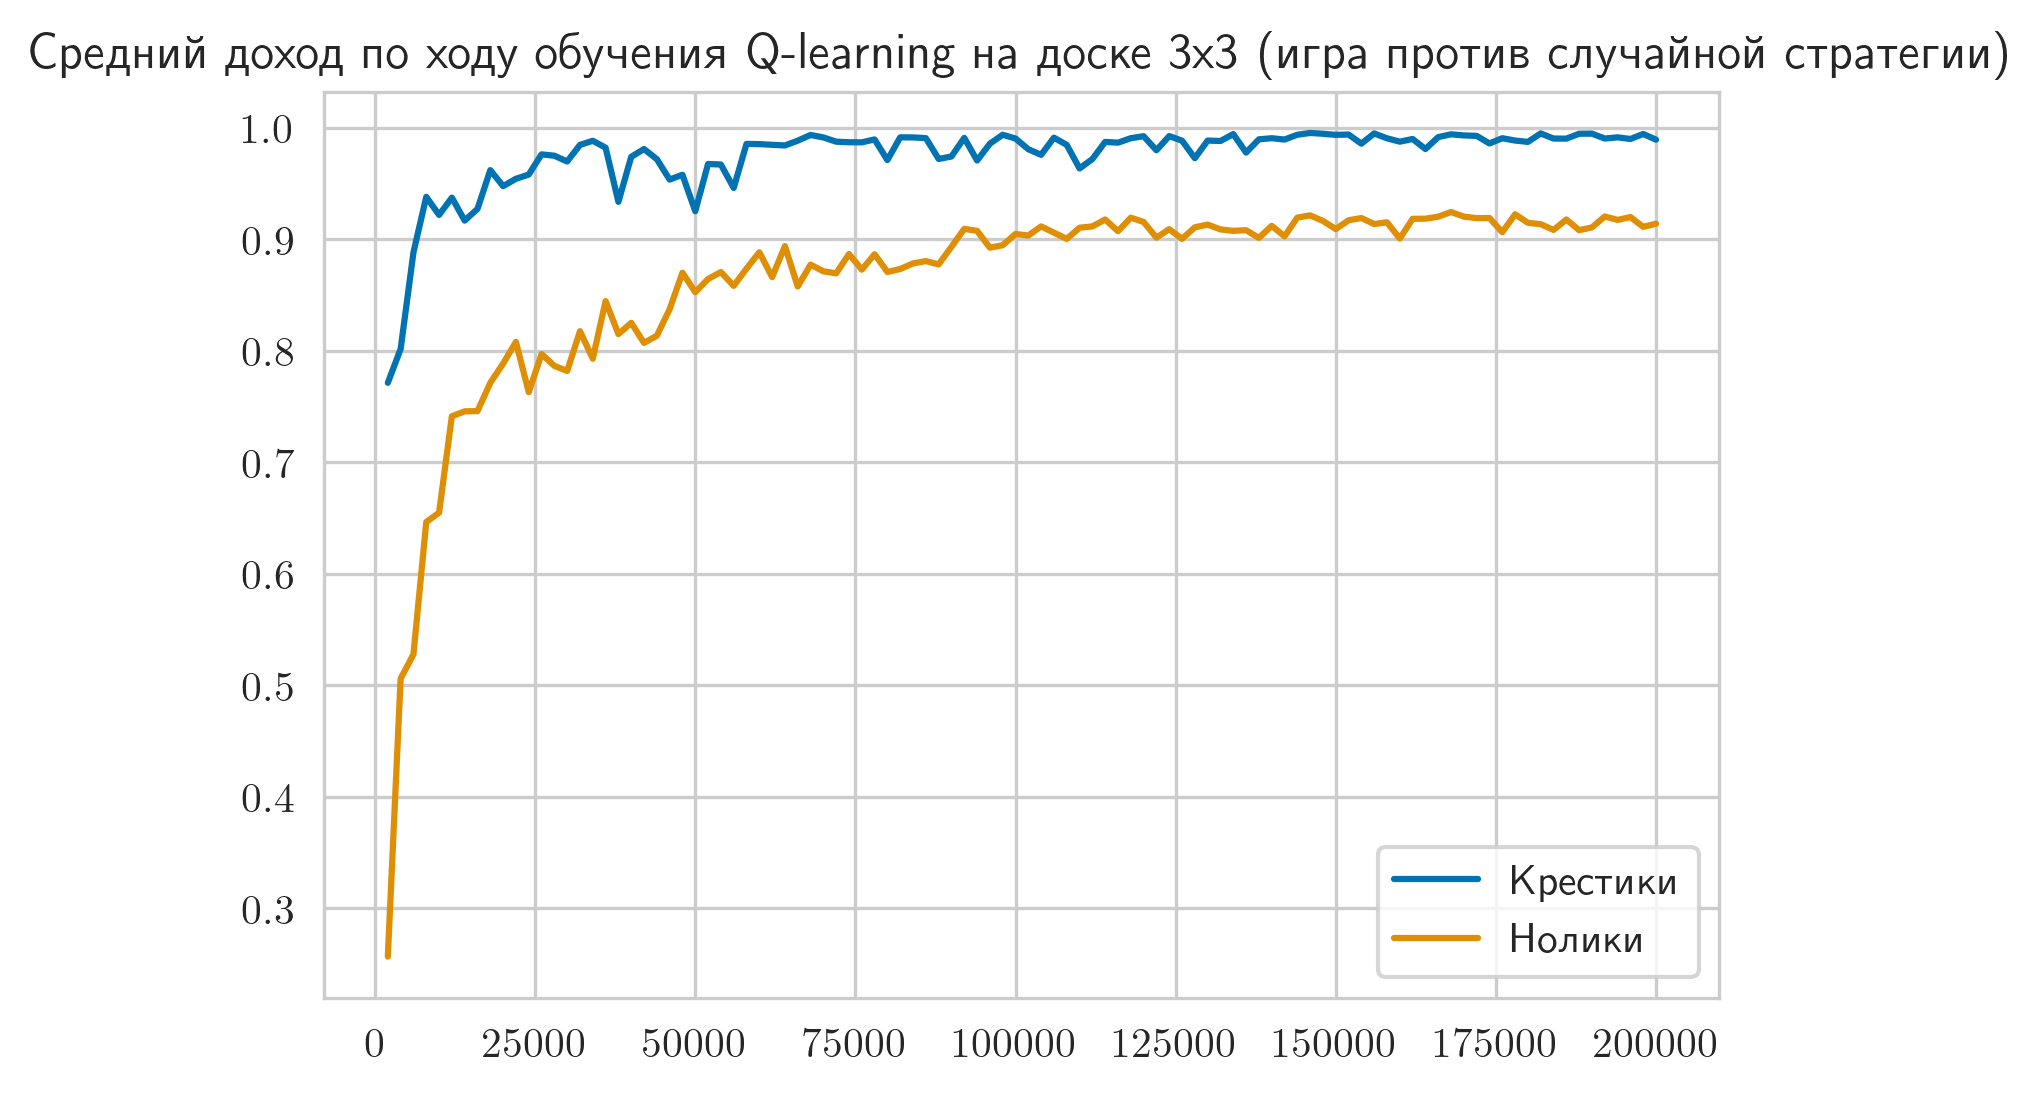

In [340]:
plt.plot(
    [x['experiment'] for x in scores_33],
    [x['score_c'] for x in scores_33],
    label='Крестики'
)

plt.plot(
    [x['experiment'] for x in scores_33],
    [x['score_n'] for x in scores_33],
    label='Нолики'
)

plt.legend()
plt.title('Средний доход по ходу обучения Q-learning на доске 3x3 (игра против случайной стратегии)')
plt.show()

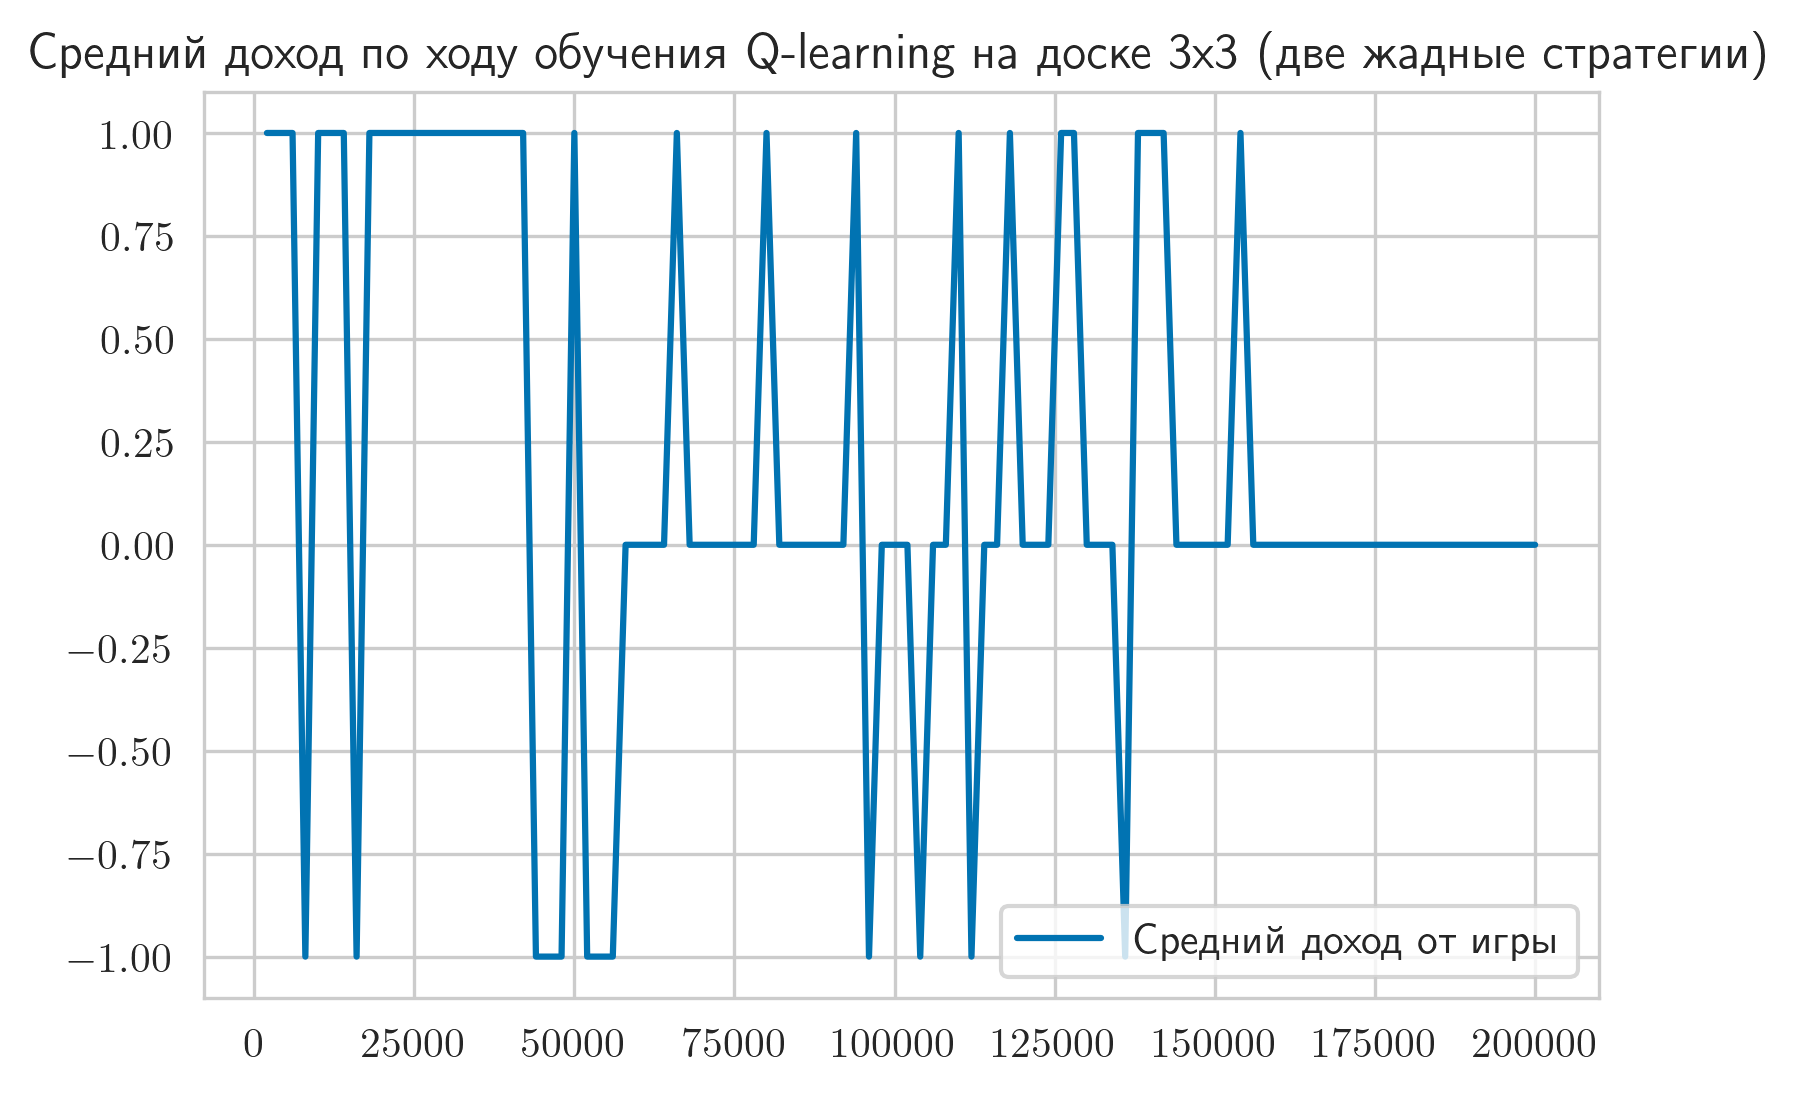

In [339]:
plt.plot(
    [x['experiment'] for x in scores_33],
    [x['score'] for x in scores_33],
    label='Средний доход от игры'
)

plt.legend()
plt.title('Средний доход по ходу обучения Q-learning на доске 3x3 (две жадные стратегии)')
plt.show()

По первому графику видно, что обе стратегии показывают рост качества в сравнении с игрой со случайным противником.

По второму графику видно, что при использовании обученных стратегий, они все чаще сходятся в ничью.

### 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

#### Начнем с доски $4x4$

In [359]:
%%time
Q_c_44, Q_n_44, scores_44 = q_learning(
    eps_constant(1.0),
    env=TicTacToe(n_rows=4, n_cols=4, n_win=4),
    num_experiments=500000,
    random_state=42,
    gamma=1.0,
    alpha=0.1,
    score_every=0.01,
    score_func=calculate_reward_by_policies,
    verbose=True
)

Score at 5000 / 500000 = 0.1227/-0.0302/0.2643
Score at 10000 / 500000 = 0.115/-0.009/-0.0444
Score at 15000 / 500000 = 0.1468/-0.0094/-0.0097
Score at 20000 / 500000 = 0.1254/0.0123/0.0999
Score at 25000 / 500000 = 0.1571/0.0229/-0.095
Score at 30000 / 500000 = 0.1677/-0.0043/0.0093
Score at 35000 / 500000 = 0.1811/0.0183/-0.2029
Score at 40000 / 500000 = 0.1864/0.023/0.1519
Score at 45000 / 500000 = 0.1793/0.0313/-0.1573
Score at 50000 / 500000 = 0.1581/0.0191/-0.1685
Score at 55000 / 500000 = 0.184/0.0061/0.3545
Score at 60000 / 500000 = 0.1733/0.0244/-0.0115
Score at 65000 / 500000 = 0.181/0.0258/-0.1237
Score at 70000 / 500000 = 0.1906/0.0557/0.4665
Score at 75000 / 500000 = 0.1959/0.0387/0.054
Score at 80000 / 500000 = 0.2262/0.0586/0.0975
Score at 85000 / 500000 = 0.2208/0.0524/0.0991
Score at 90000 / 500000 = 0.2506/0.0519/0.0663
Score at 95000 / 500000 = 0.2541/0.0547/0.284
Score at 100000 / 500000 = 0.2548/0.0745/0.4295
Score at 105000 / 500000 = 0.2565/0.0513/0.4992
Score at

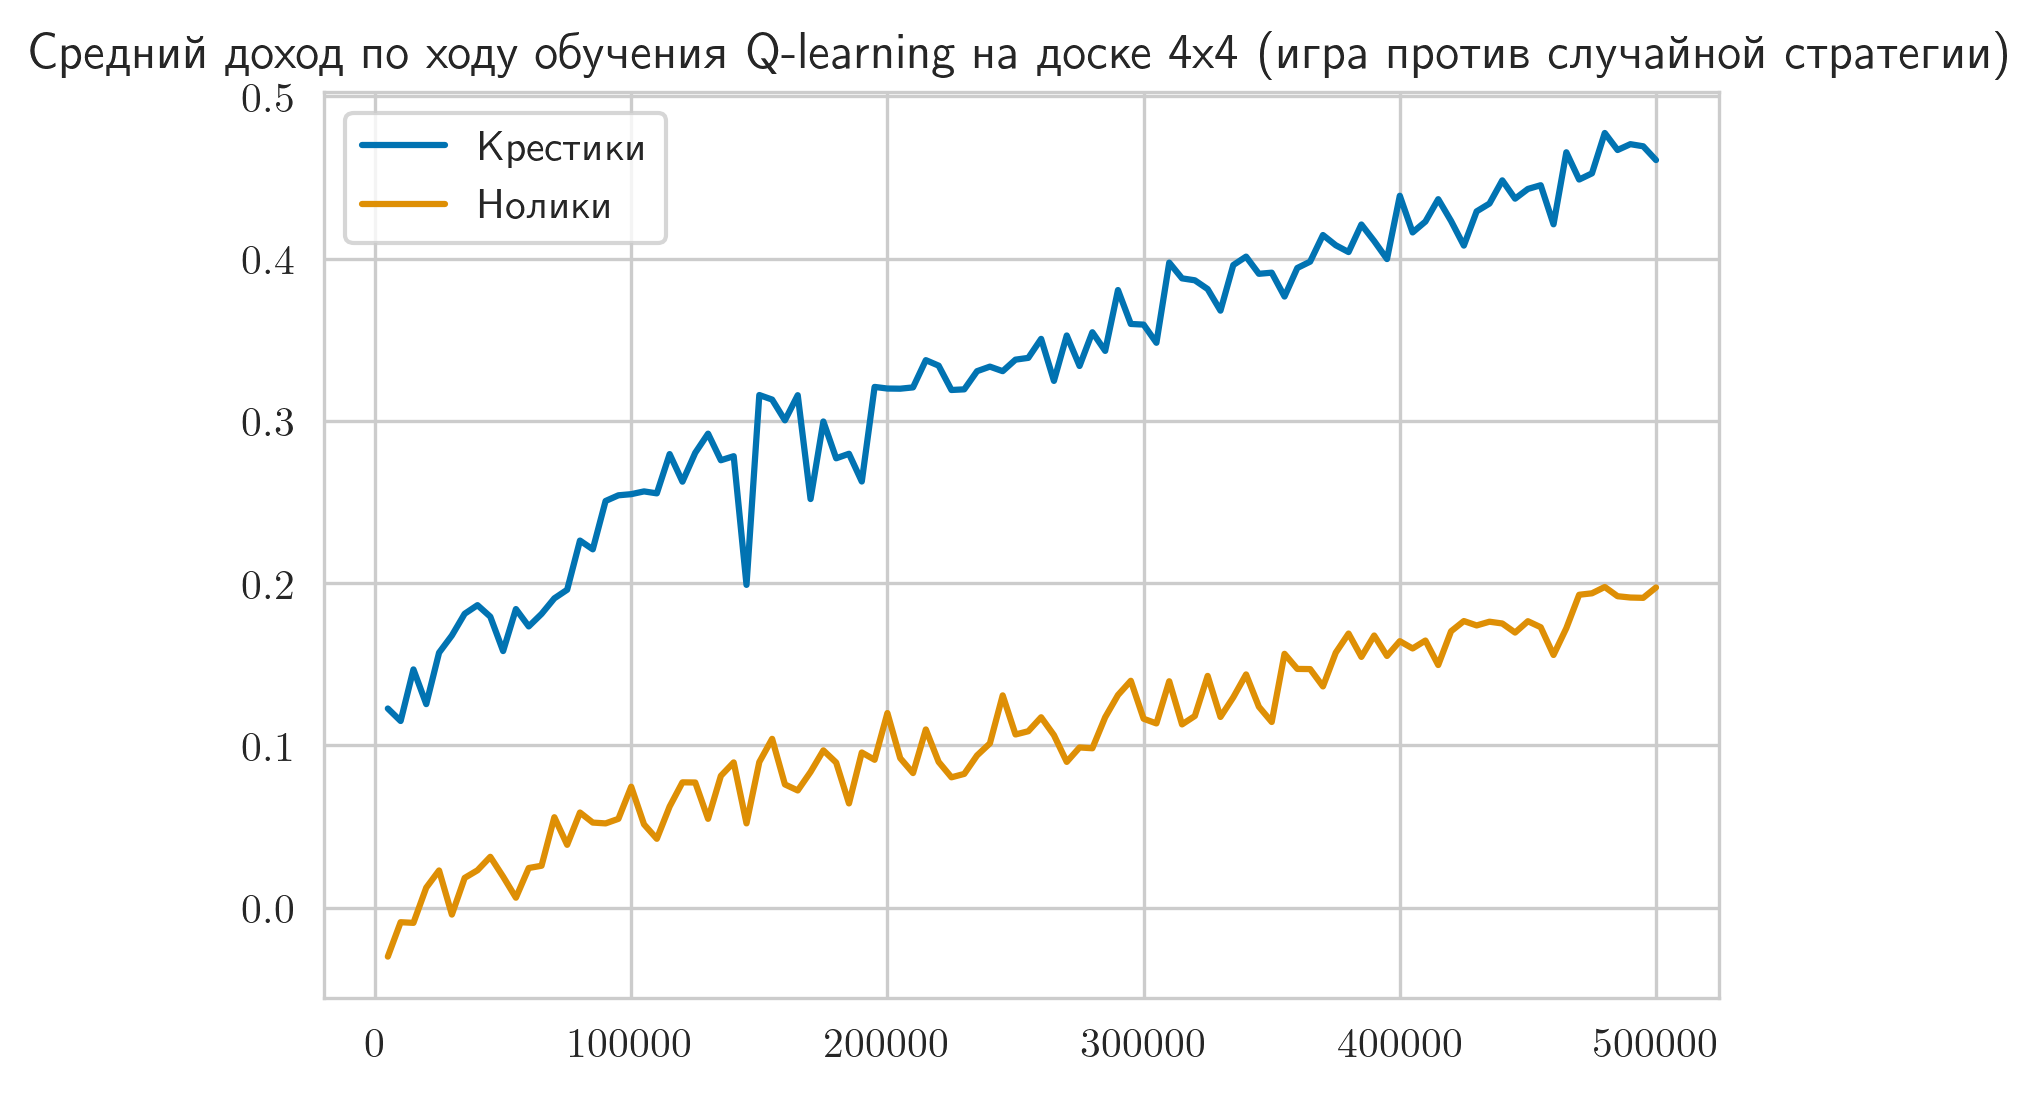

In [360]:
plt.plot(
    [x['experiment'] for x in scores_44],
    [x['score_c'] for x in scores_44],
    label='Крестики'
)

plt.plot(
    [x['experiment'] for x in scores_44],
    [x['score_n'] for x in scores_44],
    label='Нолики'
)

plt.legend()
plt.title('Средний доход по ходу обучения Q-learning на доске 4x4 (игра против случайной стратегии)')
plt.show()

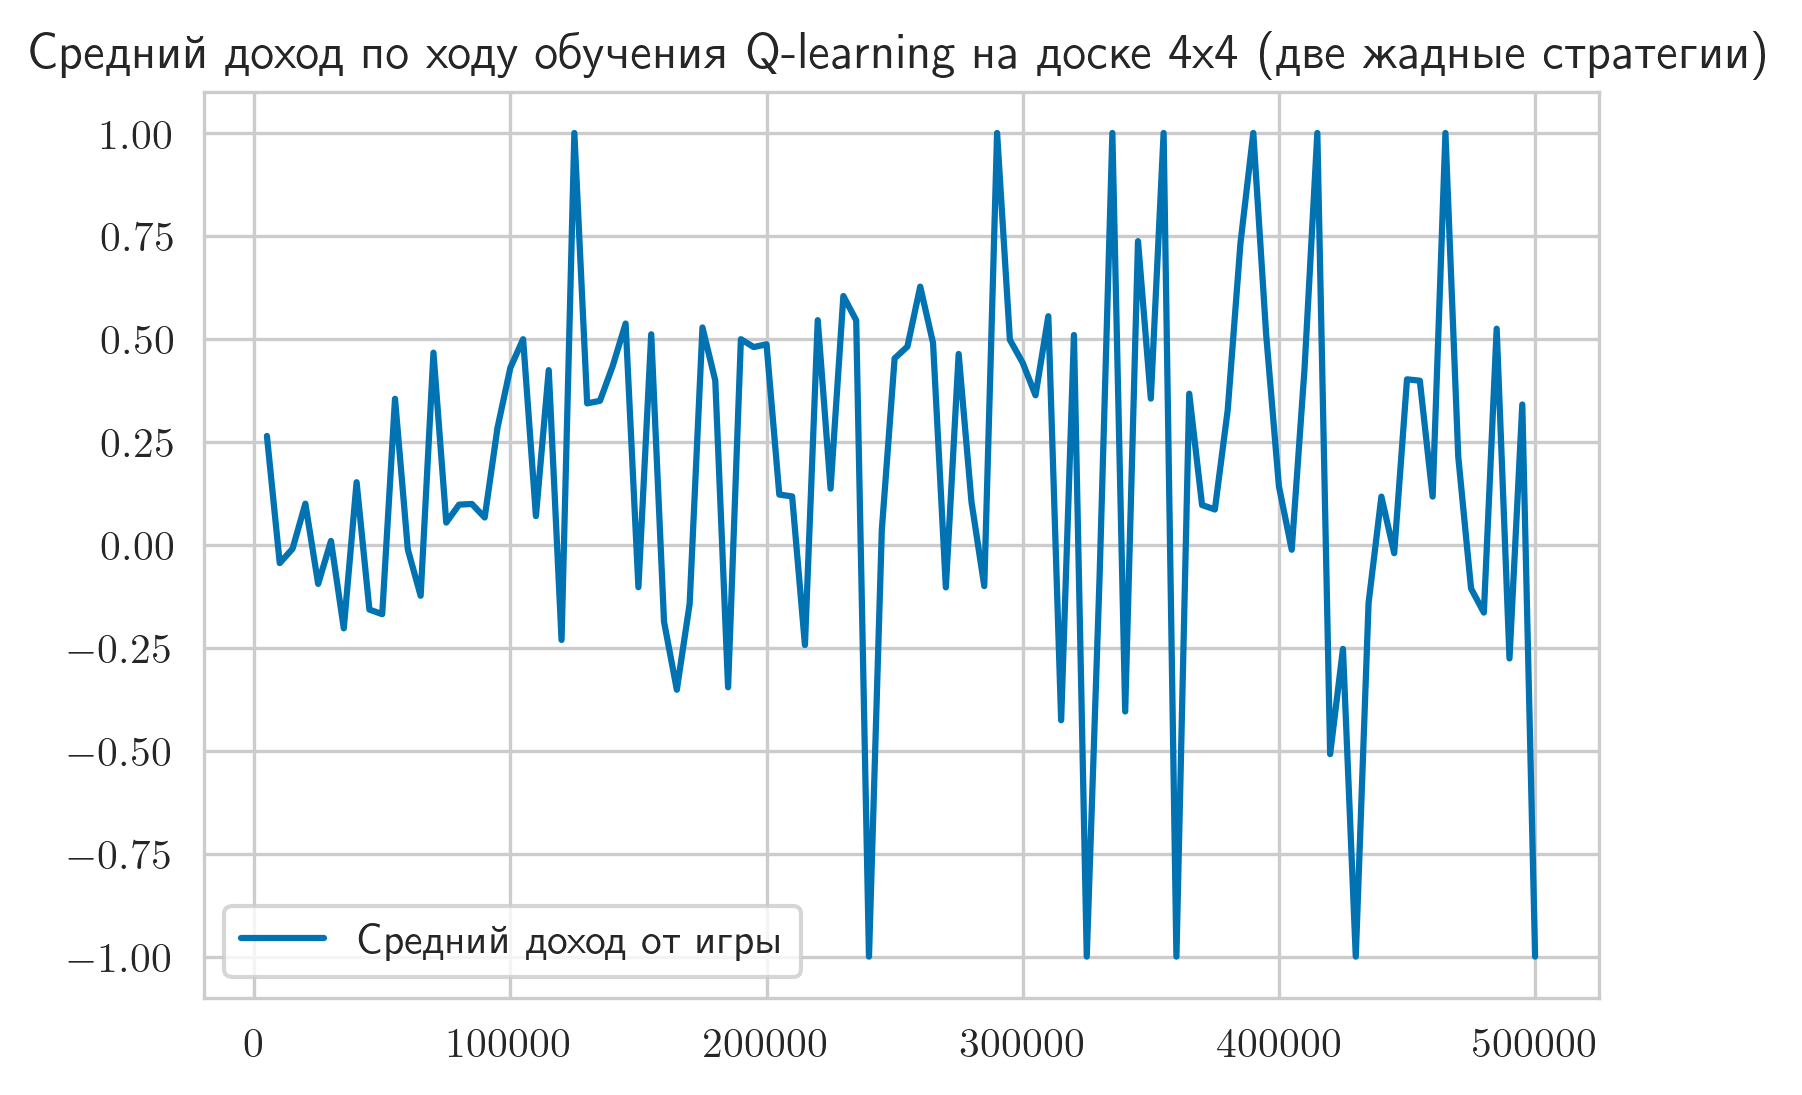

In [361]:
plt.plot(
    [x['experiment'] for x in scores_44],
    [x['score'] for x in scores_44],
    label='Средний доход от игры'
)

plt.legend()
plt.title('Средний доход по ходу обучения Q-learning на доске 4x4 (две жадные стратегии)')
plt.show()

Можно видеть, что рост уже не такой уверенный как в случае с игрой на доске $3x3$, но все же виден. Плюс в текущей реализации по пути обучения мы всегда занимаемся exploration, чтобы лучше покрыть пространство событий

#### Попробуем на доске $5x5$

In [363]:
%%time
Q_c_55, Q_n_55, scores_55 = q_learning(
    eps_constant(1.0),
    env=TicTacToe(n_rows=5, n_cols=5, n_win=5),
    num_experiments=1000000,
    random_state=42,
    gamma=1.0,
    alpha=0.1,
    score_every=0.01,
    score_func=calculate_reward_by_policies,
    verbose=True
)

Score at 10000 / 1000000 = 0.0752/-0.0813/0.0168
Score at 20000 / 1000000 = 0.087/-0.0724/0.0465
Score at 30000 / 1000000 = 0.119/-0.0789/0.1539
Score at 40000 / 1000000 = 0.1188/-0.0852/0.1194
Score at 50000 / 1000000 = 0.0713/-0.0763/-0.0025
Score at 60000 / 1000000 = 0.0691/-0.0749/0.1103
Score at 70000 / 1000000 = 0.0824/-0.0911/0.0876
Score at 80000 / 1000000 = 0.0827/-0.0718/0.089
Score at 90000 / 1000000 = 0.0724/-0.0959/0.1691
Score at 100000 / 1000000 = 0.097/-0.0914/0.0844
Score at 110000 / 1000000 = 0.1112/-0.0971/0.118
Score at 120000 / 1000000 = 0.082/-0.083/0.0901
Score at 130000 / 1000000 = 0.0775/-0.0813/0.0947
Score at 140000 / 1000000 = 0.1023/-0.0722/0.0412
Score at 150000 / 1000000 = 0.1426/-0.0891/0.0986
Score at 160000 / 1000000 = 0.1141/-0.0804/0.2062
Score at 170000 / 1000000 = 0.083/-0.0803/0.0982
Score at 180000 / 1000000 = 0.1759/-0.0774/0.1349
Score at 190000 / 1000000 = 0.1768/-0.0924/0.0682
Score at 200000 / 1000000 = 0.0869/-0.083/0.1163
Score at 210000 /

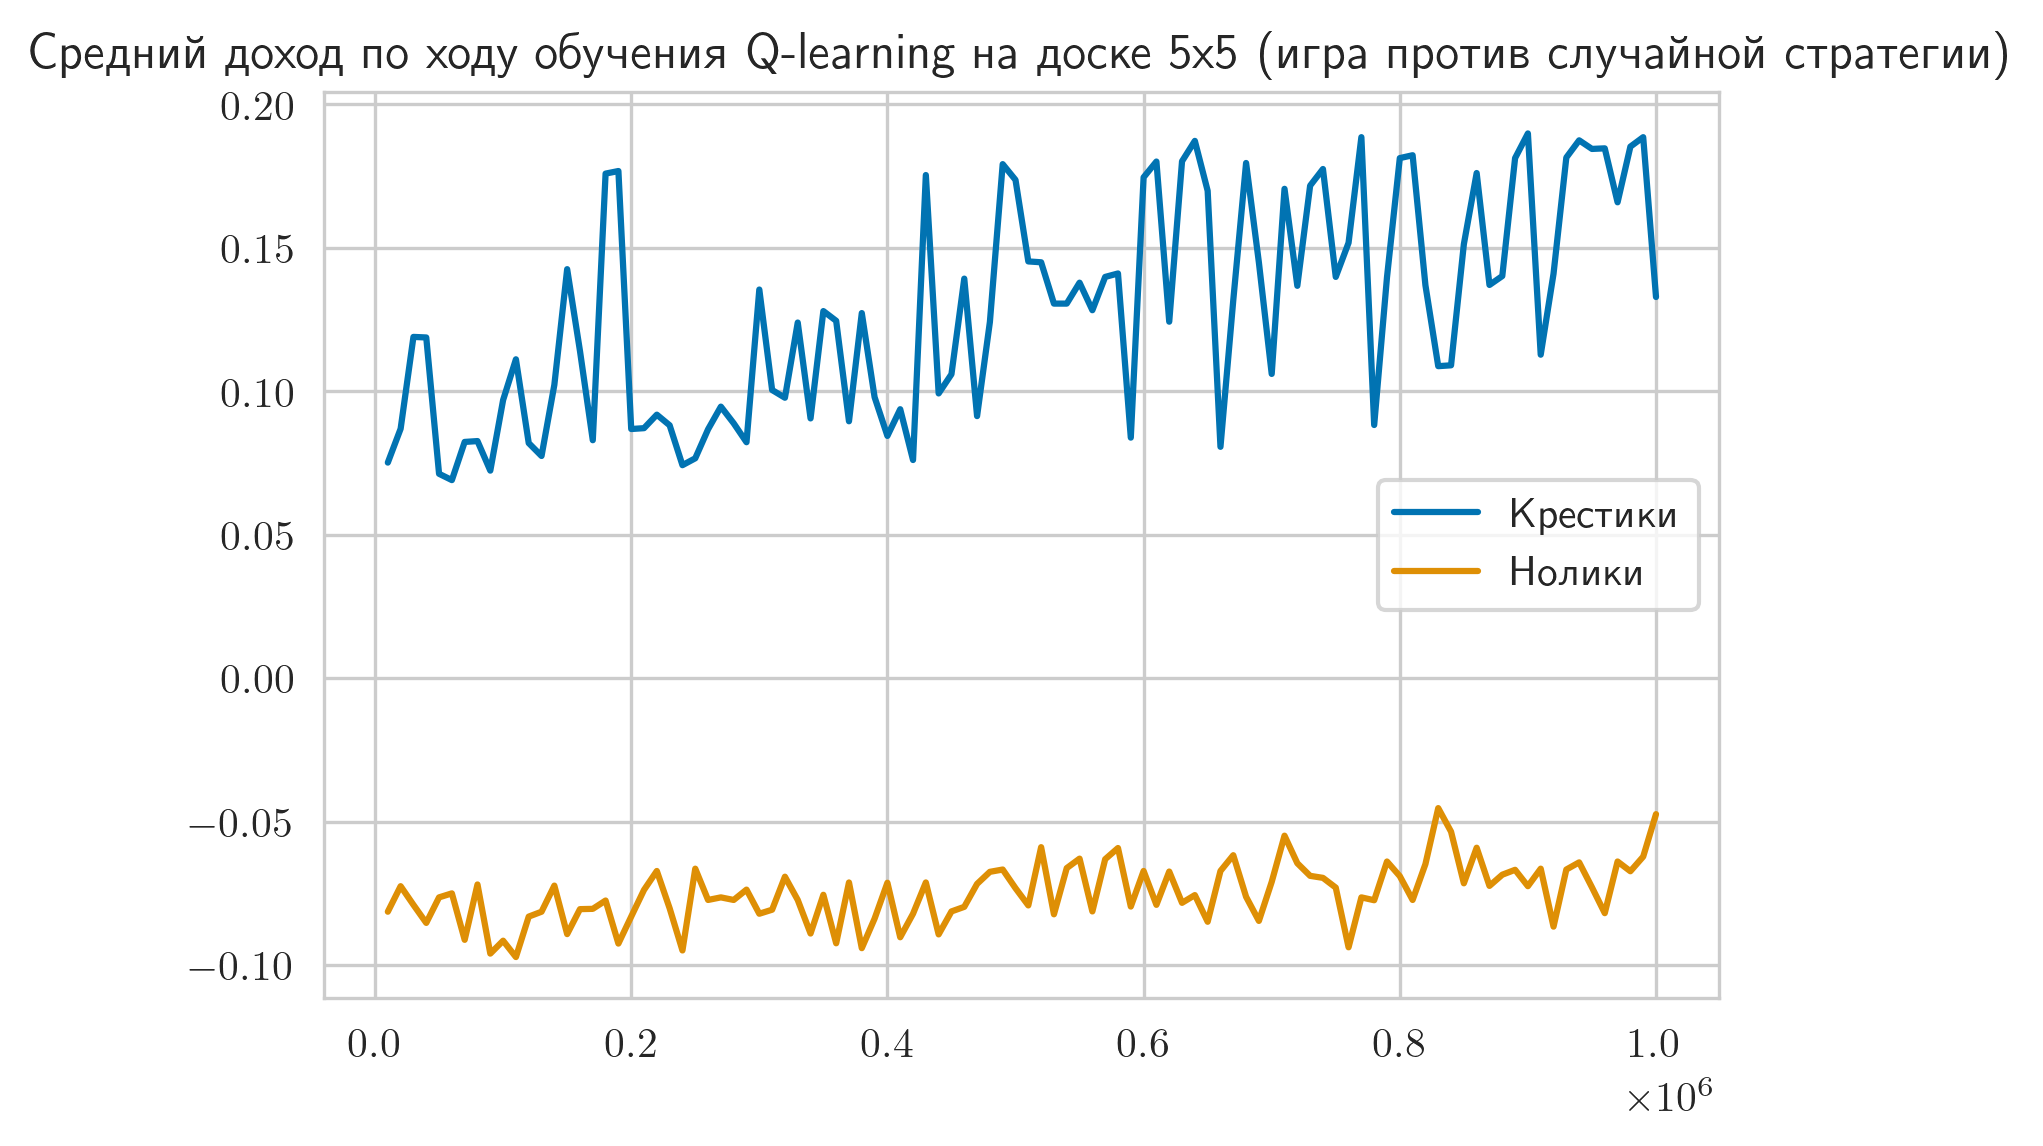

In [364]:
plt.plot(
    [x['experiment'] for x in scores_55],
    [x['score_c'] for x in scores_55],
    label='Крестики'
)

plt.plot(
    [x['experiment'] for x in scores_55],
    [x['score_n'] for x in scores_55],
    label='Нолики'
)

plt.legend()
plt.title('Средний доход по ходу обучения Q-learning на доске 5x5 (игра против случайной стратегии)')
plt.show()

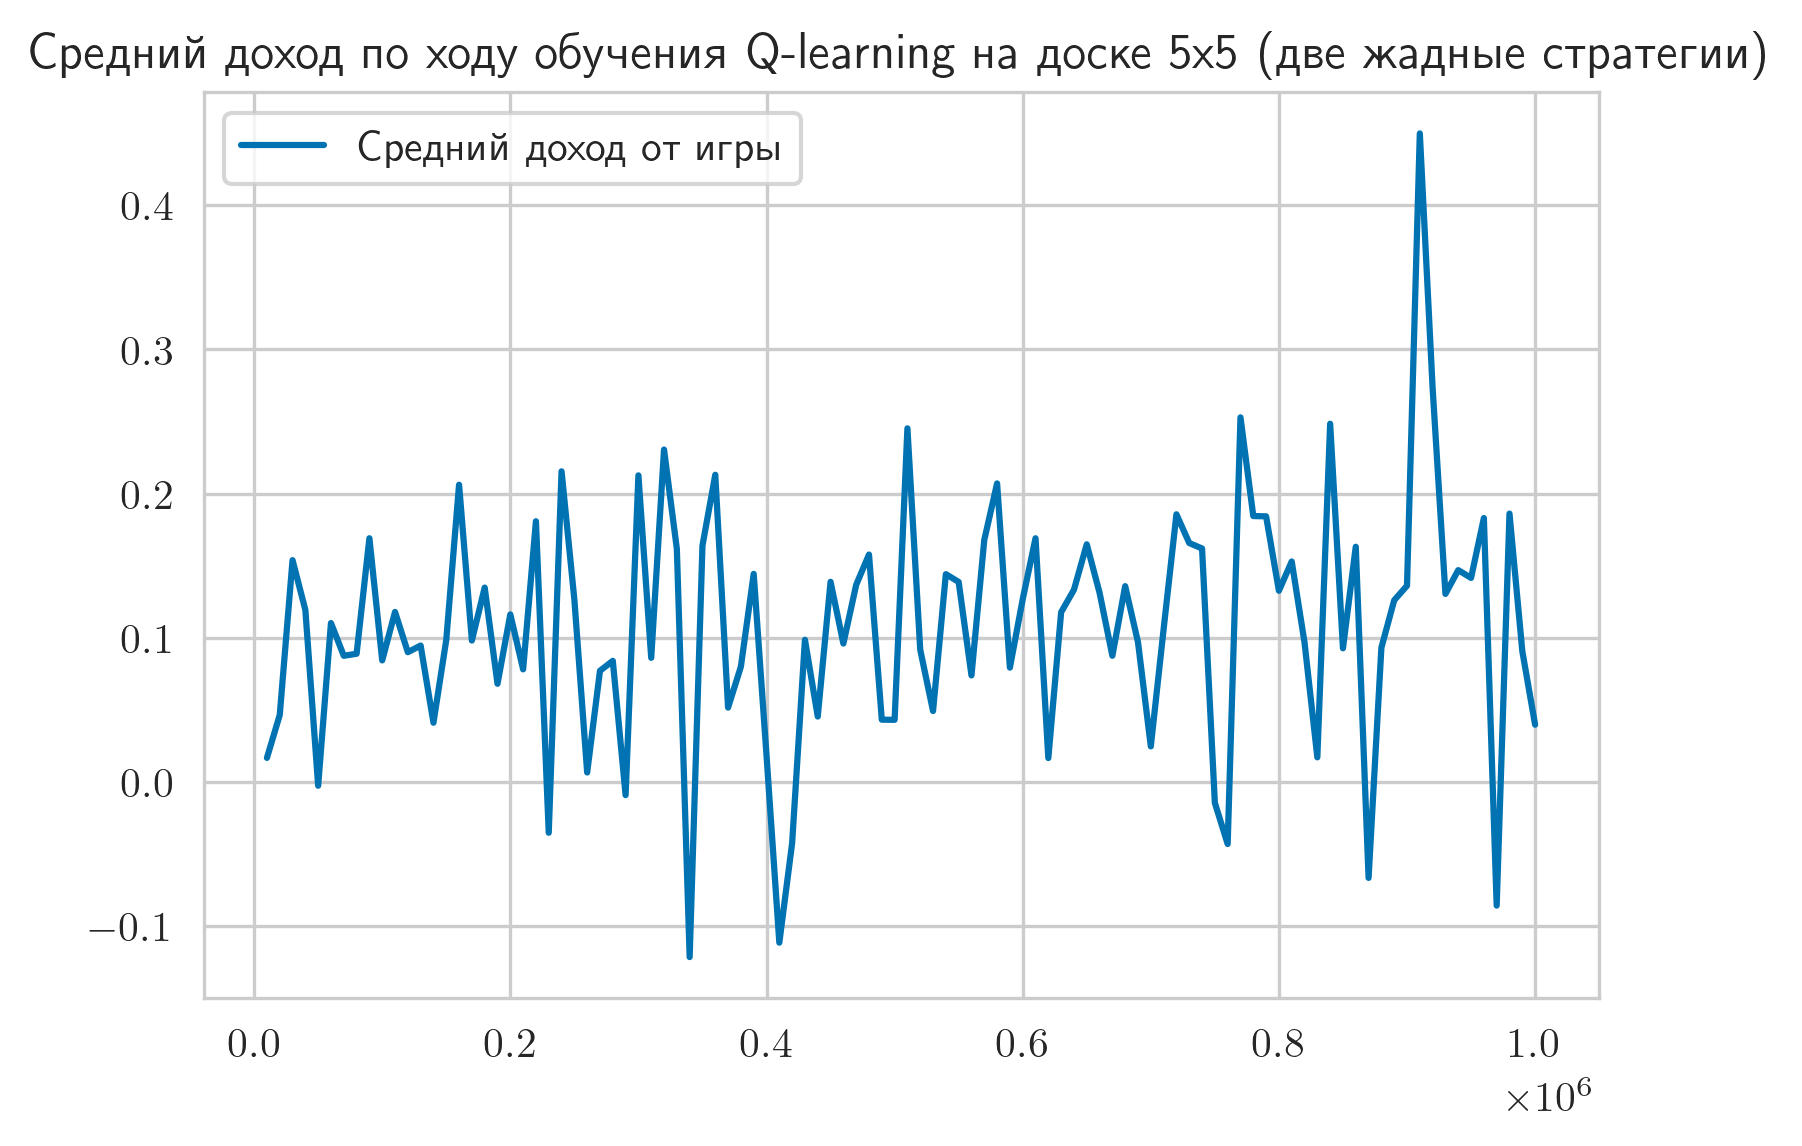

In [365]:
plt.plot(
    [x['experiment'] for x in scores_55],
    [x['score'] for x in scores_55],
    label='Средний доход от игры'
)

plt.legend()
plt.title('Средний доход по ходу обучения Q-learning на доске 5x5 (две жадные стратегии)')
plt.show()

Можно видеть, что рост уже совсем сложно назвать уверенным, но тем не менее он присутствует. Обучать это второй раз я бы не стал, при попытке поиграть со стратегией-оппонентом очень просто найти состояние, которое ни встретилось ни разу (хотя мы только и занимались exploration).

In [373]:
policy_crosses_55 = policy_q(Q_c_55, 0.0)

In [366]:
len(Q_c_55)

9217468

In [409]:
env = TicTacToe(5, 5, 5)
env.reset()
env.printBoard()

---------------------
|   |   |   |   |   | 
---------------------
|   |   |   |   |   | 
---------------------
|   |   |   |   |   | 
---------------------
|   |   |   |   |   | 
---------------------
|   |   |   |   |   | 
---------------------


In [422]:
env.step_int(policy_crosses_55(env))
env.printBoard()

---------------------
| o |   |   |   | x | 
---------------------
| o |   |   | x |   | 
---------------------
|   | x |   |   |   | 
---------------------
|   |   |   |   |   | 
---------------------
|   |   |   |   |   | 
---------------------


In [423]:
env.step((2, 0))
env.printBoard()

---------------------
| o |   |   |   | x | 
---------------------
| o |   |   | x |   | 
---------------------
| o | x |   |   |   | 
---------------------
|   |   |   |   |   | 
---------------------
|   |   |   |   |   | 
---------------------


In [424]:
env.getState() in Q_c_55

False

In [425]:
env.getState()

('0111201121021111111111111', 1)

In [426]:
next(iter(Q_c_55.keys()))

('1220002022220002220020200', 1)

## Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки $3x3$ здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

### 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [17]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

Опишем функцию, которая будет играть по политике, определяемой предсказаниями нейросети

In [20]:
def policy_nn(nn, eps=0.0):
    def strategy(env):
        # Совершаем случайное действие
        if (random.random() <= eps):
            return env.randomIntAction()
        
        # Применяем сеть
        with torch.no_grad():
            # Получаем предсказания модели
            state = torch.tensor(np.expand_dims(env.board, axis=(0, 1)), dtype=torch.float32)
            q = nn(state)[0].data.cpu().numpy()
            # Выбираем только доступные в данной позиции состояния
            available_actions = env.getEmptyInts()
            # Выбираем индекс максимально доступного состояния и возвращаем его
            return available_actions[np.argmax(q[available_actions])]
        
    return strategy

В качестве модели я решил взять простую сеть с одним сверточным слоем (по размеру доски) и несколькими линейными слоями (с нелинейностями между ними). При увеличении размера доски количество сверток и количество линейных слоев увеличивается (цифры подобраны эвристически).

In [42]:
class Network(nn.Module):
    def __init__(self, n_rows=3, n_cols=3):
        super().__init__()
        
        # Число сверток (чем больше доска, тем больше сверток)
        n_convs = int(((n_rows + n_cols) / 2 - 1) * n_rows * n_cols)
        
        # Сверточный слой
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, n_convs, kernel_size=(n_rows, n_cols)),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Считаем число признаков на выходе из предыдущего слоя
        conv_output = n_convs# * (n_rows - 2) * (n_cols - 2)
        
        # Линейный слой
        hidden_size = int(1.5 * conv_output)
        self.linear = [
            nn.Linear(conv_output, hidden_size),
            nn.Tanh(),
            nn.Dropout(0.1)
        ]
        for i in range(3**(max(n_rows, n_cols) - 2) - 2):
            self.linear.append(nn.Linear(hidden_size, hidden_size))
            self.linear.append(nn.ReLU())
            self.linear.append(nn.Dropout(0.1))
        self.linear.append(nn.Linear(hidden_size, n_rows * n_cols))
        self.linear.append(nn.Tanh())
        self.linear = nn.Sequential(*self.linear)
                
    def forward(self, x):
        x = self.conv1(x)
        x = self.linear(x)
        return x
    
x = torch.Tensor(TicTacToe(5, 5, 5).board[np.newaxis, ...])
x = torch.stack((x, x), dim=0)
print(x.shape)
n = Network(5, 5).eval()
print(n(x).shape)

torch.Size([2, 1, 5, 5])
torch.Size([2, 25])


In [41]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    elif type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

In [24]:
class TicTacToeDQN:
    def __init__(self, n_rows=3, n_cols=3, n_win=3, gamma=0.95, batch_size=64, eps_generator=eps_constant(0.85)):
        self.n_rows, self.n_cols, self.n_win = n_rows, n_cols, n_win
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_generator = eps_generator
        
        self.env = TicTacToe(n_rows, n_cols, n_win)
        
        self.model_crosses = Network(n_rows, n_cols)
        self.model_crosses.apply(init_weights)
        self.memory_crosses = ReplayMemory(100000)
        self.optimizer_crosses = optim.Adam(self.model_crosses.parameters(), 1e-3)
        self.policy_crosses = lambda eps: policy_nn(self.model_crosses, eps)(self.env)
        
        self.model_naughts = Network(n_rows, n_cols)
        self.model_naughts.apply(init_weights)
        self.memory_naughts = ReplayMemory(100000)
        self.optimizer_naughts = optim.Adam(self.model_naughts.parameters(), 1e-3)
        self.policy_naughts = lambda eps: policy_nn(self.model_naughts, eps)(self.env)
        
    def state_tensor(self):
        return torch.tensor(np.expand_dims(self.env.board, axis=(0, 1)), dtype=torch.float32)
    
    def learn(self):
        if (len(self.memory_crosses) < self.batch_size) or (len(self.memory_naughts) < self.batch_size):
            return
        
        # Переводим модели в режим обучения
        self.model_crosses.train()
        self.model_naughts.train()
        
        # Обучаем и крестики и нолики
        iterables = [
            (self.model_crosses, self.memory_crosses, self.optimizer_crosses),
            (self.model_naughts, self.memory_naughts, self.optimizer_naughts),
        ]
        for (model, memory, optimizer) in iterables:
            # Берем батч
            records = memory.sample(self.batch_size)
            batch_state, batch_action, batch_reward, batch_next_state = zip(*records)
            
            # Формируем torch тензоры
            batch_state = torch.cat(batch_state, dim=0)
            batch_action = torch.tensor(batch_action, dtype=torch.int64).unsqueeze(1)
            batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
            batch_next_state = torch.cat(batch_next_state, dim=0)
            
            # Cчитаем значения функции Q
            Q = model(batch_state).gather(1, batch_action).reshape([self.batch_size])

            # Оцениваем ожидаемые значения после этого действия
            Qmax = model(batch_next_state).detach().max(1)[0]
            Qnext = batch_reward + (self.gamma * Qmax)

            # И хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
            loss = F.smooth_l1_loss(Q, Qnext)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def run_episode(self, e=0, do_learning=True, greedy=False, render=False, use_crosses=lambda: (random.random() > 0.5)):
        # Выбираем сторону, за которую будем играть
        crosses = use_crosses()
        if render:
            print('Играем за крестики' if crosses else 'Играем за нолики')
            
        # Получаем текущий eps
        eps = next(self.eps_generator)
    
        # Переводим модели в режим inference
        self.model_crosses.eval()
        self.model_naughts.eval()
        
        # Обнуляем env
        self.env.reset()
        
        # Если начинаем игру за нолики, то необходимо совершить какой-то шаг за крестики
        if not crosses:
            policy_main, policy_other = self.policy_naughts, self.policy_crosses
            self.env.step_int(self.policy_crosses(0.0))
        else:
            policy_main, policy_other = self.policy_crosses, self.policy_naughts
            
        # Цикл по эпизоду
        while True:
            state = self.state_tensor()
            action = policy_main(eps)
#             action = policy_main(0.0)
            _, reward, done, _ = self.env.step_int(action)
            next_state = self.state_tensor()
            if not crosses:
                reward *= -1
            
            if not done:
                # Делаем шаг за другого игрока
                #_, reward, done, _ = self.env.step_int(policy_other(0.0))
                _, reward, done, _ = self.env.step_int(policy_other(eps))
                next_state = self.state_tensor()
                
                # Переворачиваем ревард, если играли за нолики
                if not crosses:
                    reward *= -1
                
            if do_learning:
                record = (state, action, reward, next_state)
                
                # Записываем опыт в память
                if crosses:
                    self.memory_crosses.store(record)
                else:
                    self.memory_naughts.store(record)
                    
                # Производим обучение
                self.learn()
                
                # Возвращаем модели в использование
                self.model_crosses.eval()
                self.model_naughts.eval()
                
                if render:
                    print('state: ', state)
                    print('next_state: ', next_state)
                    print('reward: ', reward)
                    print('done: ', done)
                    print('#######################')
            
            if done:
                break

In [109]:
def plot_nn_learning(dqn, n_episodes=100000, score_every=1000, algo='DQN'):
    scores = []
    for i in tqdm(range(n_episodes)):
        # Считаем статистики
        if (i % score_every) == 0:
            score_c, _ = calculate_reward_by_policies(policy_nn(dqn.model_crosses.eval()), policy_random(), num_experiments=1000, env=TicTacToe(dqn.n_rows, dqn.n_cols, dqn.n_win))
            _, score_n = calculate_reward_by_policies(policy_random(), policy_nn(dqn.model_naughts.eval()), num_experiments=1000, env=TicTacToe(dqn.n_rows, dqn.n_cols, dqn.n_win))
            score, _ = calculate_reward_by_policies(policy_nn(dqn.model_crosses.eval()), policy_nn(dqn.model_naughts.eval()), num_experiments=1000, env=TicTacToe(dqn.n_rows, dqn.n_cols, dqn.n_win))
            
            scores.append({
                'experiment': i + 1,
                'score_c': score_c,
                'score_n': score_n,
                'score': score,
            })
            
            print(f'Score at {i+1} / {n_episodes} = {score_c}/{score_n}/{score}', flush=True)
        
        # Обучение
        dqn.run_episode(e=i)
     
    # Строим графики
    plt.plot(
        [x['experiment'] for x in scores],
        [x['score_c'] for x in scores],
        label='Крестики'
    )
    plt.plot(
        [x['experiment'] for x in scores],
        [x['score_n'] for x in scores],
        label='Нолики'
    )
    plt.legend()
    plt.title(f'Средний доход по ходу обучения {algo} на доске {dqn.n_rows}x{dqn.n_cols} (игра против случайной стратегии)')
    plt.show()
    
    plt.plot(
        [x['experiment'] for x in scores],
        [x['score'] for x in scores],
        label='Средний доход от игры'
    )
    plt.legend()
    plt.title(f'Средний доход по ходу обучения {algo} на доске {dqn.n_rows}x{dqn.n_cols} (две жадные стратегии)')
    plt.show()

#### $3x3$

In [26]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
dqn33 = TicTacToeDQN(3, 3, 3, batch_size=512, eps_generator=eps_constant(0.85))

Score at 1 / 50000 = 0.2455/-0.6763/1.0
Score at 2001 / 50000 = 0.4886/0.3299/-1.0
Score at 4001 / 50000 = 0.6055/0.3184/-1.0
Score at 6001 / 50000 = 0.7033/0.2429/-1.0
Score at 8001 / 50000 = 0.7842/0.4057/-1.0
Score at 10001 / 50000 = 0.7422/0.4029/0.0
Score at 12001 / 50000 = 0.7979/0.318/-1.0
Score at 14001 / 50000 = 0.8309/0.3336/0.0
Score at 16001 / 50000 = 0.8127/0.2809/-1.0
Score at 18001 / 50000 = 0.8629/0.4321/-1.0
Score at 20001 / 50000 = 0.8462/0.4096/-1.0
Score at 22001 / 50000 = 0.8351/0.4371/0.0
Score at 24001 / 50000 = 0.7918/0.6567/1.0
Score at 26001 / 50000 = 0.8909/0.7463/-1.0
Score at 28001 / 50000 = 0.7569/0.7581/0.0
Score at 30001 / 50000 = 0.8721/0.7356/1.0
Score at 32001 / 50000 = 0.87/0.7457/0.0
Score at 34001 / 50000 = 0.8921/0.7621/0.0
Score at 36001 / 50000 = 0.8851/0.7882/0.0
Score at 38001 / 50000 = 0.8992/0.8441/0.0
Score at 40001 / 50000 = 0.9289/0.8164/0.0
Score at 42001 / 50000 = 0.8147/0.8149/-1.0
Score at 44001 / 50000 = 0.9011/0.8299/0.0
Score at 46

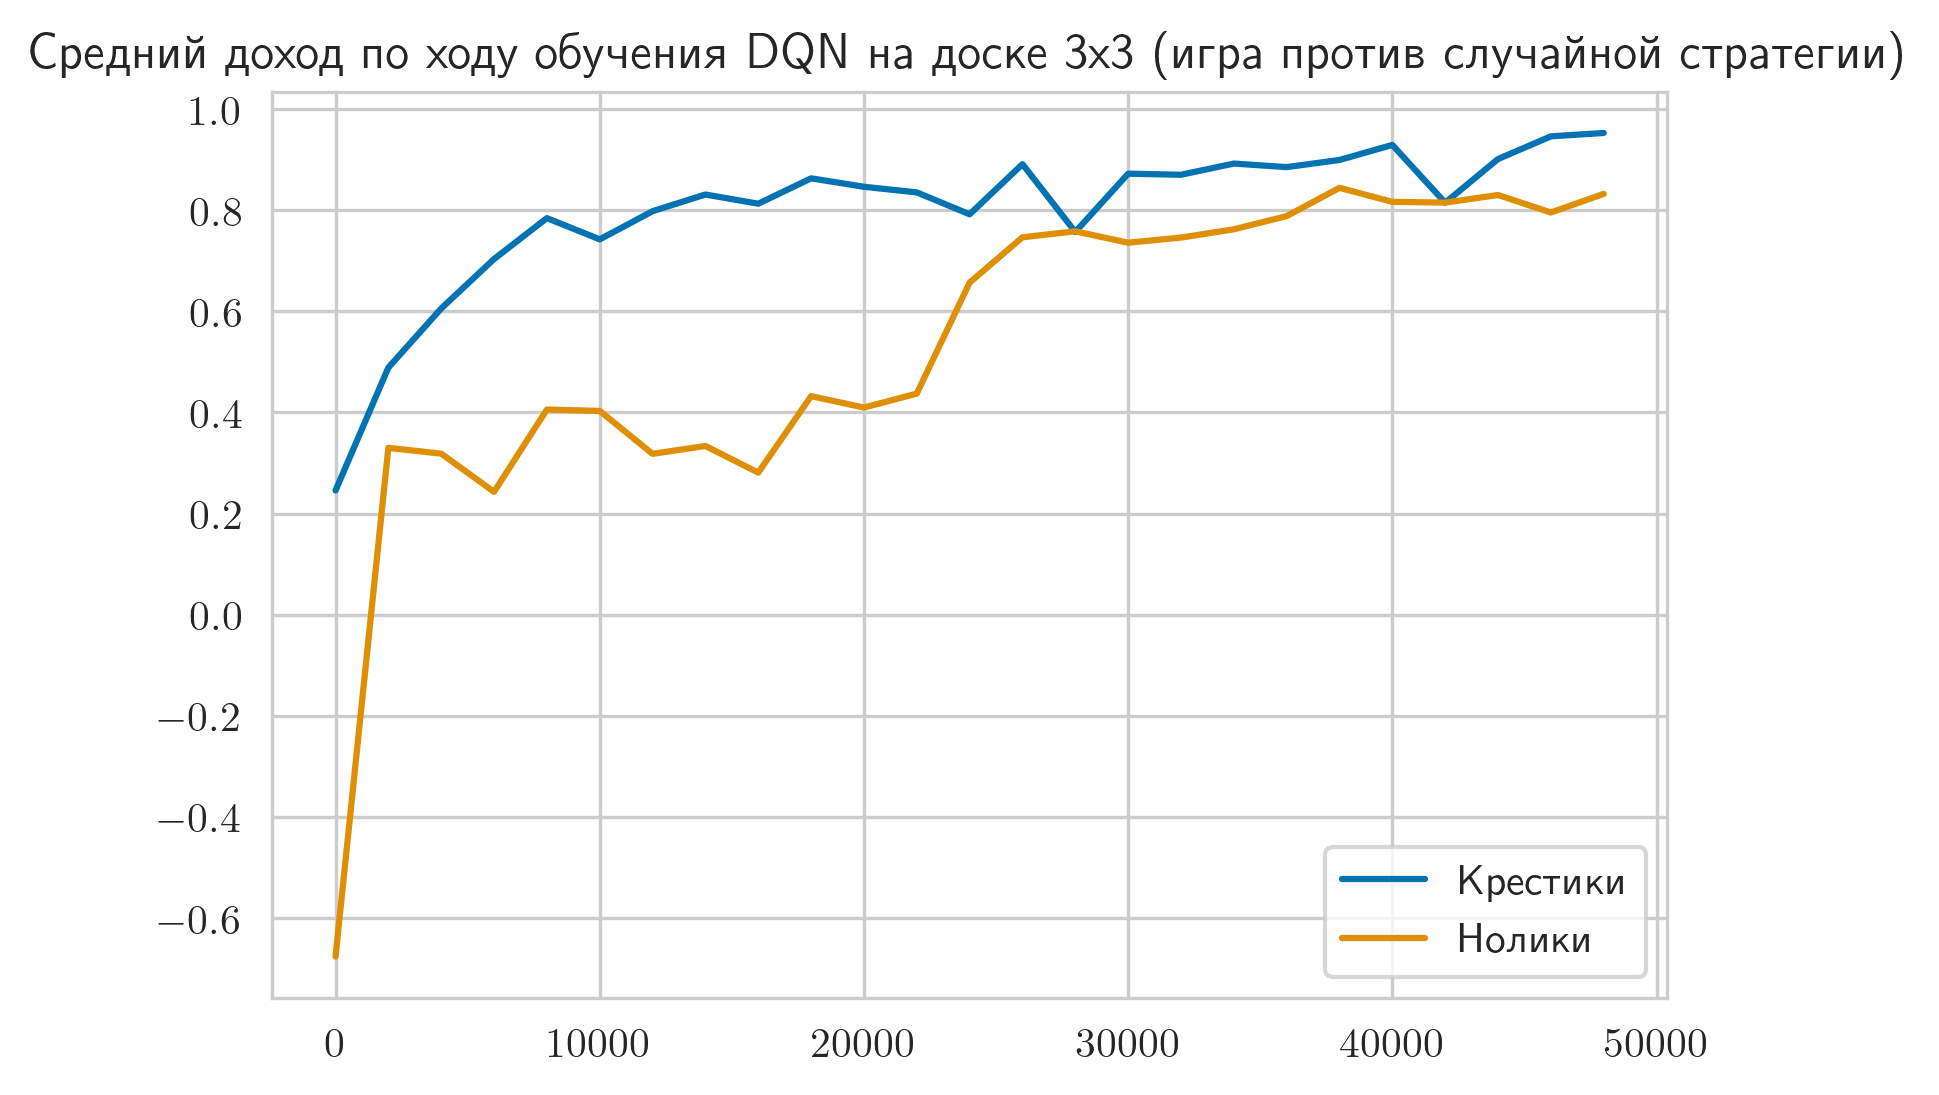

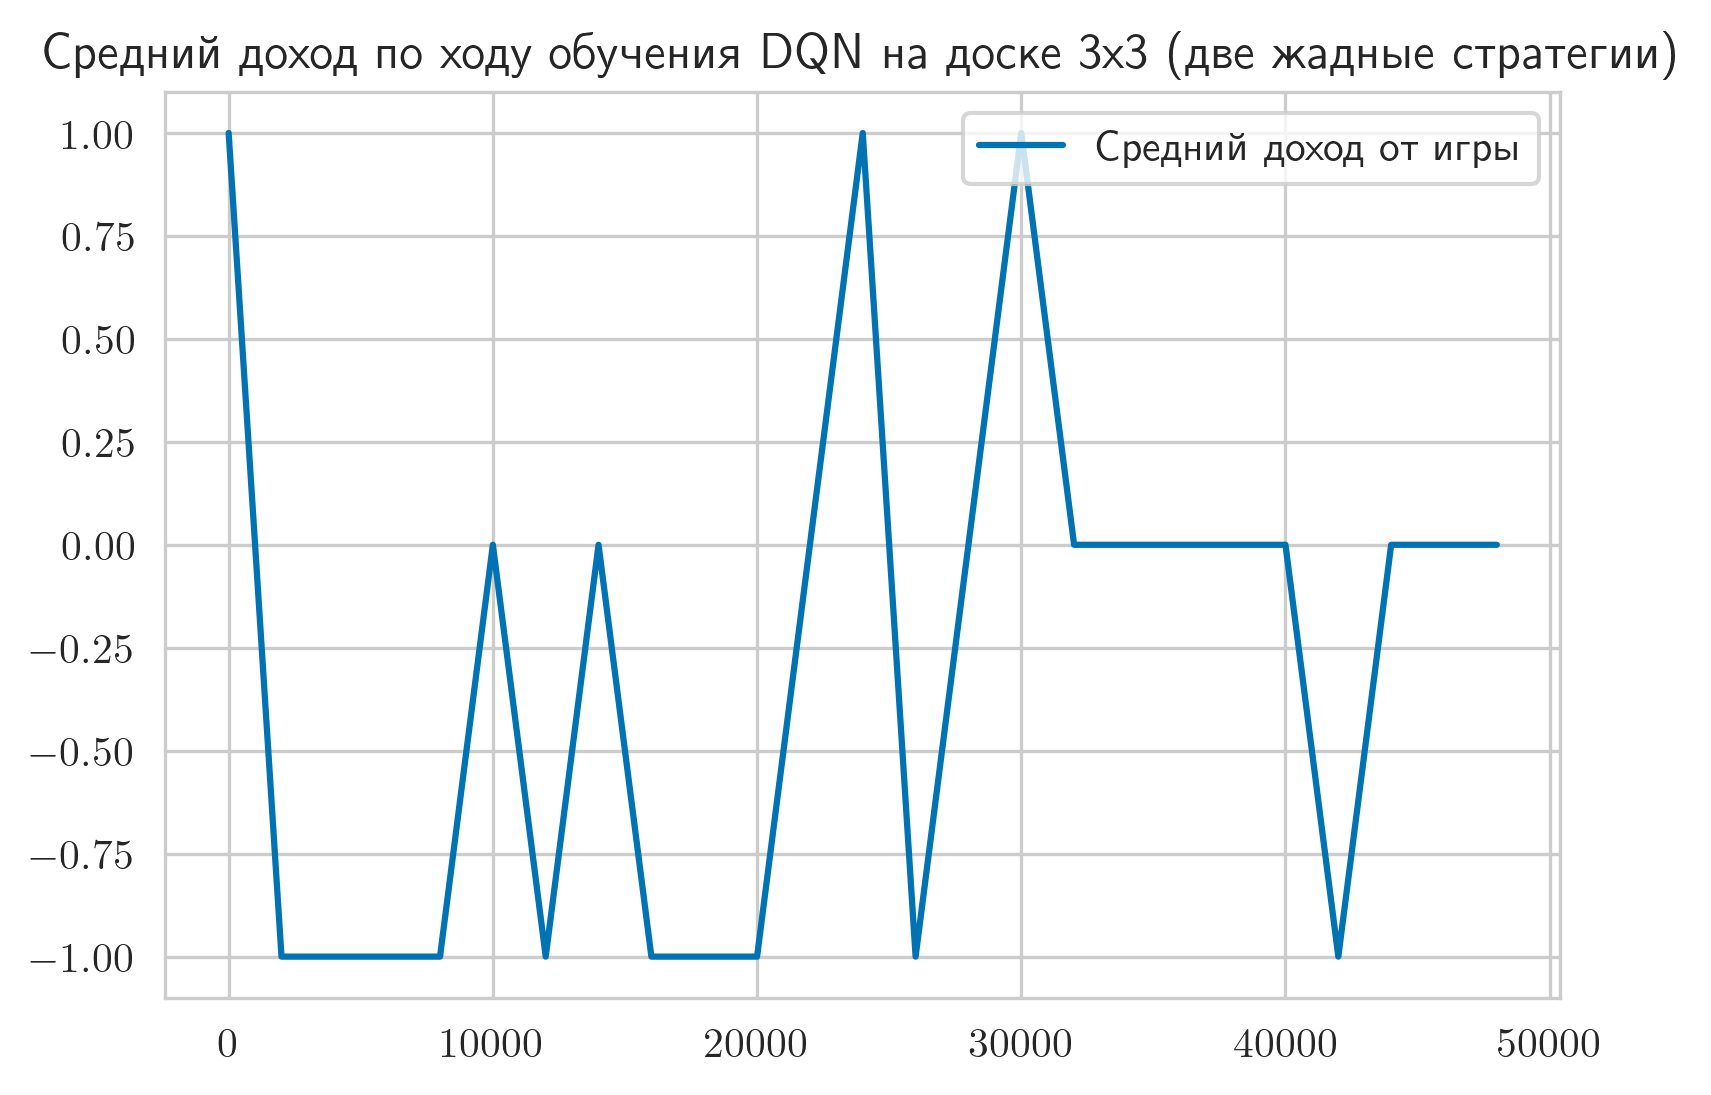

In [27]:
plot_nn_learning(dqn33, n_episodes=50000, score_every=2000)

#### $4x4$

In [44]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
dqn44 = TicTacToeDQN(4, 4, 4, batch_size=512, eps_generator=eps_constant(0.85))

Score at 1 / 100000 = -0.1257/-0.0387/-1.0
Score at 4001 / 100000 = 0.2837/0.2041/-1.0
Score at 8001 / 100000 = 0.4993/0.287/1.0
Score at 12001 / 100000 = 0.7056/0.3301/1.0
Score at 16001 / 100000 = 0.7412/0.2764/1.0
Score at 20001 / 100000 = 0.5427/0.4553/-1.0
Score at 24001 / 100000 = 0.6275/0.3405/-1.0
Score at 28001 / 100000 = 0.6898/0.3722/-1.0
Score at 32001 / 100000 = 0.642/0.3652/-1.0
Score at 36001 / 100000 = 0.643/0.6578/-1.0
Score at 40001 / 100000 = 0.7316/0.6127/0.0
Score at 44001 / 100000 = 0.7374/0.6344/0.0
Score at 48001 / 100000 = 0.6956/0.6116/0.0
Score at 52001 / 100000 = 0.7177/0.5568/0.0
Score at 56001 / 100000 = 0.6371/0.5649/0.0
Score at 60001 / 100000 = 0.7059/0.7219/0.0
Score at 64001 / 100000 = 0.6896/0.5812/0.0
Score at 68001 / 100000 = 0.6797/0.6445/0.0
Score at 72001 / 100000 = 0.6565/0.521/1.0
Score at 76001 / 100000 = 0.5793/0.6195/0.0
Score at 80001 / 100000 = 0.6324/0.6307/0.0
Score at 84001 / 100000 = 0.6596/0.6417/0.0
Score at 88001 / 100000 = 0.5398/

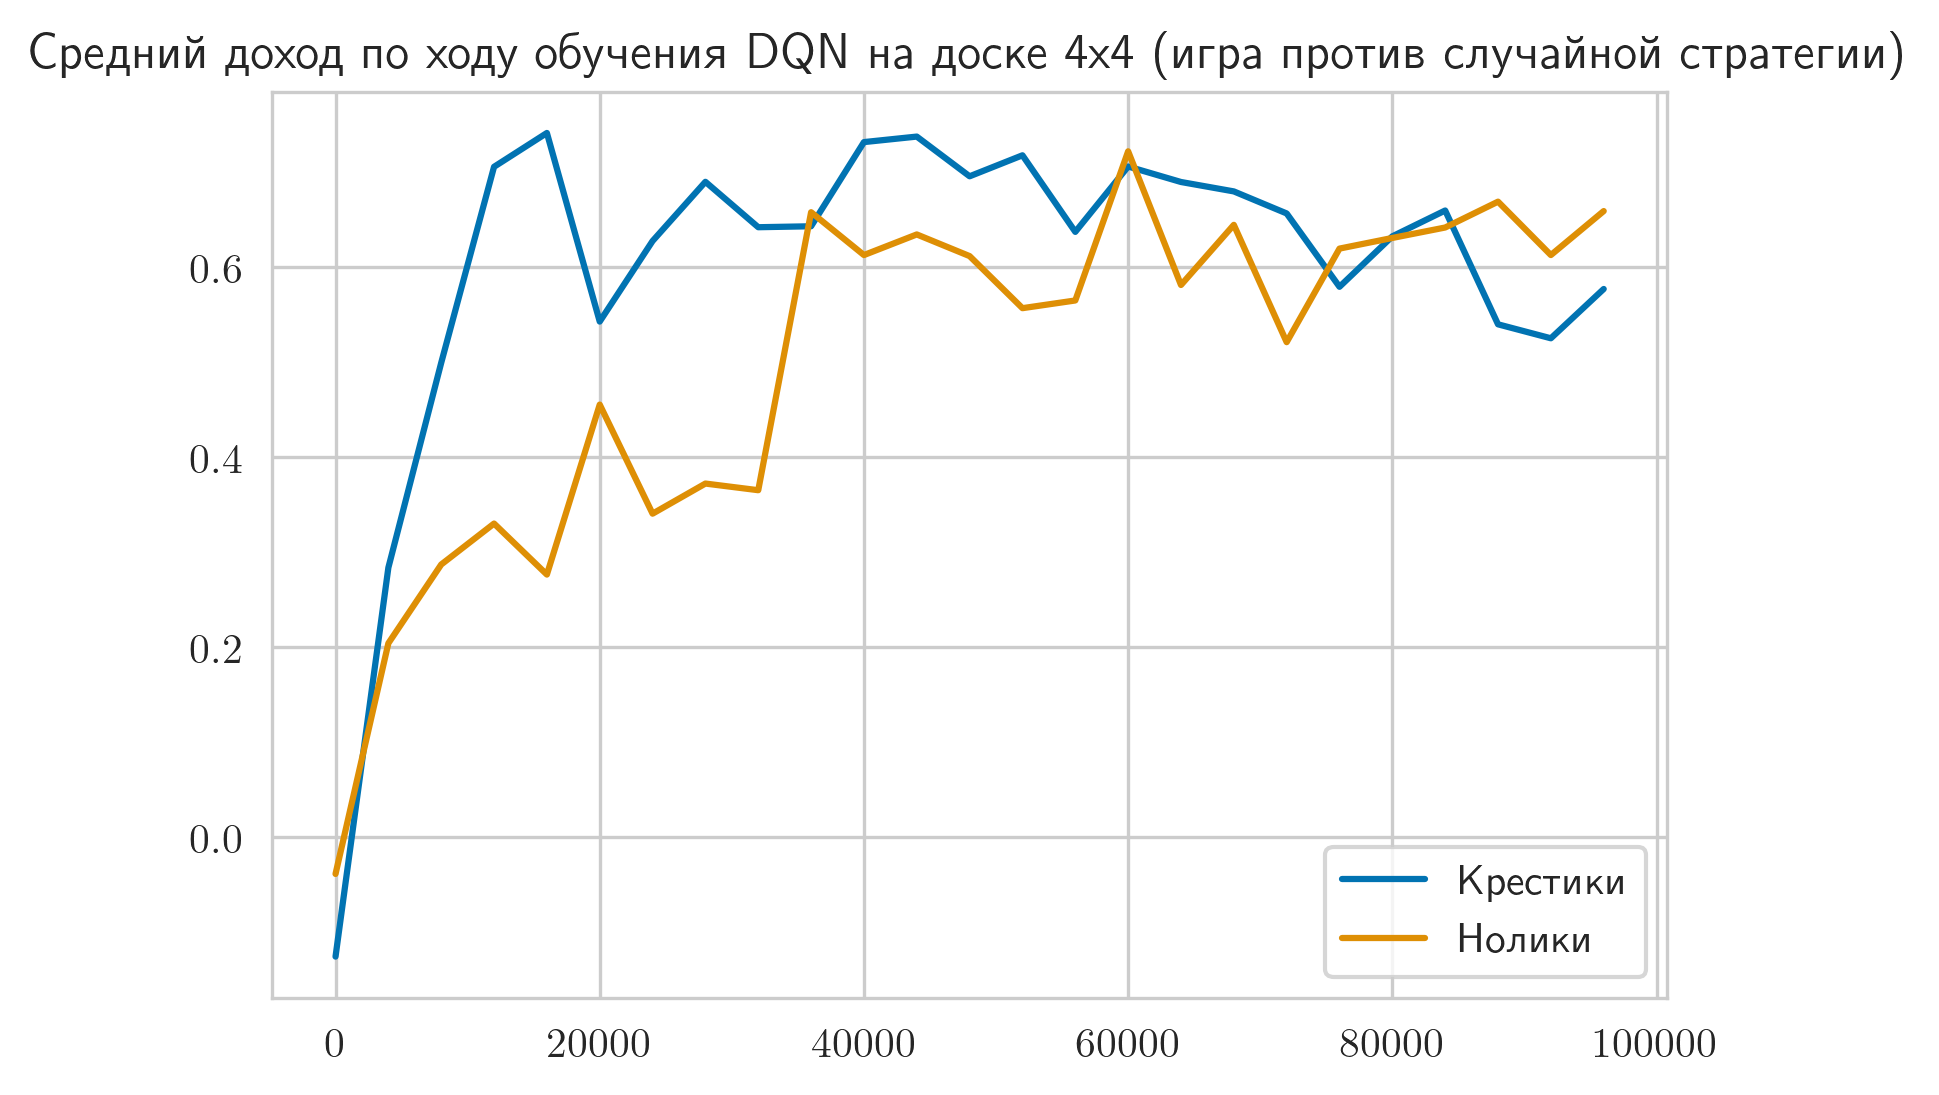

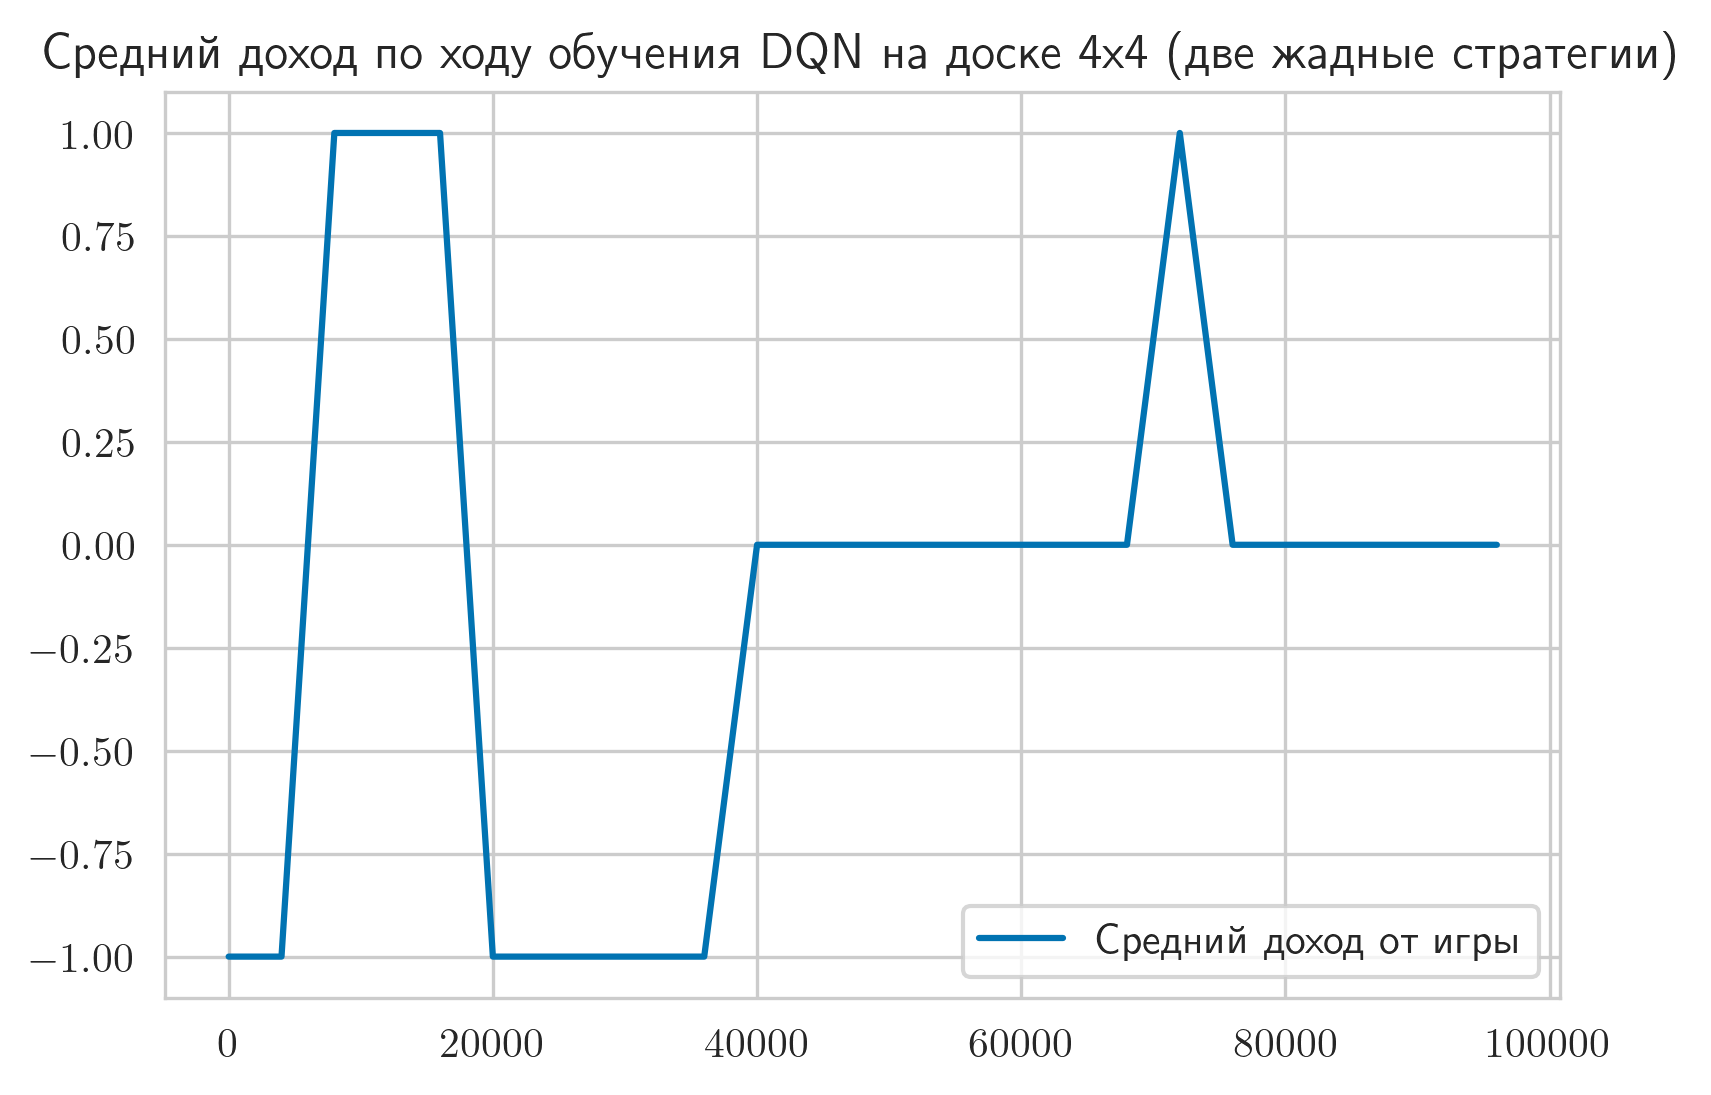

In [45]:
plot_nn_learning(dqn44, n_episodes=100000, score_every=4000)

#### $5x5$

In [46]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
dqn55 = TicTacToeDQN(5, 5, 5, batch_size=512, eps_generator=eps_constant(0.85))

In [47]:
plot_nn_learning(dqn55, n_episodes=100000, score_every=10000)

Score at 1 / 100000 = -0.1337/-0.0602/1.0
Score at 10001 / 100000 = 0.6018/0.2204/1.0
Score at 20001 / 100000 = 0.5946/0.2064/1.0
Score at 30001 / 100000 = 0.597/0.2237/1.0



KeyboardInterrupt: 

В целом видно, что все три модели сходятся, однако на больших досках это занимает очень много времени + работает все это не очень стабильно.

### 4. Реализуйте Double DQN и/или Dueling DQN.

In [101]:
def plot_nn_learning_double(dqn, n_episodes=100000, score_every=1000, algo='Double DQN'):
    scores = []
    
    # Обучение
    try:
        for i in tqdm(range(n_episodes)):
            # Считаем статистики
            if (i % score_every) == 0:
                score_c, _ = calculate_reward_by_policies(policy_nn(dqn.models_crosses[0].eval()), policy_random(), num_experiments=10000, env=TicTacToe(dqn.n_rows, dqn.n_cols, dqn.n_win))
                _, score_n = calculate_reward_by_policies(policy_random(), policy_nn(dqn.models_naughts[0].eval()), num_experiments=10000, env=TicTacToe(dqn.n_rows, dqn.n_cols, dqn.n_win))
                score, _ = calculate_reward_by_policies(policy_nn(dqn.models_crosses[0].eval()), policy_nn(dqn.models_naughts[0].eval()), num_experiments=10000, env=TicTacToe(dqn.n_rows, dqn.n_cols, dqn.n_win))

                scores.append({
                    'experiment': i + 1,
                    'score_c': score_c,
                    'score_n': score_n,
                    'score': score,
                })

                print(f'Score at {i+1} / {n_episodes} = {score_c}/{score_n}/{score}', flush=True)
        
            dqn.run_episode(e=i)
    except KeyboardInterrupt:
        pass
     
    # Строим графики
    plt.plot(
        [x['experiment'] for x in scores],
        [x['score_c'] for x in scores],
        label='Крестики'
    )
    plt.plot(
        [x['experiment'] for x in scores],
        [x['score_n'] for x in scores],
        label='Нолики'
    )
    plt.legend()
    plt.title(f'Средний доход по ходу обучения {algo} на доске {dqn.n_rows}x{dqn.n_cols} (игра против случайной стратегии)')
    plt.show()
    
    plt.plot(
        [x['experiment'] for x in scores],
        [x['score'] for x in scores],
        label='Средний доход от игры'
    )
    plt.legend()
    plt.title(f'Средний доход по ходу обучения {algo} на доске {dqn.n_rows}x{dqn.n_cols} (две жадные стратегии)')
    plt.show()

[Introduction to Dueling Double Deep Q Network](https://medium.com/analytics-vidhya/introduction-to-dueling-double-deep-q-network-d3qn-8353a42f9e55)

![](https://miro.medium.com/max/633/1*omaRQypqFujVZUWTRYB1vw.png)

![](https://miro.medium.com/max/344/1*T-oR8qU2651nCTGfyAuHpA.png)

In [80]:
class DuelingNetwork(nn.Module):
    def __init__(self, n_rows=3, n_cols=3):
        super().__init__()
        
        # Число сверток (чем больше доска, тем больше сверток)
        n_convs = int(((n_rows + n_cols) / 2 - 1) * n_rows * n_cols)
        
        # Сверточный слой
        self.embed = nn.Sequential(
            nn.Conv2d(1, n_convs, kernel_size=(n_rows, n_cols)),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Считаем число признаков на выходе из предыдущего слоя
        conv_output = n_convs# * (n_rows - 2) * (n_cols - 2)
        
        # Прикинем размер скрытого слоя
        hidden_size = int(1.5 * conv_output)
        
        # Линейный слой (для V)
        self.v_layer = [
            nn.Linear(conv_output, hidden_size),
            nn.Tanh(),
            nn.Dropout(0.1)
        ]
        for i in range(3**(max(n_rows, n_cols) - 2) - 2):
            self.v_layer.append(nn.Linear(hidden_size, hidden_size))
            self.v_layer.append(nn.ReLU())
            self.v_layer.append(nn.Dropout(0.1))
        self.v_layer.append(nn.Linear(hidden_size, 1))
        self.v_layer.append(nn.Tanh())
        self.v_layer = nn.Sequential(*self.v_layer)
        
        # Линейный слой (для A)
        self.a_layer = [
            nn.Linear(conv_output, hidden_size),
            nn.Tanh(),
            nn.Dropout(0.1)
        ]
        for i in range(3**(max(n_rows, n_cols) - 2) - 2):
            self.a_layer.append(nn.Linear(hidden_size, hidden_size))
            self.a_layer.append(nn.ReLU())
            self.a_layer.append(nn.Dropout(0.1))
        self.a_layer.append(nn.Linear(hidden_size, n_rows * n_cols))
        self.a_layer.append(nn.Tanh())
        self.a_layer = nn.Sequential(*self.a_layer)
                
    def forward(self, x):
        x = self.embed(x)
        v = self.v_layer(x)
        a = self.a_layer(x)
        ma = torch.mean(a, dim=1, keepdim=True)
        return v + a - ma
    
x = torch.Tensor(TicTacToe(3, 3, 3).board[np.newaxis, ...])
x = torch.stack((x, x), dim=0)
print(x.shape)
n = DuelingNetwork(3, 3).eval()
print(n(x).shape)

torch.Size([2, 1, 3, 3])
torch.Size([2, 9])


Опишем класс для обучения Dueling DQN

In [81]:
class TicTacToeDuelingDQN:
    def __init__(self, n_rows=3, n_cols=3, n_win=3, gamma=0.95, batch_size=64, eps_generator=eps_constant(0.85)):
        self.n_rows, self.n_cols, self.n_win = n_rows, n_cols, n_win
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_generator = eps_generator
        
        self.env = TicTacToe(n_rows, n_cols, n_win)
        
        self.model_crosses = DuelingNetwork(n_rows, n_cols)
        self.model_crosses.apply(init_weights)
        self.memory_crosses = ReplayMemory(100000)
        self.optimizer_crosses = optim.Adam(self.model_crosses.parameters(), 1e-3)
        self.policy_crosses = lambda eps: policy_nn(self.model_crosses, eps)(self.env)
        
        self.model_naughts = DuelingNetwork(n_rows, n_cols)
        self.model_naughts.apply(init_weights)
        self.memory_naughts = ReplayMemory(100000)
        self.optimizer_naughts = optim.Adam(self.model_naughts.parameters(), 1e-3)
        self.policy_naughts = lambda eps: policy_nn(self.model_naughts, eps)(self.env)
        
    def state_tensor(self):
        return torch.tensor(np.expand_dims(self.env.board, axis=(0, 1)), dtype=torch.float32)
    
    def learn(self):
        if (len(self.memory_crosses) < self.batch_size) or (len(self.memory_naughts) < self.batch_size):
            return
        
        # Переводим модели в режим обучения
        self.model_crosses.train()
        self.model_naughts.train()
        
        # Обучаем и крестики и нолики
        iterables = [
            (self.model_crosses, self.memory_crosses, self.optimizer_crosses),
            (self.model_naughts, self.memory_naughts, self.optimizer_naughts),
        ]
        for (model, memory, optimizer) in iterables:
            # Берем батч
            records = memory.sample(self.batch_size)
            batch_state, batch_action, batch_reward, batch_next_state = zip(*records)
            
            # Формируем torch тензоры
            batch_state = torch.cat(batch_state, dim=0)
            batch_action = torch.tensor(batch_action, dtype=torch.int64).unsqueeze(1)
            batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
            batch_next_state = torch.cat(batch_next_state, dim=0)
            
            # Cчитаем значения функции Q
            Q = model(batch_state).gather(1, batch_action).reshape([self.batch_size])

            # Оцениваем ожидаемые значения после этого действия
            Qmax = model(batch_next_state).detach().max(1)[0]
            Qnext = batch_reward + (self.gamma * Qmax)

            # И хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
            loss = F.smooth_l1_loss(Q, Qnext)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def run_episode(self, e=0, do_learning=True, greedy=False, render=False, use_crosses=lambda: (random.random() > 0.5)):
        # Выбираем сторону, за которую будем играть
        crosses = use_crosses()
        if render:
            print('Играем за крестики' if crosses else 'Играем за нолики')
            
        # Получаем текущий eps
        eps = next(self.eps_generator)
    
        # Переводим модели в режим inference
        self.model_crosses.eval()
        self.model_naughts.eval()
        
        # Обнуляем env
        self.env.reset()
        
        # Если начинаем игру за нолики, то необходимо совершить какой-то шаг за крестики
        if not crosses:
            policy_main, policy_other = self.policy_naughts, self.policy_crosses
            self.env.step_int(self.policy_crosses(0.0))
        else:
            policy_main, policy_other = self.policy_crosses, self.policy_naughts
            
        # Цикл по эпизоду
        while True:
            state = self.state_tensor()
            action = policy_main(eps)
#             action = policy_main(0.0)
            _, reward, done, _ = self.env.step_int(action)
            next_state = self.state_tensor()
            if not crosses:
                reward *= -1
            
            if not done:
                # Делаем шаг за другого игрока
                #_, reward, done, _ = self.env.step_int(policy_other(0.0))
                _, reward, done, _ = self.env.step_int(policy_other(eps))
                next_state = self.state_tensor()
                
                # Переворачиваем ревард, если играли за нолики
                if not crosses:
                    reward *= -1
                
            if do_learning:
                record = (state, action, reward, next_state)
                
                # Записываем опыт в память
                if crosses:
                    self.memory_crosses.store(record)
                else:
                    self.memory_naughts.store(record)
                    
                # Производим обучение
                self.learn()
                
                # Возвращаем модели в использование
                self.model_crosses.eval()
                self.model_naughts.eval()
                
                if render:
                    print('state: ', state)
                    print('next_state: ', next_state)
                    print('reward: ', reward)
                    print('done: ', done)
                    print('#######################')
            
            if done:
                break

Опишем класс для обучения Double Dueling DQN

In [117]:
class TicTacToeDoubleDuelingDQN:
    def __init__(self, n_rows=3, n_cols=3, n_win=3, gamma=0.95, batch_size=64, eps_generator=eps_constant(0.85)):
        self.n_rows, self.n_cols, self.n_win = n_rows, n_cols, n_win
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_generator = eps_generator
        
        self.env = TicTacToe(n_rows, n_cols, n_win)
        
        self.models_crosses = [
            DuelingNetwork(n_rows, n_cols),
            DuelingNetwork(n_rows, n_cols)
        ]
        for model in self.models_crosses:
            model.apply(init_weights)    
        self.memory_crosses = ReplayMemory(100000)
        self.optimizers_crosses = [
            optim.Adam(self.models_crosses[0].parameters(), 1e-3),
            optim.Adam(self.models_crosses[1].parameters(), 1e-3)
        ]
        self.policy_crosses = lambda eps: policy_nn(self.models_crosses[0], eps)(self.env)
        
        self.models_naughts = [
            DuelingNetwork(n_rows, n_cols),
            DuelingNetwork(n_rows, n_cols)
        ]
        for model in self.models_naughts:
            model.apply(init_weights)
        self.memory_naughts = ReplayMemory(100000)
        self.optimizers_naughts = [
            optim.Adam(self.models_naughts[0].parameters(), 1e-3),
            optim.Adam(self.models_naughts[1].parameters(), 1e-3)
        ]
        self.policy_naughts = lambda eps: policy_nn(self.models_naughts[0], eps)(self.env)
        
    def state_tensor(self):
        return torch.tensor(np.expand_dims(self.env.board, axis=(0, 1)), dtype=torch.float32)
    
    def learn(self):
        if (len(self.memory_crosses) < self.batch_size) or (len(self.memory_naughts) < self.batch_size):
            return
        
        # Обучаем и крестики и нолики
        iterables = [
            (self.models_crosses, self.memory_crosses, self.optimizers_crosses),
            (self.models_naughts, self.memory_naughts, self.optimizers_naughts),
        ]
        for (models, memory, optimizers) in iterables:
            # Выбираем, какую модель будем учить - А или B
            if random.random() > 0.5:
                model, other_model = models[0], models[1]
                optimizer = optimizers[0]
            else:
                model, other_model = models[1], models[0]
                optimizer = optimizers[1]
            
            # Переводим нужные модели в режим обучения и эксплуатации
            model.train()
            other_model.eval()
            
            # Берем батч
            records = memory.sample(self.batch_size)
            batch_state, batch_action, batch_reward, batch_next_state = zip(*records)
            
            # Формируем torch тензоры
            batch_state = torch.cat(batch_state, dim=0)
            batch_action = torch.tensor(batch_action, dtype=torch.int64).unsqueeze(1)
            batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
            batch_next_state = torch.cat(batch_next_state, dim=0)
            
            # Cчитаем значения функции Q
            Q = model(batch_state).gather(1, batch_action).reshape([self.batch_size])

            # Оцениваем ожидаемые значения после этого действия
            #Qmax = model(batch_next_state).detach().max(1)[0]
            Qmax = model(batch_next_state).detach()[:, torch.argmax(other_model(batch_next_state).detach(), 1)][: ,0]
            Qnext = batch_reward + (self.gamma * Qmax)

            # И хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
            loss = F.smooth_l1_loss(Q, Qnext)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def run_episode(self, e=0, do_learning=True, greedy=False, render=False, use_crosses=lambda: (random.random() > 0.5)):
        # Выбираем сторону, за которую будем играть
        crosses = use_crosses()
        if render:
            print('Играем за крестики' if crosses else 'Играем за нолики')
            
        # Получаем текущий eps
        eps = next(self.eps_generator)
    
        # Переводим модели в режим inference
        for model in self.models_crosses + self.models_naughts:
            model.eval()
        
        # Обнуляем env
        self.env.reset()
        
        # Если начинаем игру за нолики, то необходимо совершить какой-то шаг за крестики
        if not crosses:
            policy_main, policy_other = self.policy_naughts, self.policy_crosses
            self.env.step_int(self.policy_crosses(0.0))
        else:
            policy_main, policy_other = self.policy_crosses, self.policy_naughts
            
        # Цикл по эпизоду
        while True:
            state = self.state_tensor()
            action = policy_main(eps)
#             action = policy_main(0.0)
            _, reward, done, _ = self.env.step_int(action)
            next_state = self.state_tensor()
            if not crosses:
                reward *= -1
            
            if not done:
                # Делаем шаг за другого игрока
                #_, reward, done, _ = self.env.step_int(policy_other(0.0))
                _, reward, done, _ = self.env.step_int(policy_other(eps))
                next_state = self.state_tensor()
                
                # Переворачиваем ревард, если играли за нолики
                if not crosses:
                    reward *= -1
                
            if do_learning:
                record = (state, action, reward, next_state)
                
                # Записываем опыт в память
                if crosses:
                    self.memory_crosses.store(record)
                else:
                    self.memory_naughts.store(record)
                    
                # Производим обучение
                self.learn()
                
                # Обновляем старую модель
#                 if (e % 10) == 0:
#                     self.models_crosses[1].load_state_dict(self.models_crosses[0].state_dict())
#                     self.models_naughts[1].load_state_dict(self.models_naughts[0].state_dict())
                
                # Возвращаем модели в использование
                for model in self.models_crosses + self.models_naughts:
                    model.eval()
                
                if render:
                    print('state: ', state)
                    print('next_state: ', next_state)
                    print('reward: ', reward)
                    print('done: ', done)
                    print('#######################')
            
            if done:
                break

Опишем класс для обучения обычного DQN

In [85]:
class TicTacToeDoubleDQN:
    def __init__(self, n_rows=3, n_cols=3, n_win=3, gamma=0.95, batch_size=64, eps_generator=eps_constant(0.85)):
        self.n_rows, self.n_cols, self.n_win = n_rows, n_cols, n_win
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_generator = eps_generator
        
        self.env = TicTacToe(n_rows, n_cols, n_win)
        
        self.models_crosses = [
            Network(n_rows, n_cols),
            Network(n_rows, n_cols)
        ]
        self.models_crosses[0].apply(init_weights)
        self.models_crosses[1].load_state_dict(self.models_crosses[0].state_dict())
        self.memory_crosses = ReplayMemory(100000)
        self.optimizer_crosses = optim.Adam(self.models_crosses[0].parameters(), 1e-3)
        self.policy_crosses = lambda eps: policy_nn(self.models_crosses[0], eps)(self.env)
        
        self.models_naughts = [
            Network(n_rows, n_cols),
            Network(n_rows, n_cols)
        ]
        self.models_naughts[0].apply(init_weights)
        self.models_naughts[1].load_state_dict(self.models_naughts[0].state_dict())
        self.memory_naughts = ReplayMemory(100000)
        self.optimizer_naughts = optim.Adam(self.models_naughts[0].parameters(), 1e-3)
        self.policy_naughts = lambda eps: policy_nn(self.models_naughts[0], eps)(self.env)
        
    def state_tensor(self):
        return torch.tensor(np.expand_dims(self.env.board, axis=(0, 1)), dtype=torch.float32)
    
    def learn(self):
        if (len(self.memory_crosses) < self.batch_size) or (len(self.memory_naughts) < self.batch_size):
            return
        
        # Обучаем и крестики и нолики
        iterables = [
            (self.models_crosses, self.memory_crosses, self.optimizer_crosses),
            (self.models_naughts, self.memory_naughts, self.optimizer_naughts),
        ]
        for (models, memory, optimizer) in iterables:
            # Переводим нужные модели в режим обучения и эксплуатации
            models[0].train()
            models[1].eval()
            
            # Берем батч
            records = memory.sample(self.batch_size)
            batch_state, batch_action, batch_reward, batch_next_state = zip(*records)
            
            # Формируем torch тензоры
            batch_state = torch.cat(batch_state, dim=0)
            batch_action = torch.tensor(batch_action, dtype=torch.int64).unsqueeze(1)
            batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
            batch_next_state = torch.cat(batch_next_state, dim=0)
            
            # Cчитаем значения функции Q
            Q = models[0](batch_state).gather(1, batch_action).reshape([self.batch_size])

            # Оцениваем ожидаемые значения после этого действия
            #Qmax = model(batch_next_state).detach().max(1)[0]
            Qmax = models[0](batch_next_state).detach()[:, torch.argmax(models[1](batch_next_state).detach(), 1)][: ,0]
            Qnext = batch_reward + (self.gamma * Qmax)

            # И хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
            loss = F.smooth_l1_loss(Q, Qnext)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def run_episode(self, e=0, do_learning=True, greedy=False, render=False, use_crosses=lambda: (random.random() > 0.5)):
        # Выбираем сторону, за которую будем играть
        crosses = use_crosses()
        if render:
            print('Играем за крестики' if crosses else 'Играем за нолики')
            
        # Получаем текущий eps
        eps = next(self.eps_generator)
    
        # Переводим модели в режим inference
        for model in self.models_crosses + self.models_naughts:
            model.eval()
        
        # Обнуляем env
        self.env.reset()
        
        # Если начинаем игру за нолики, то необходимо совершить какой-то шаг за крестики
        if not crosses:
            policy_main, policy_other = self.policy_naughts, self.policy_crosses
            self.env.step_int(self.policy_crosses(0.0))
        else:
            policy_main, policy_other = self.policy_crosses, self.policy_naughts
            
        # Цикл по эпизоду
        while True:
            state = self.state_tensor()
            action = policy_main(eps)
#             action = policy_main(0.0)
            _, reward, done, _ = self.env.step_int(action)
            next_state = self.state_tensor()
            if not crosses:
                reward *= -1
            
            if not done:
                # Делаем шаг за другого игрока
                #_, reward, done, _ = self.env.step_int(policy_other(0.0))
                _, reward, done, _ = self.env.step_int(policy_other(eps))
                next_state = self.state_tensor()
                
                # Переворачиваем ревард, если играли за нолики
                if not crosses:
                    reward *= -1
                
            if do_learning:
                record = (state, action, reward, next_state)
                
                # Записываем опыт в память
                if crosses:
                    self.memory_crosses.store(record)
                else:
                    self.memory_naughts.store(record)
                    
                # Производим обучение
                self.learn()
                
                # Обновляем старую модель
                if (e % 10) == 0:
                    self.models_crosses[1].load_state_dict(self.models_crosses[0].state_dict())
                    self.models_naughts[1].load_state_dict(self.models_naughts[0].state_dict())
                
                # Возвращаем модели в использование
                for model in self.models_crosses + self.models_naughts:
                    model.eval()
                
                if render:
                    print('state: ', state)
                    print('next_state: ', next_state)
                    print('reward: ', reward)
                    print('done: ', done)
                    print('#######################')
            
            if done:
                break

#### Double DQN $3x3$

In [86]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
double_dqn33 = TicTacToeDoubleDQN(3, 3, 3, batch_size=512, eps_generator=eps_constant(0.85))

Score at 1 / 50000 = 0.044/0.0631/-1.0
Score at 2001 / 50000 = 0.6816/0.4126/-1.0
Score at 4001 / 50000 = 0.6341/0.4919/0.0
Score at 6001 / 50000 = 0.7778/0.6058/-1.0
Score at 8001 / 50000 = 0.8347/0.6531/-1.0
Score at 10001 / 50000 = 0.9178/0.6676/-1.0
Score at 12001 / 50000 = 0.962/0.6212/-1.0
Score at 14001 / 50000 = 0.9086/0.6146/-1.0
Score at 16001 / 50000 = 0.9217/0.5379/-1.0
Score at 18001 / 50000 = 0.918/0.4966/-1.0
Score at 20001 / 50000 = 0.9736/0.4979/0.0
Score at 22001 / 50000 = 0.9692/0.6025/0.0
Score at 24001 / 50000 = 0.9674/0.6917/0.0
Score at 26001 / 50000 = 0.9589/0.7004/1.0
Score at 28001 / 50000 = 0.9671/0.7041/1.0
Score at 30001 / 50000 = 0.9655/0.6707/0.0
Score at 32001 / 50000 = 0.9794/0.6668/0.0
Score at 34001 / 50000 = 0.9637/0.6734/0.0
Score at 36001 / 50000 = 0.9706/0.746/1.0
Score at 38001 / 50000 = 0.9668/0.6199/0.0
Score at 40001 / 50000 = 0.9691/0.6904/0.0
Score at 42001 / 50000 = 0.9758/0.6875/0.0
Score at 44001 / 50000 = 0.9793/0.696/0.0
Score at 46001 

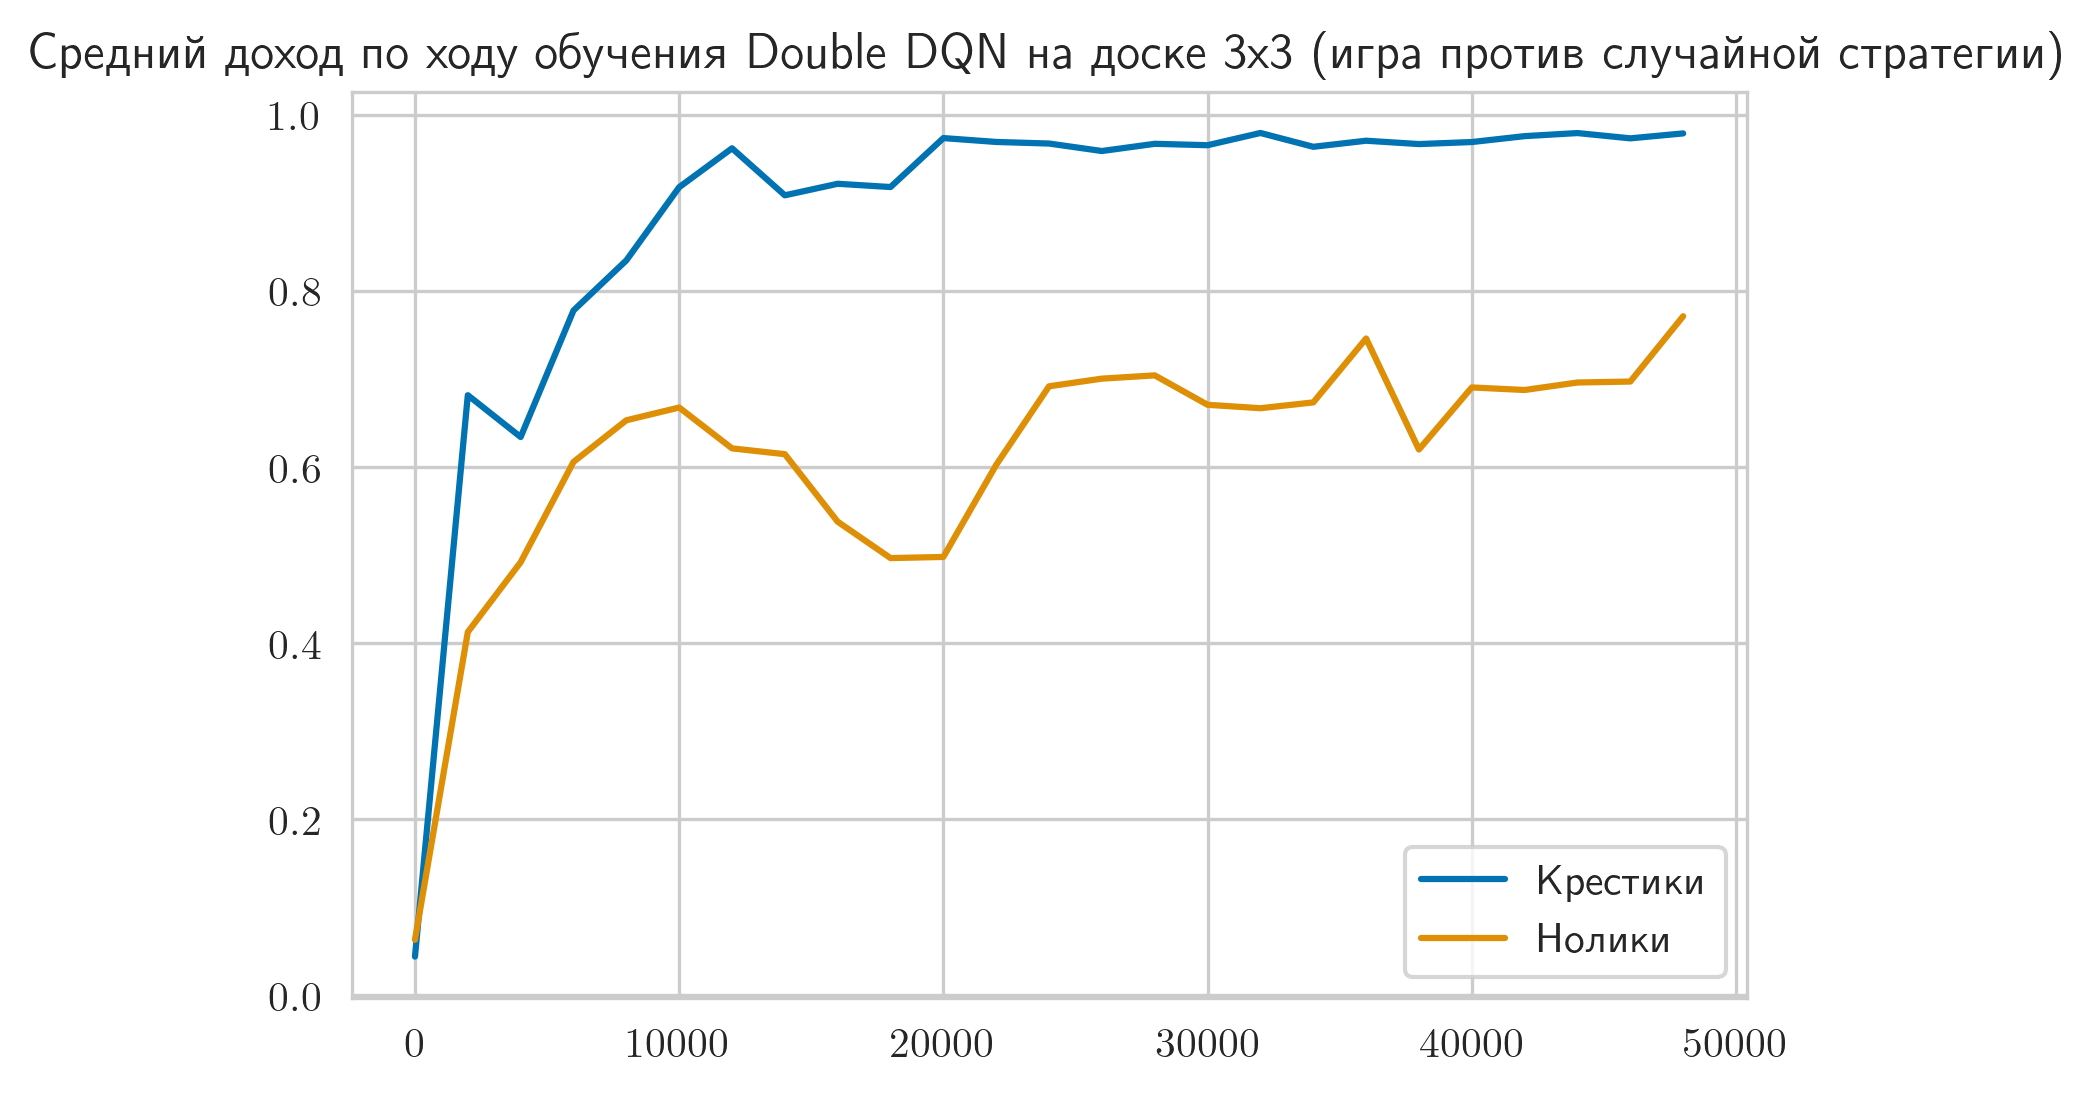

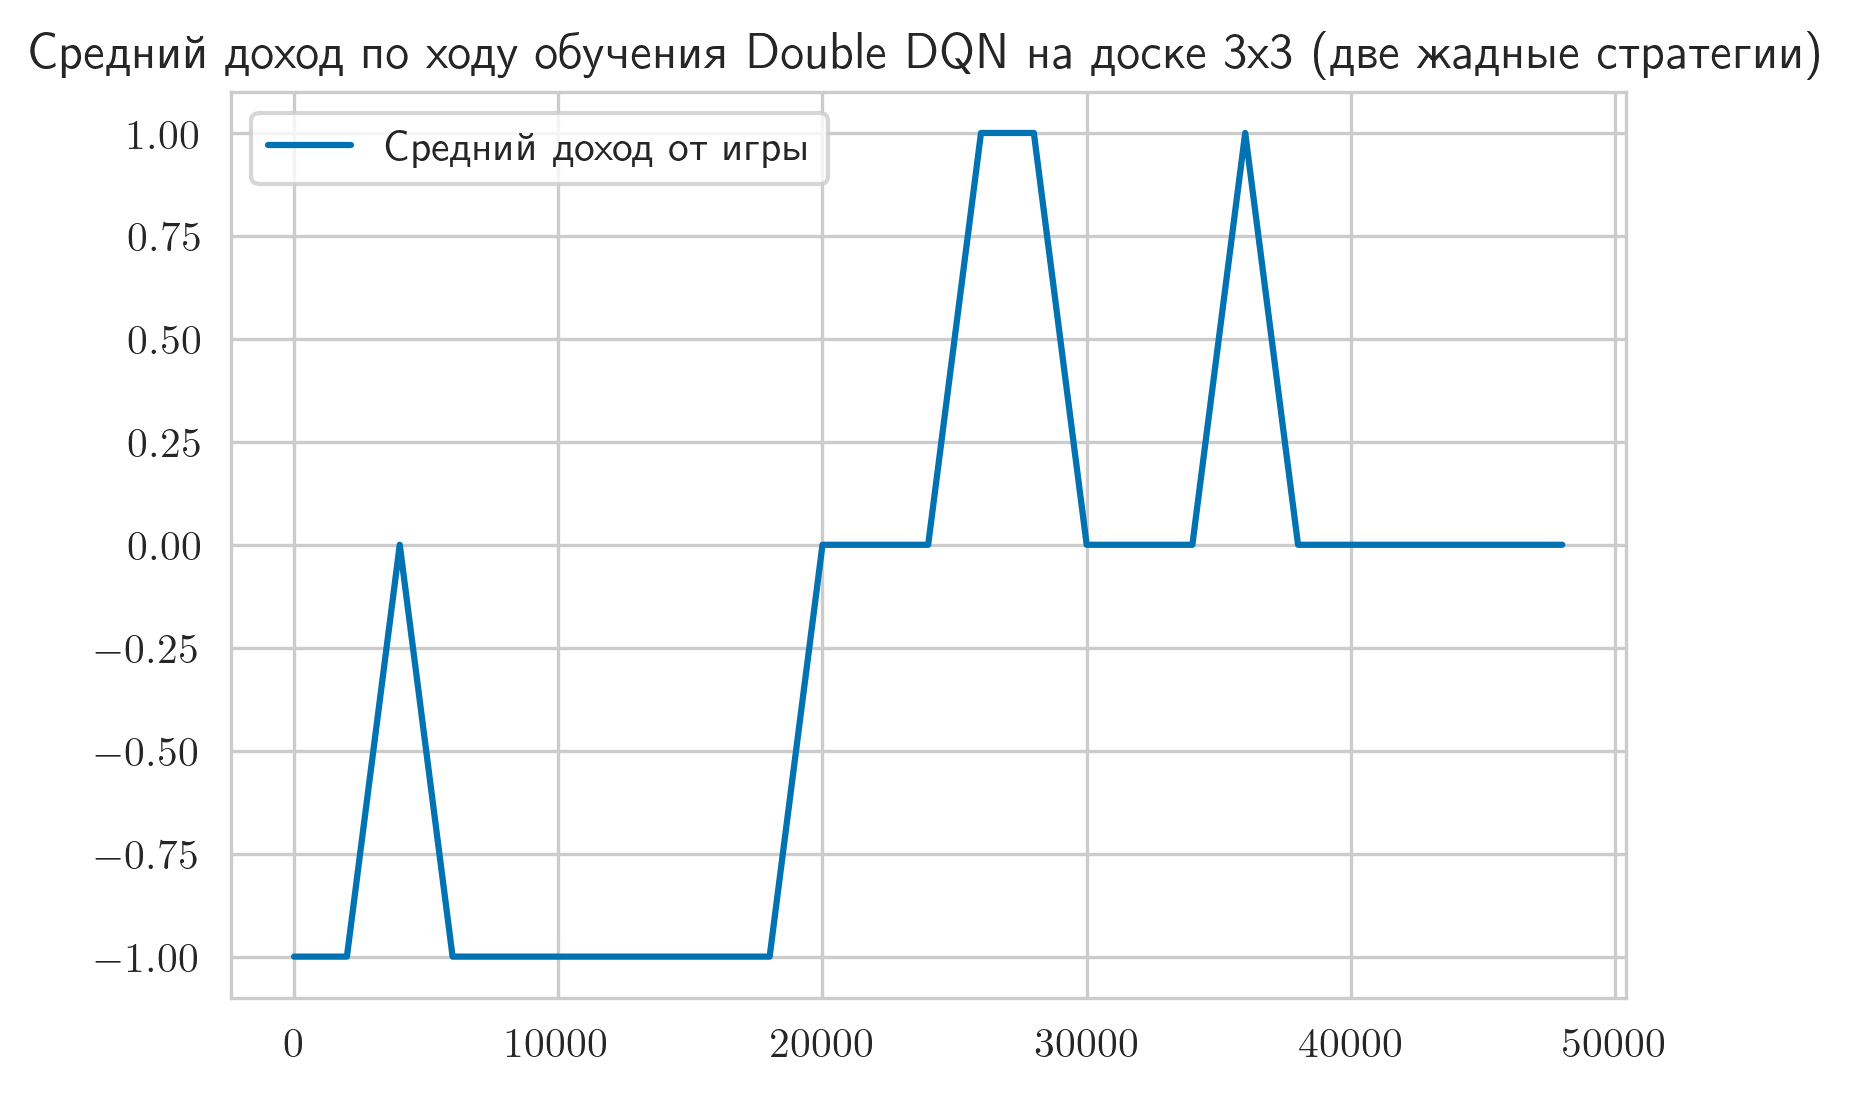

In [87]:
plot_nn_learning_double(double_dqn33, n_episodes=50000, score_every=2000, algo='Double DQN')

#### Double DQN $4x4$

In [105]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
double_dqn44 = TicTacToeDoubleDQN(4, 4, 4, batch_size=512, eps_generator=eps_constant(0.85))

Score at 1 / 100000 = -0.1658/0.0114/0.0
Score at 4001 / 100000 = 0.558/0.4742/-1.0
Score at 8001 / 100000 = 0.6702/0.6275/1.0
Score at 12001 / 100000 = 0.7866/0.3275/-1.0
Score at 16001 / 100000 = 0.7263/0.6075/1.0



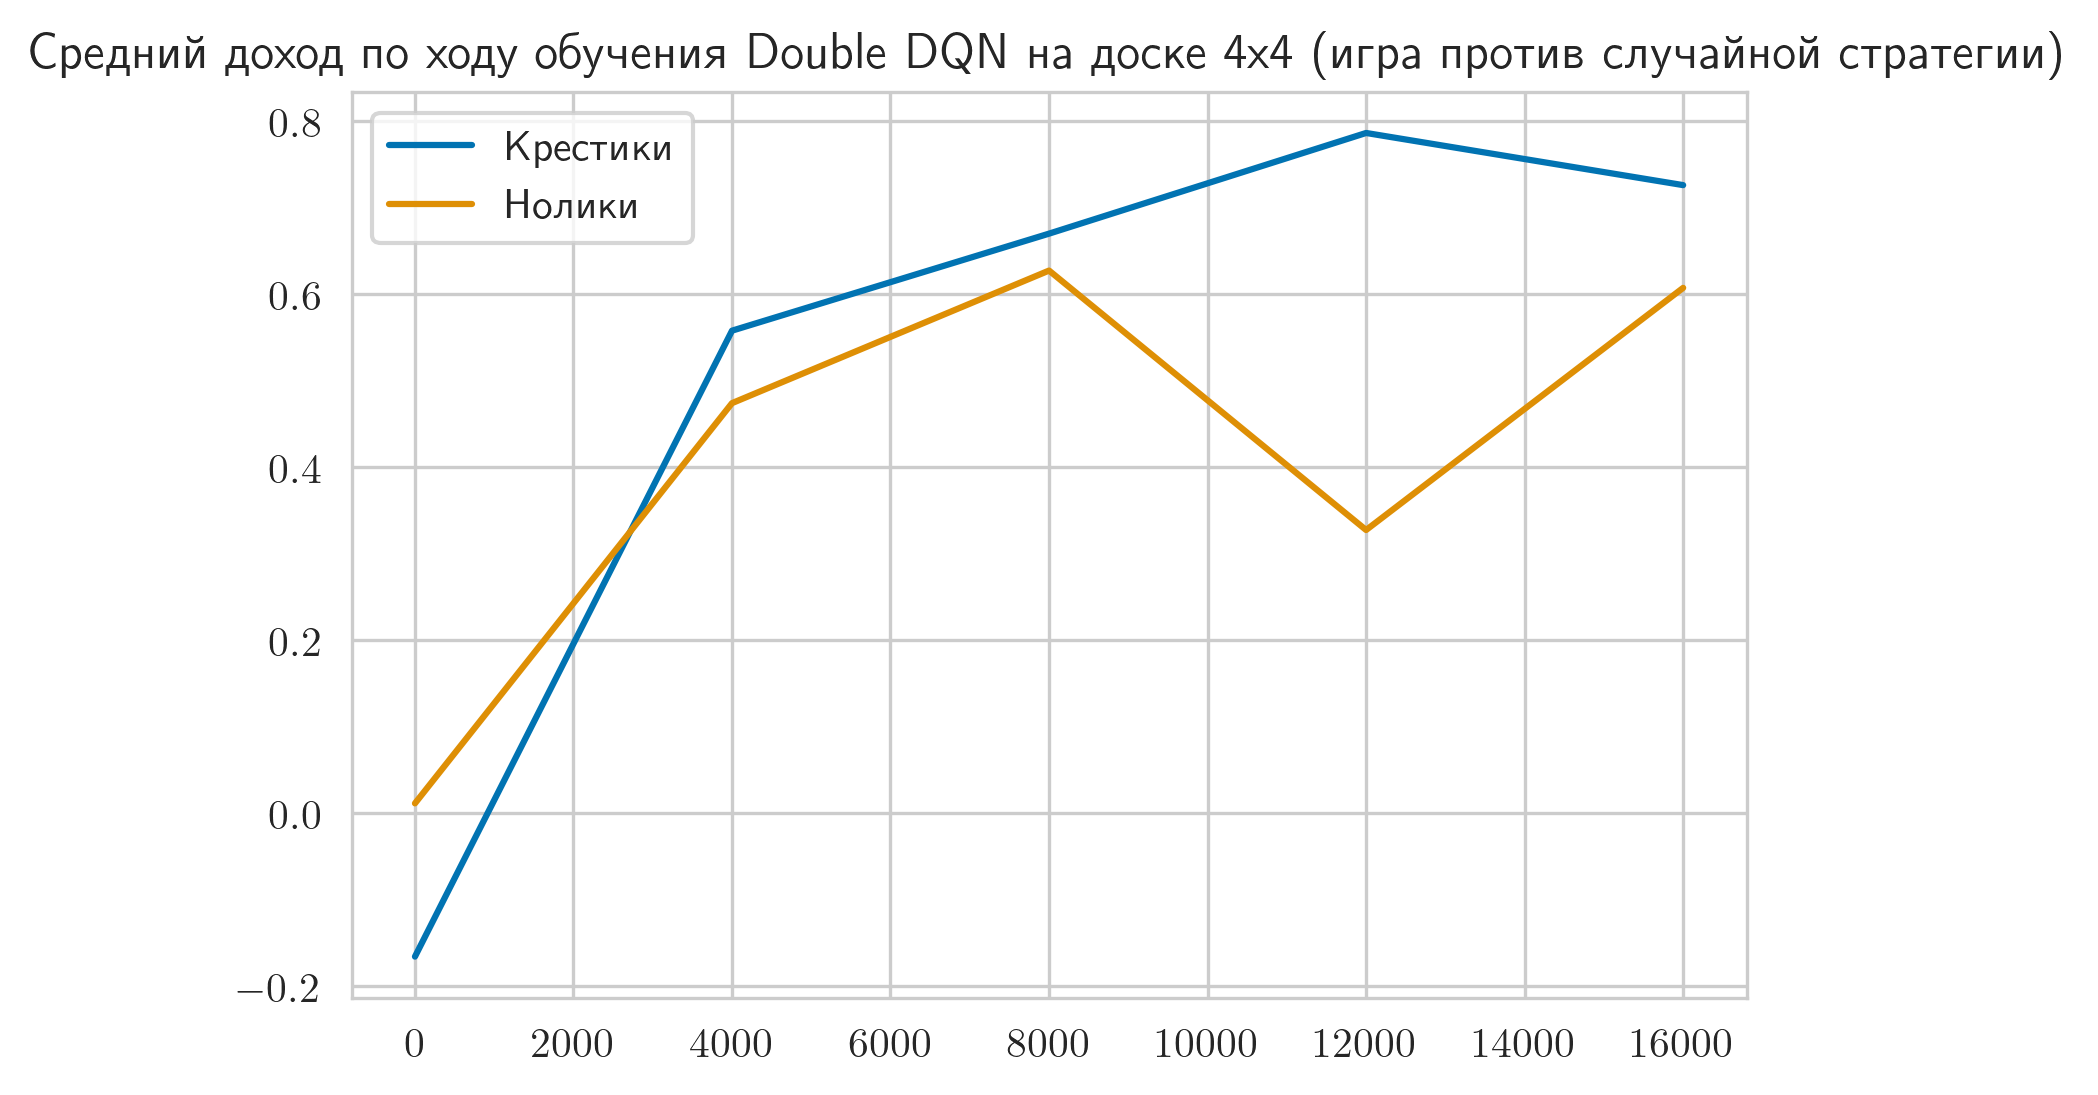

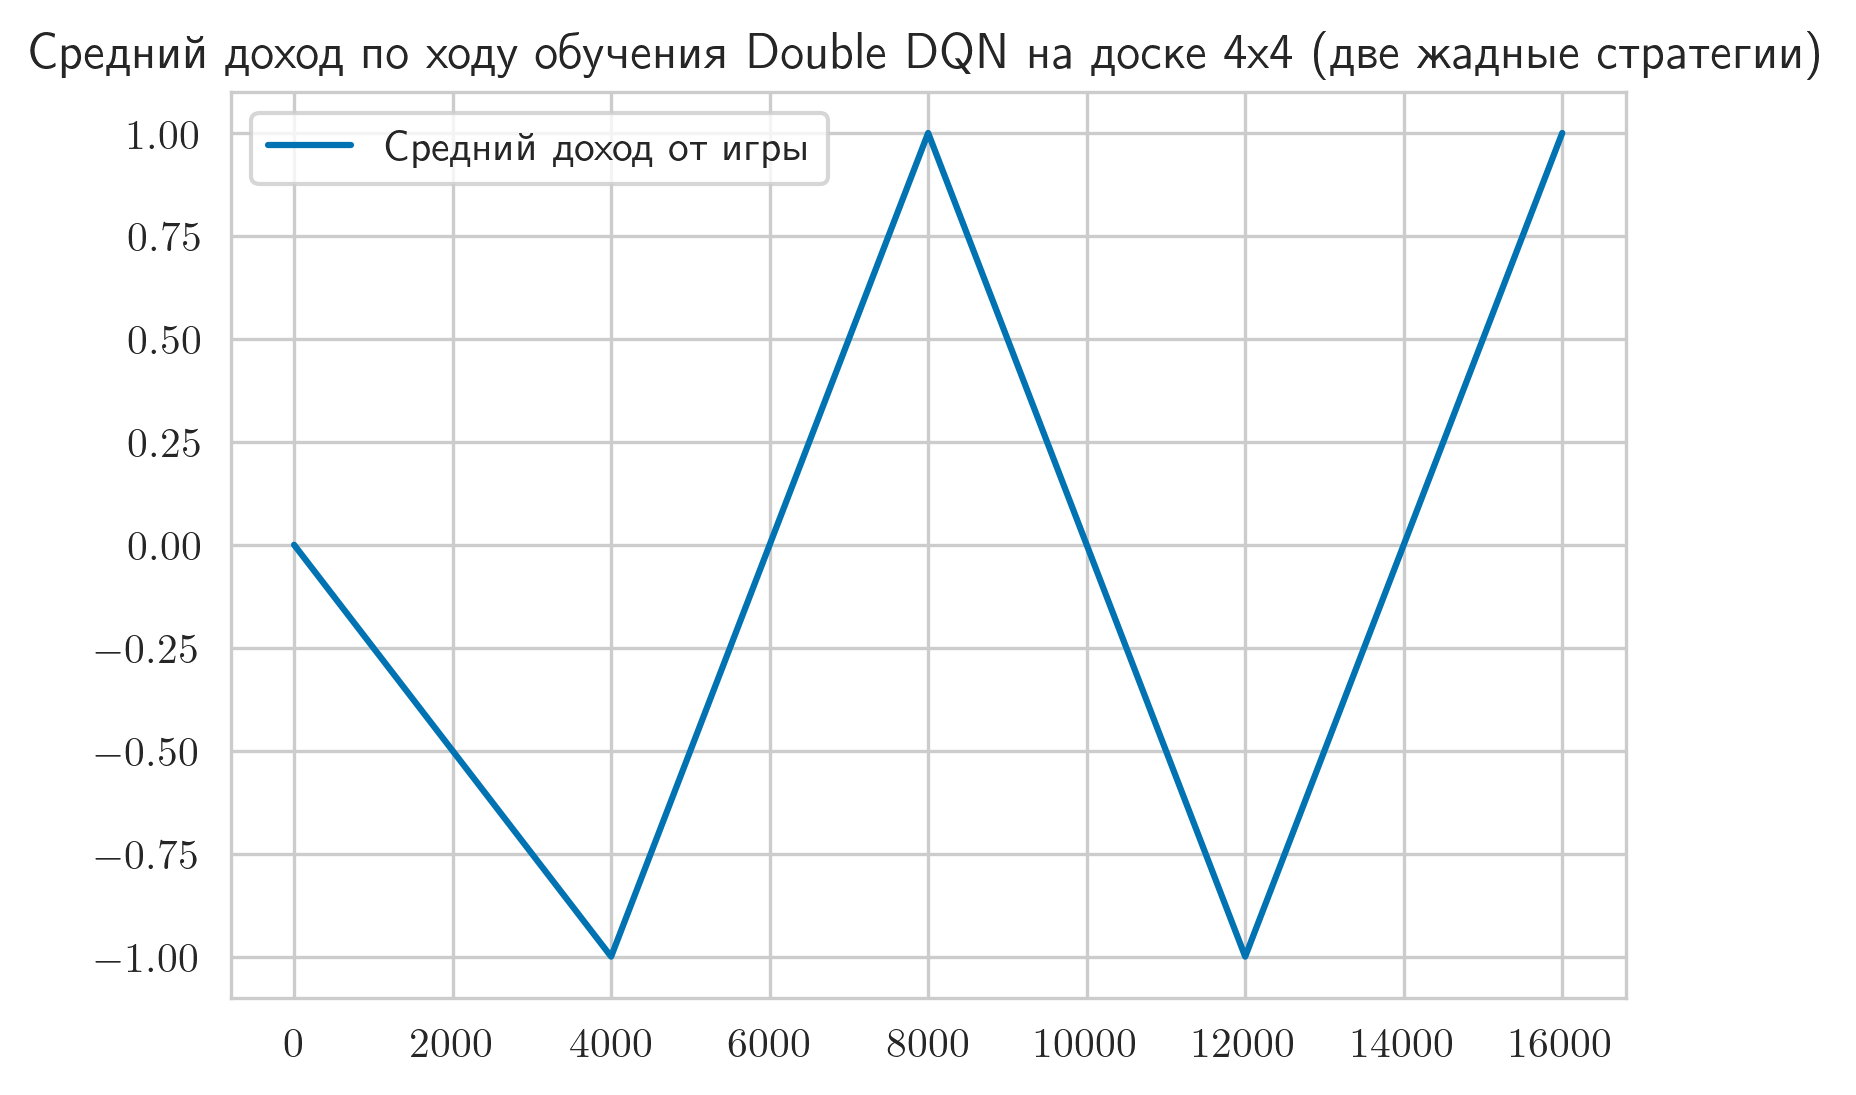

In [106]:
plot_nn_learning_double(double_dqn44, n_episodes=100000, score_every=4000, algo='Double DQN')

#### Double DQN $5x5$

In [110]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
double_dqn55 = TicTacToeDoubleDQN(5, 5, 5, batch_size=512, eps_generator=eps_constant(0.85))

Score at 1 / 100000 = 0.1875/-0.1758/1.0
Score at 1001 / 100000 = 0.6055/0.2357/1.0
Score at 2001 / 100000 = 0.6039/0.2732/1.0
Score at 3001 / 100000 = 0.6057/0.2703/1.0
Score at 4001 / 100000 = 0.6001/0.2838/1.0
Score at 5001 / 100000 = 0.6108/0.2685/1.0
Score at 6001 / 100000 = 0.6015/0.2927/1.0
Score at 7001 / 100000 = 0.6005/0.294/1.0
Score at 8001 / 100000 = 0.6093/0.2958/1.0



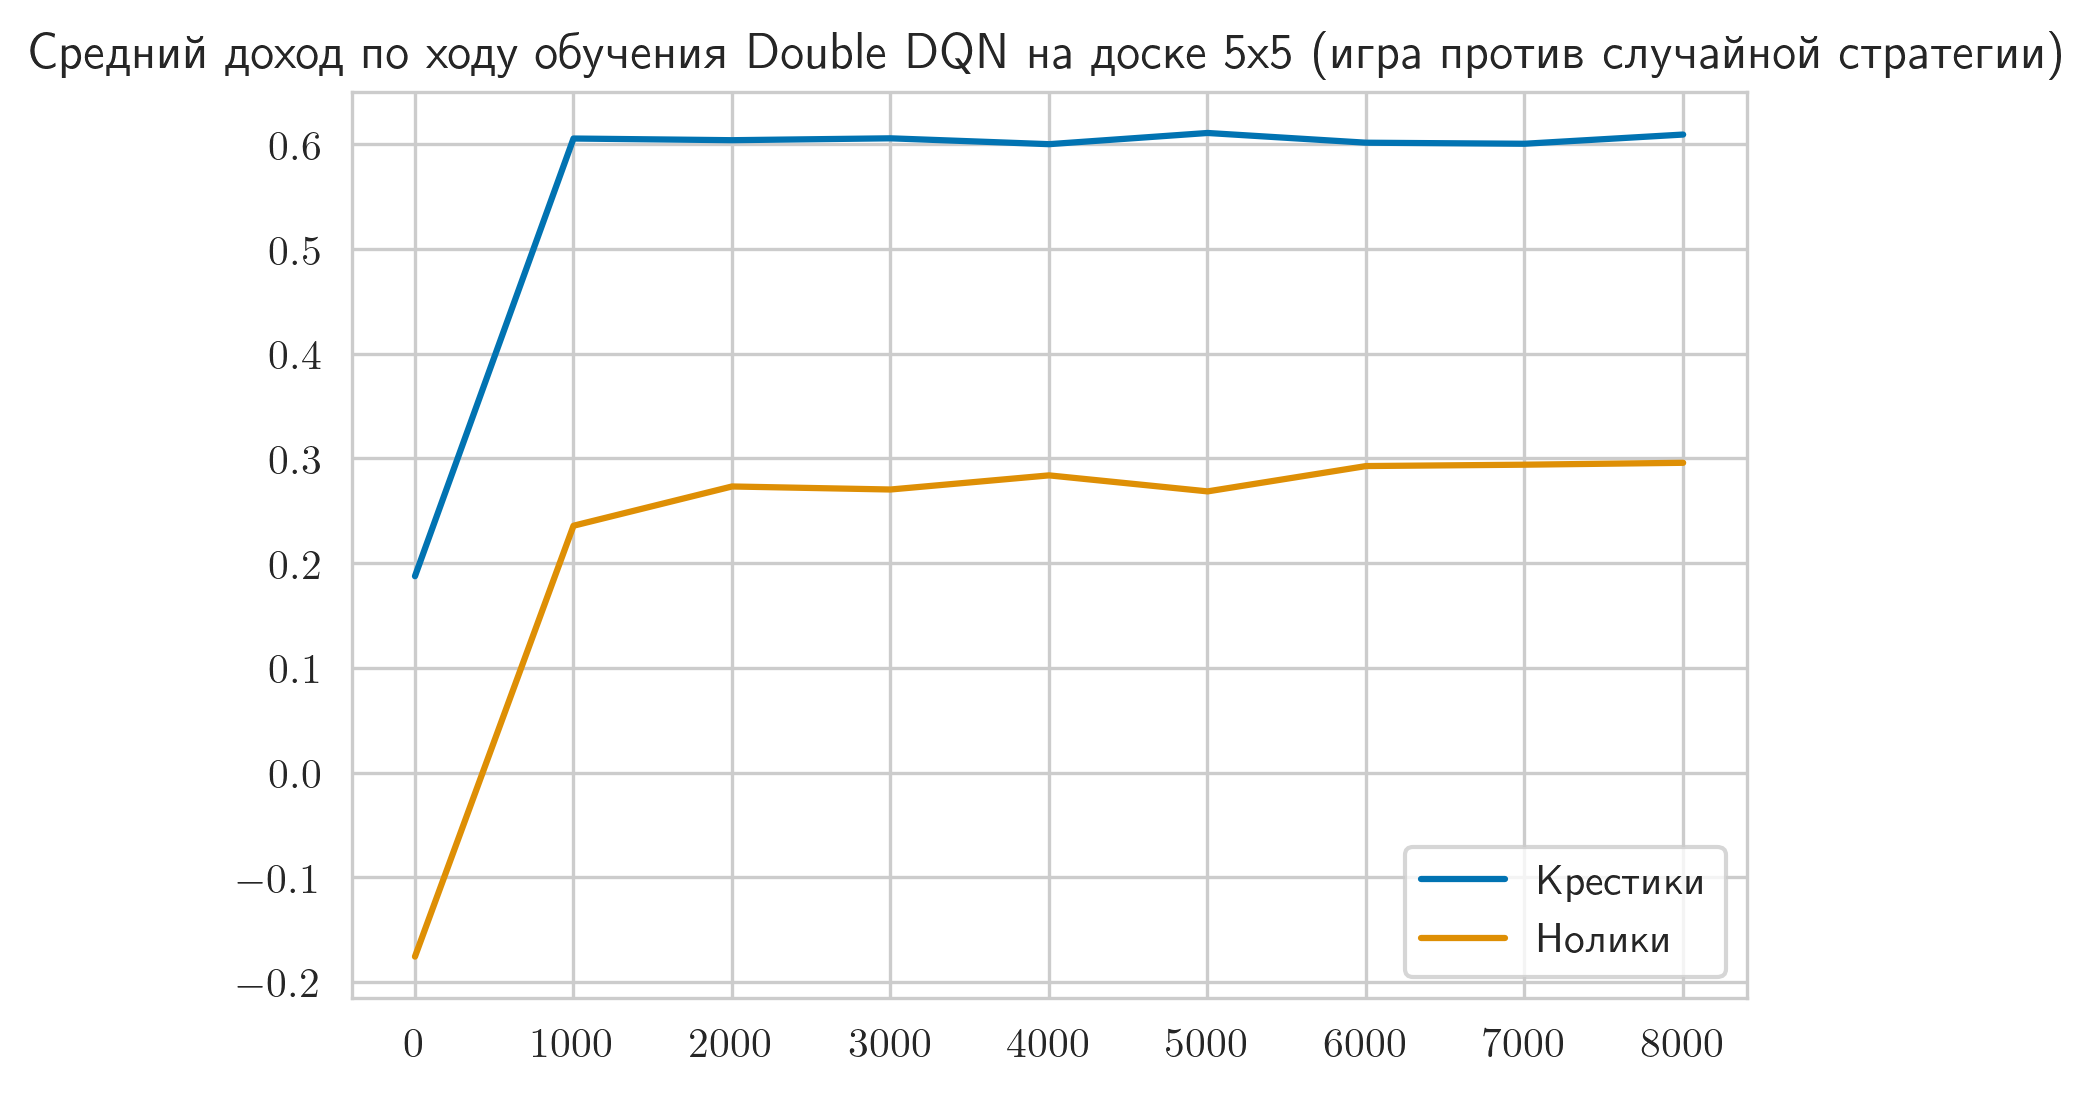

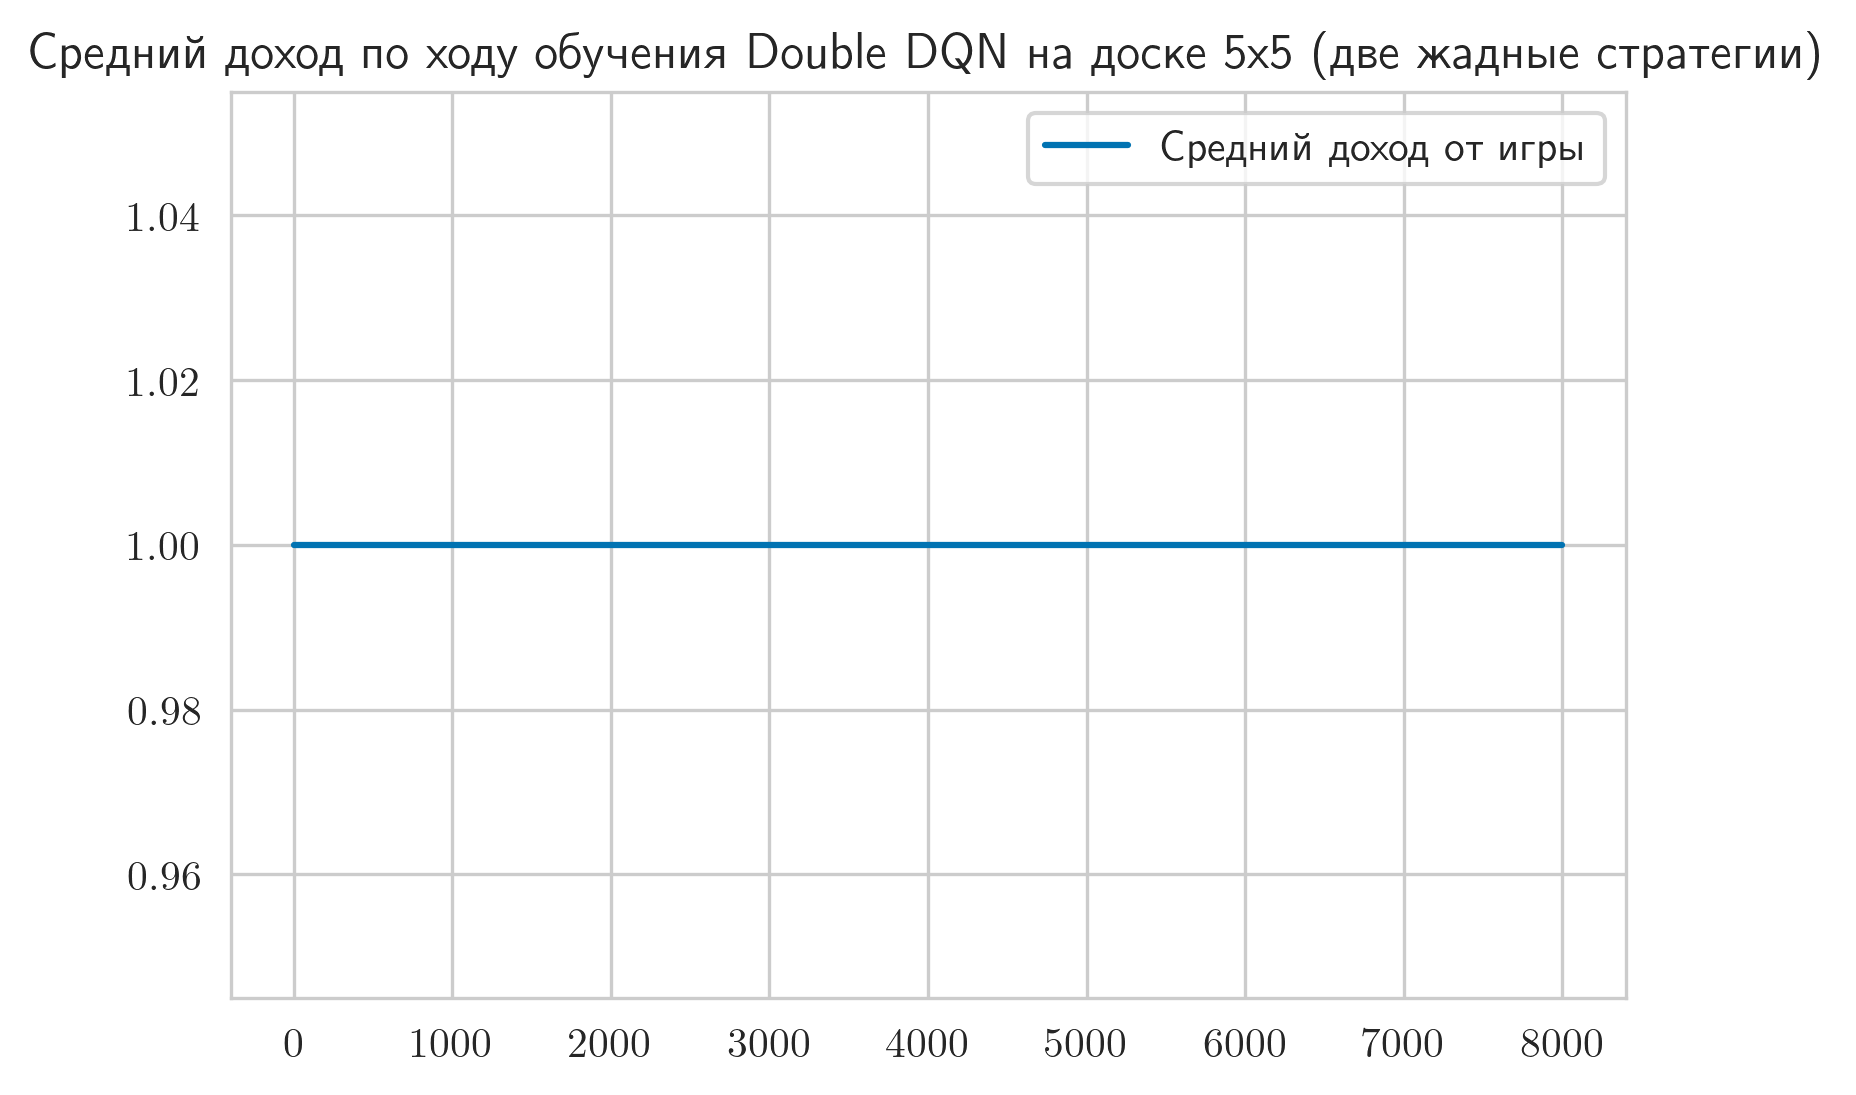

In [111]:
plot_nn_learning_double(double_dqn55, n_episodes=100000, score_every=1000, algo='Double DQN')

#### Double Dueling DQN $3x3$

In [120]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
double_dueling_dqn33 = TicTacToeDoubleDuelingDQN(3, 3, 3, batch_size=512, eps_generator=eps_constant(0.85))

Score at 1 / 50000 = 0.0472/-0.3675/1.0
Score at 2001 / 50000 = 0.9127/0.4251/0.0
Score at 4001 / 50000 = 0.9213/0.5242/1.0
Score at 6001 / 50000 = 0.918/0.6368/-1.0
Score at 8001 / 50000 = 0.9294/0.4706/-1.0
Score at 10001 / 50000 = 0.928/0.361/-1.0
Score at 12001 / 50000 = 0.9272/0.4566/-1.0
Score at 14001 / 50000 = 0.9404/0.4411/-1.0
Score at 16001 / 50000 = 0.9391/0.4972/1.0
Score at 18001 / 50000 = 0.9297/0.5176/-1.0
Score at 20001 / 50000 = 0.9565/0.4919/1.0
Score at 22001 / 50000 = 0.949/0.5057/1.0
Score at 24001 / 50000 = 0.9539/0.5055/1.0
Score at 26001 / 50000 = 0.9506/0.5776/1.0
Score at 28001 / 50000 = 0.9165/0.5473/1.0
Score at 30001 / 50000 = 0.9642/0.5958/1.0
Score at 32001 / 50000 = 0.96/0.5565/1.0
Score at 34001 / 50000 = 0.9668/0.5981/1.0
Score at 36001 / 50000 = 0.9344/0.635/-1.0
Score at 38001 / 50000 = 0.9669/0.6127/0.0
Score at 40001 / 50000 = 0.9488/0.6438/-1.0
Score at 42001 / 50000 = 0.9319/0.6961/-1.0
Score at 44001 / 50000 = 0.9678/0.6633/1.0
Score at 46001 /

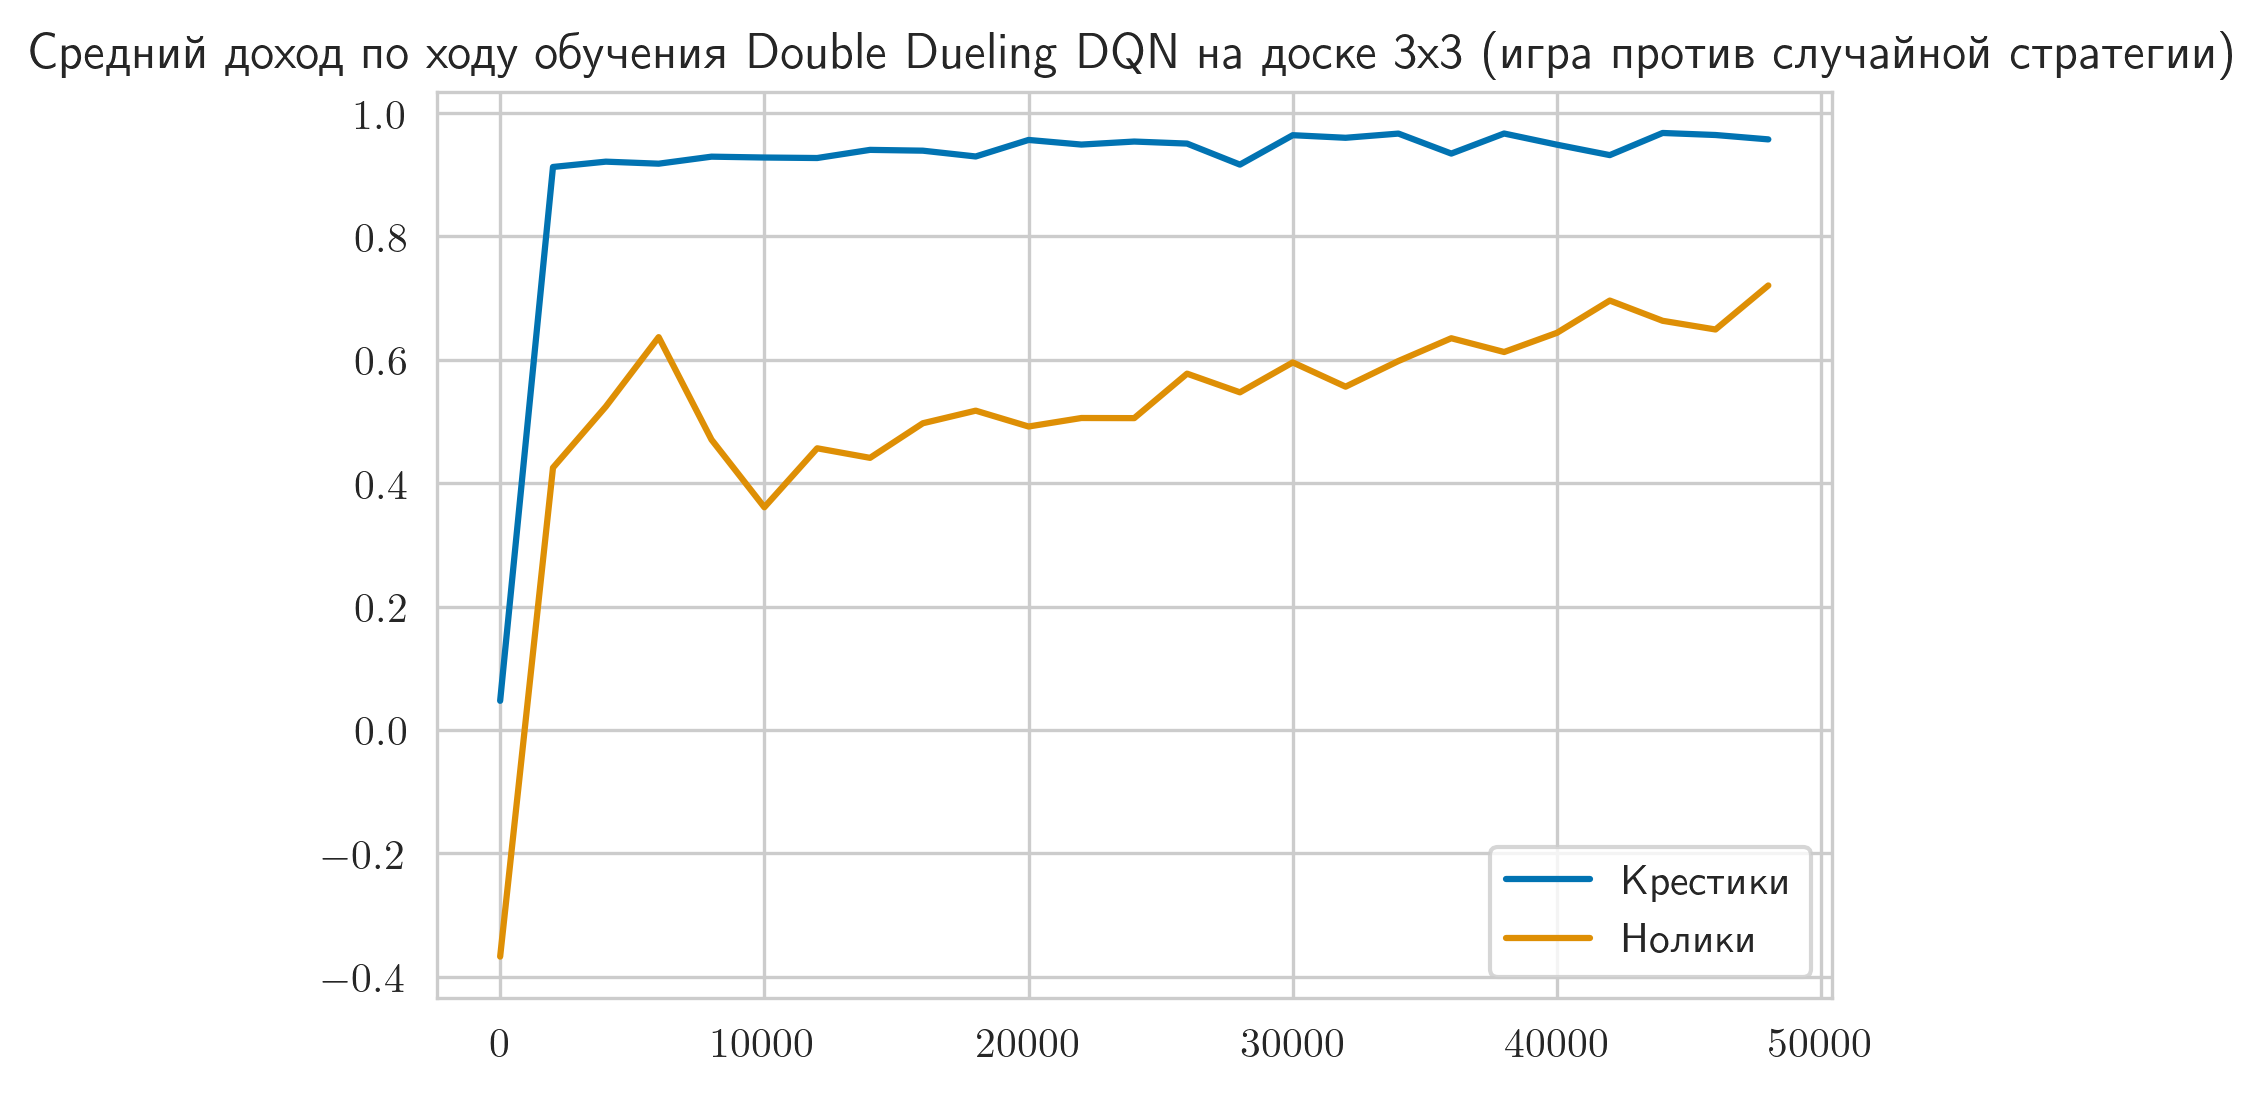

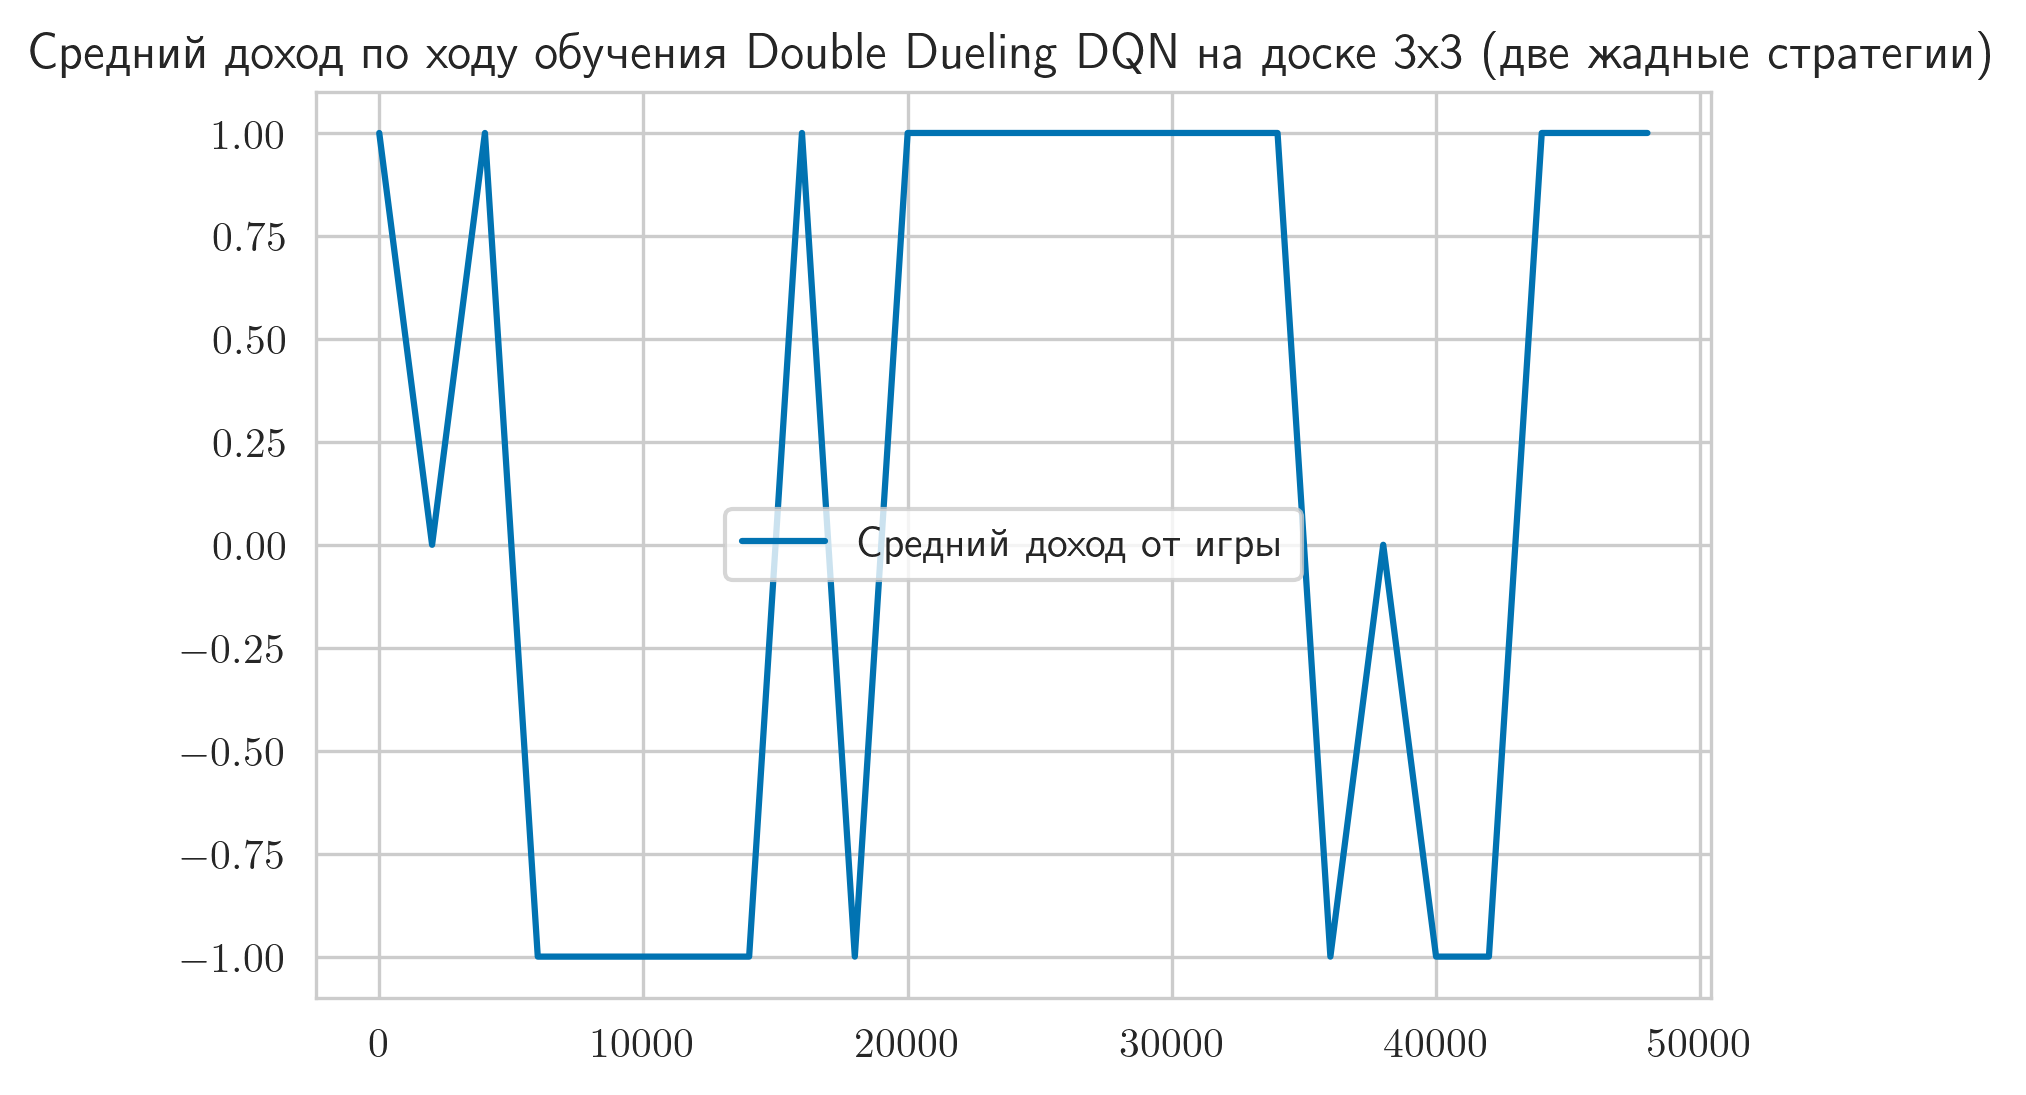

In [121]:
plot_nn_learning_double(double_dueling_dqn33, n_episodes=50000, score_every=2000, algo='Double Dueling DQN')

#### Double Dueling $4x4$

In [122]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
double_dueling_dqn44 = TicTacToeDoubleDuelingDQN(4, 4, 4, batch_size=512, eps_generator=eps_constant(0.85))

Score at 1 / 100000 = 0.0796/0.0772/0.0
Score at 4001 / 100000 = 0.4235/0.0737/0.0
Score at 8001 / 100000 = 0.6402/0.2618/1.0
Score at 12001 / 100000 = 0.5514/0.4061/-1.0
Score at 16001 / 100000 = 0.709/0.4977/1.0
Score at 20001 / 100000 = 0.67/0.4541/-1.0



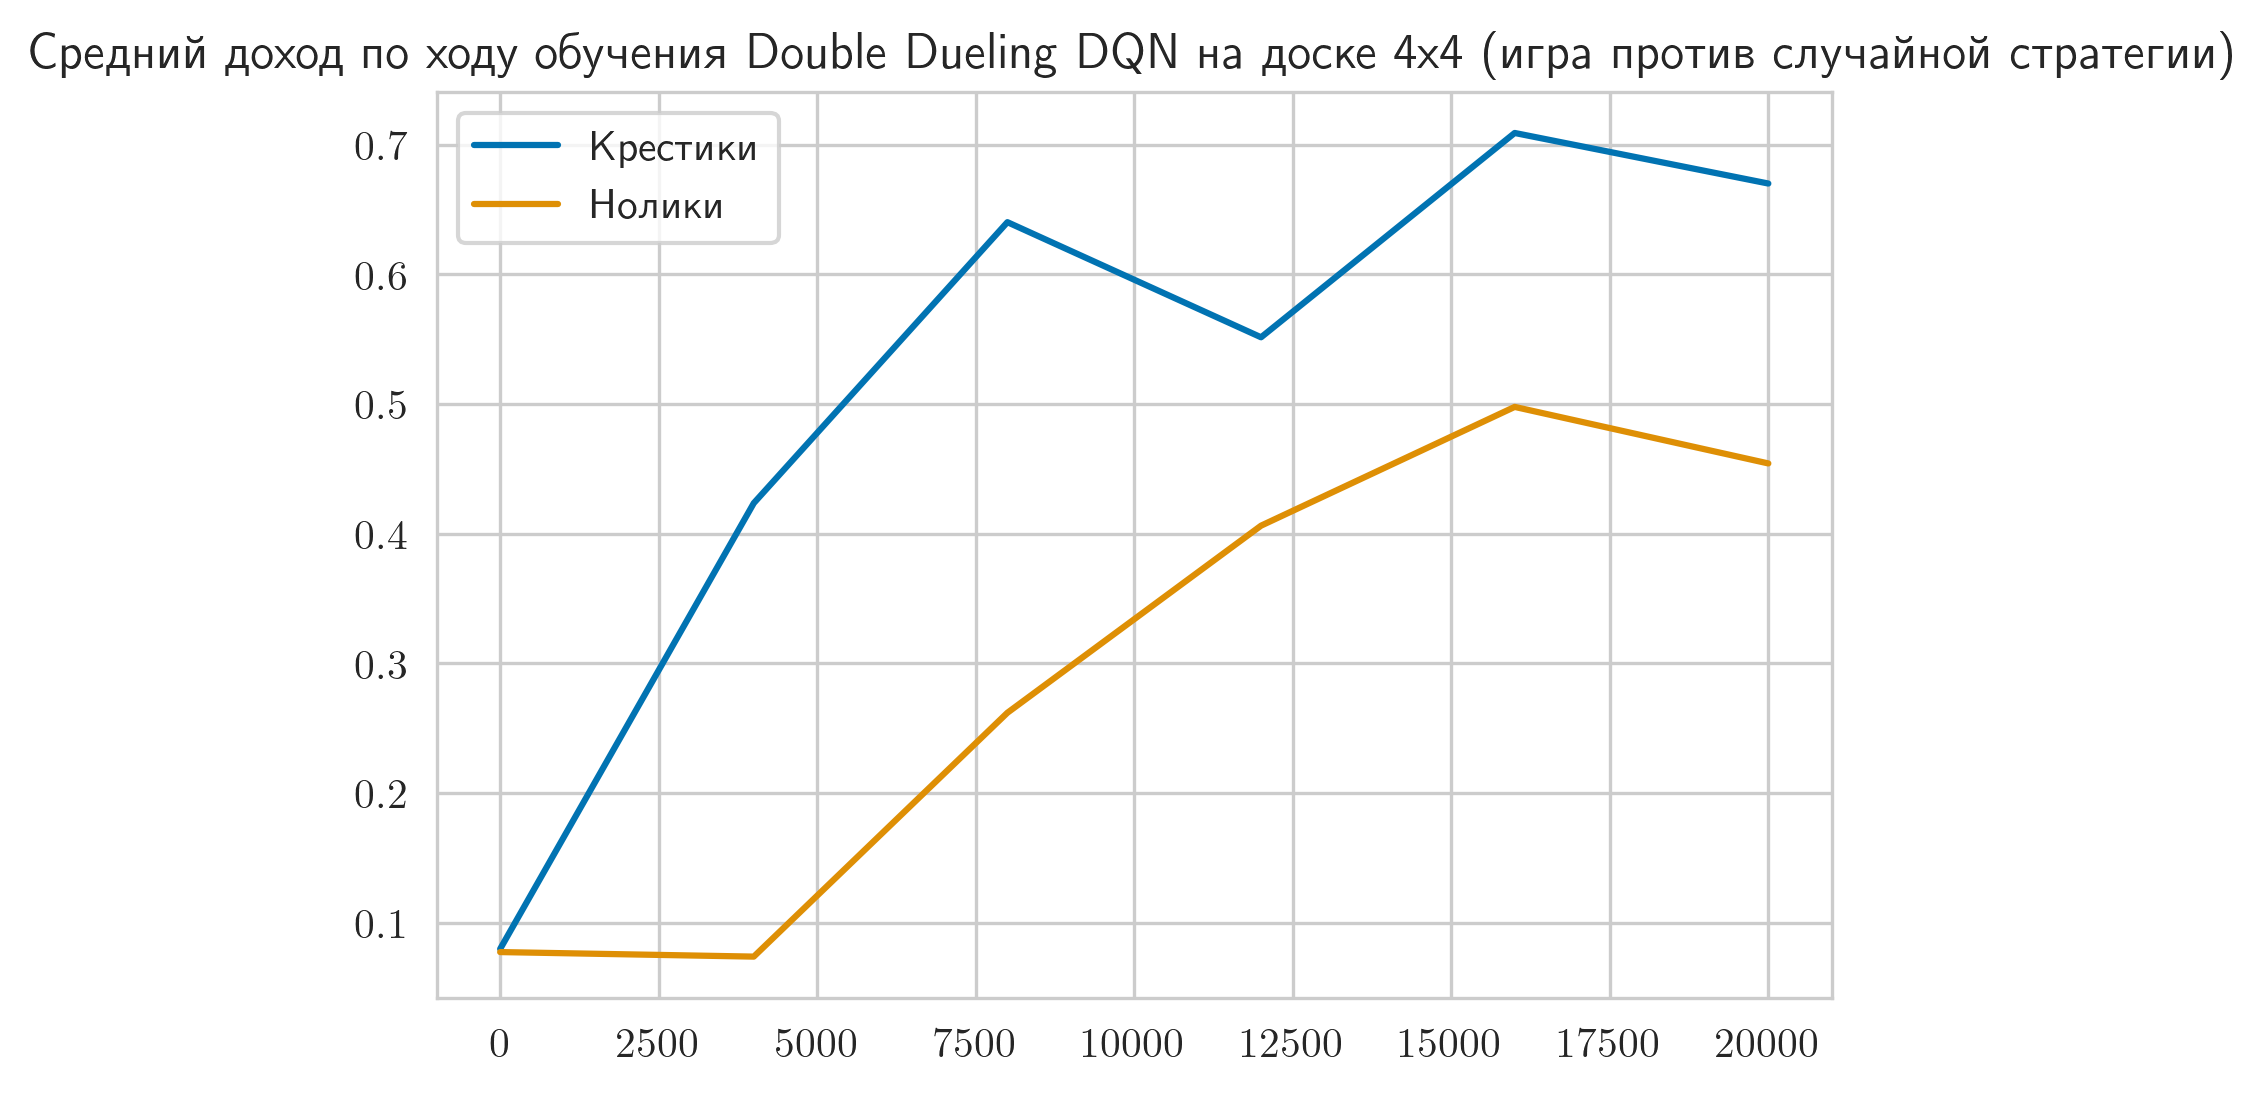

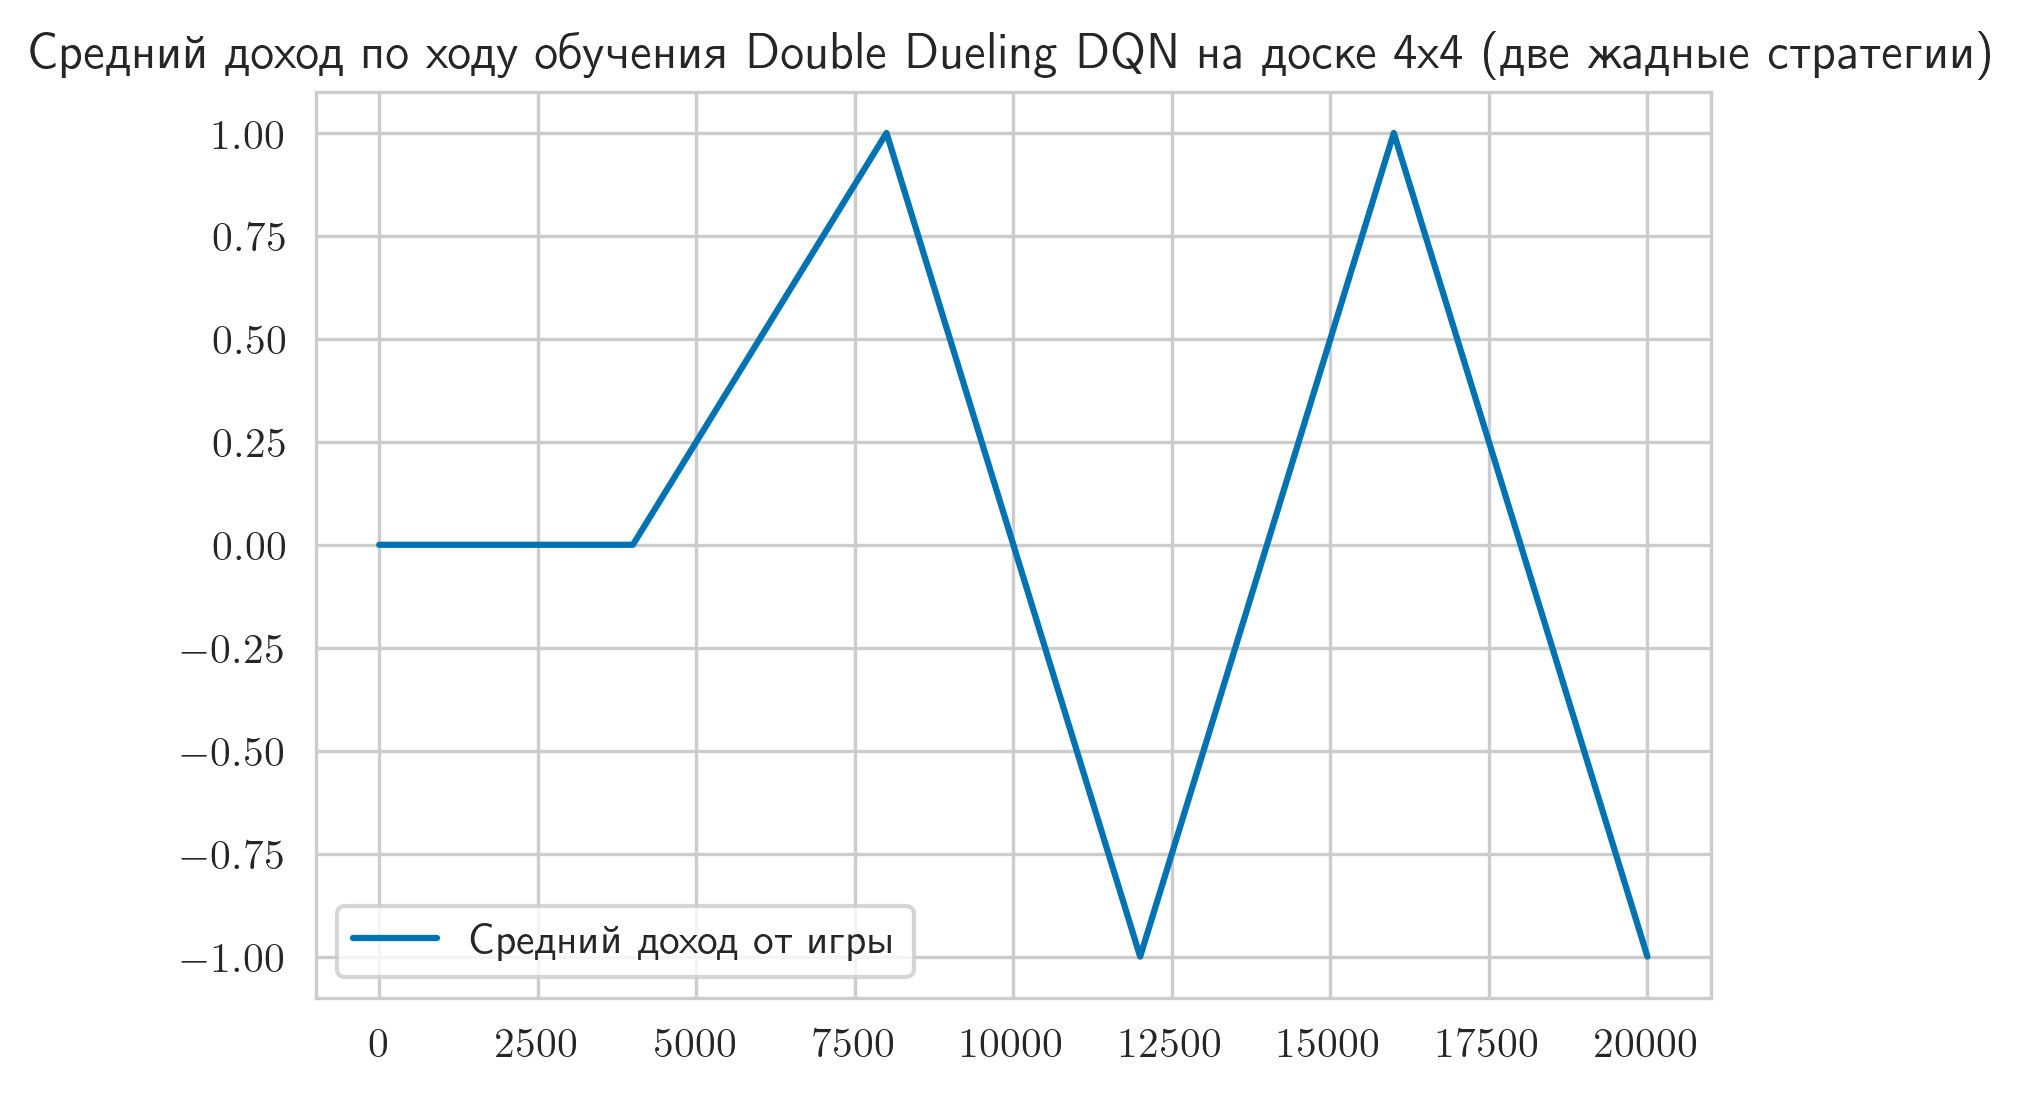

In [123]:
plot_nn_learning_double(double_dueling_dqn44, n_episodes=100000, score_every=4000, algo='Double Dueling DQN')

#### Double Dueling $5x5$

In [124]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
double_dueling_dqn55 = TicTacToeDoubleDuelingDQN(5, 5, 5, batch_size=512, eps_generator=eps_constant(0.85))

Score at 1 / 50000 = 0.2338/-0.1212/-1.0
Score at 2001 / 50000 = 0.0285/-0.0223/0.0
Score at 4001 / 50000 = 0.2603/0.3843/0.0
Score at 6001 / 50000 = 0.236/-0.1129/0.0
Score at 8001 / 50000 = 0.4651/0.2436/0.0



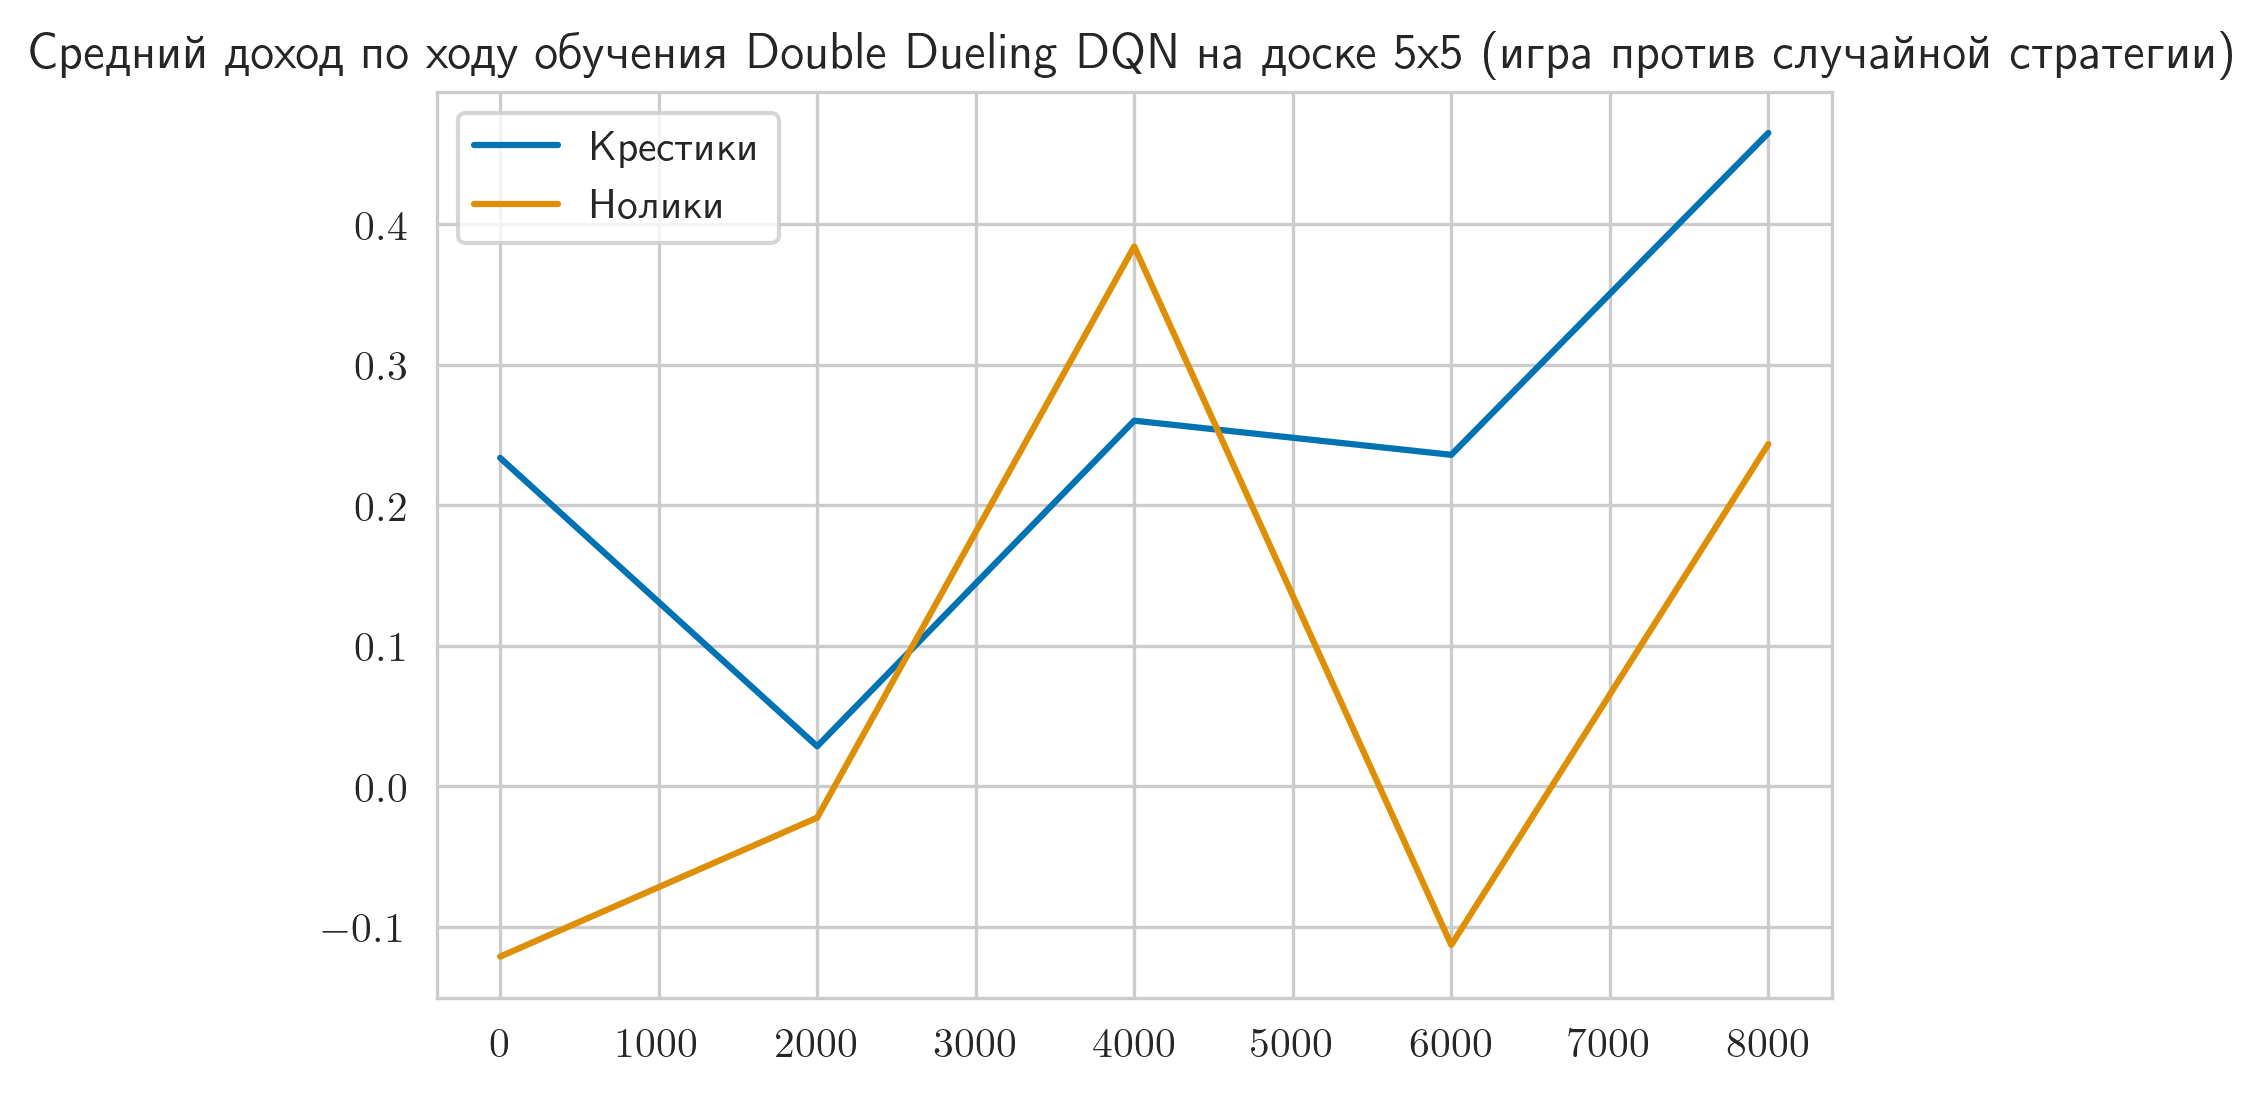

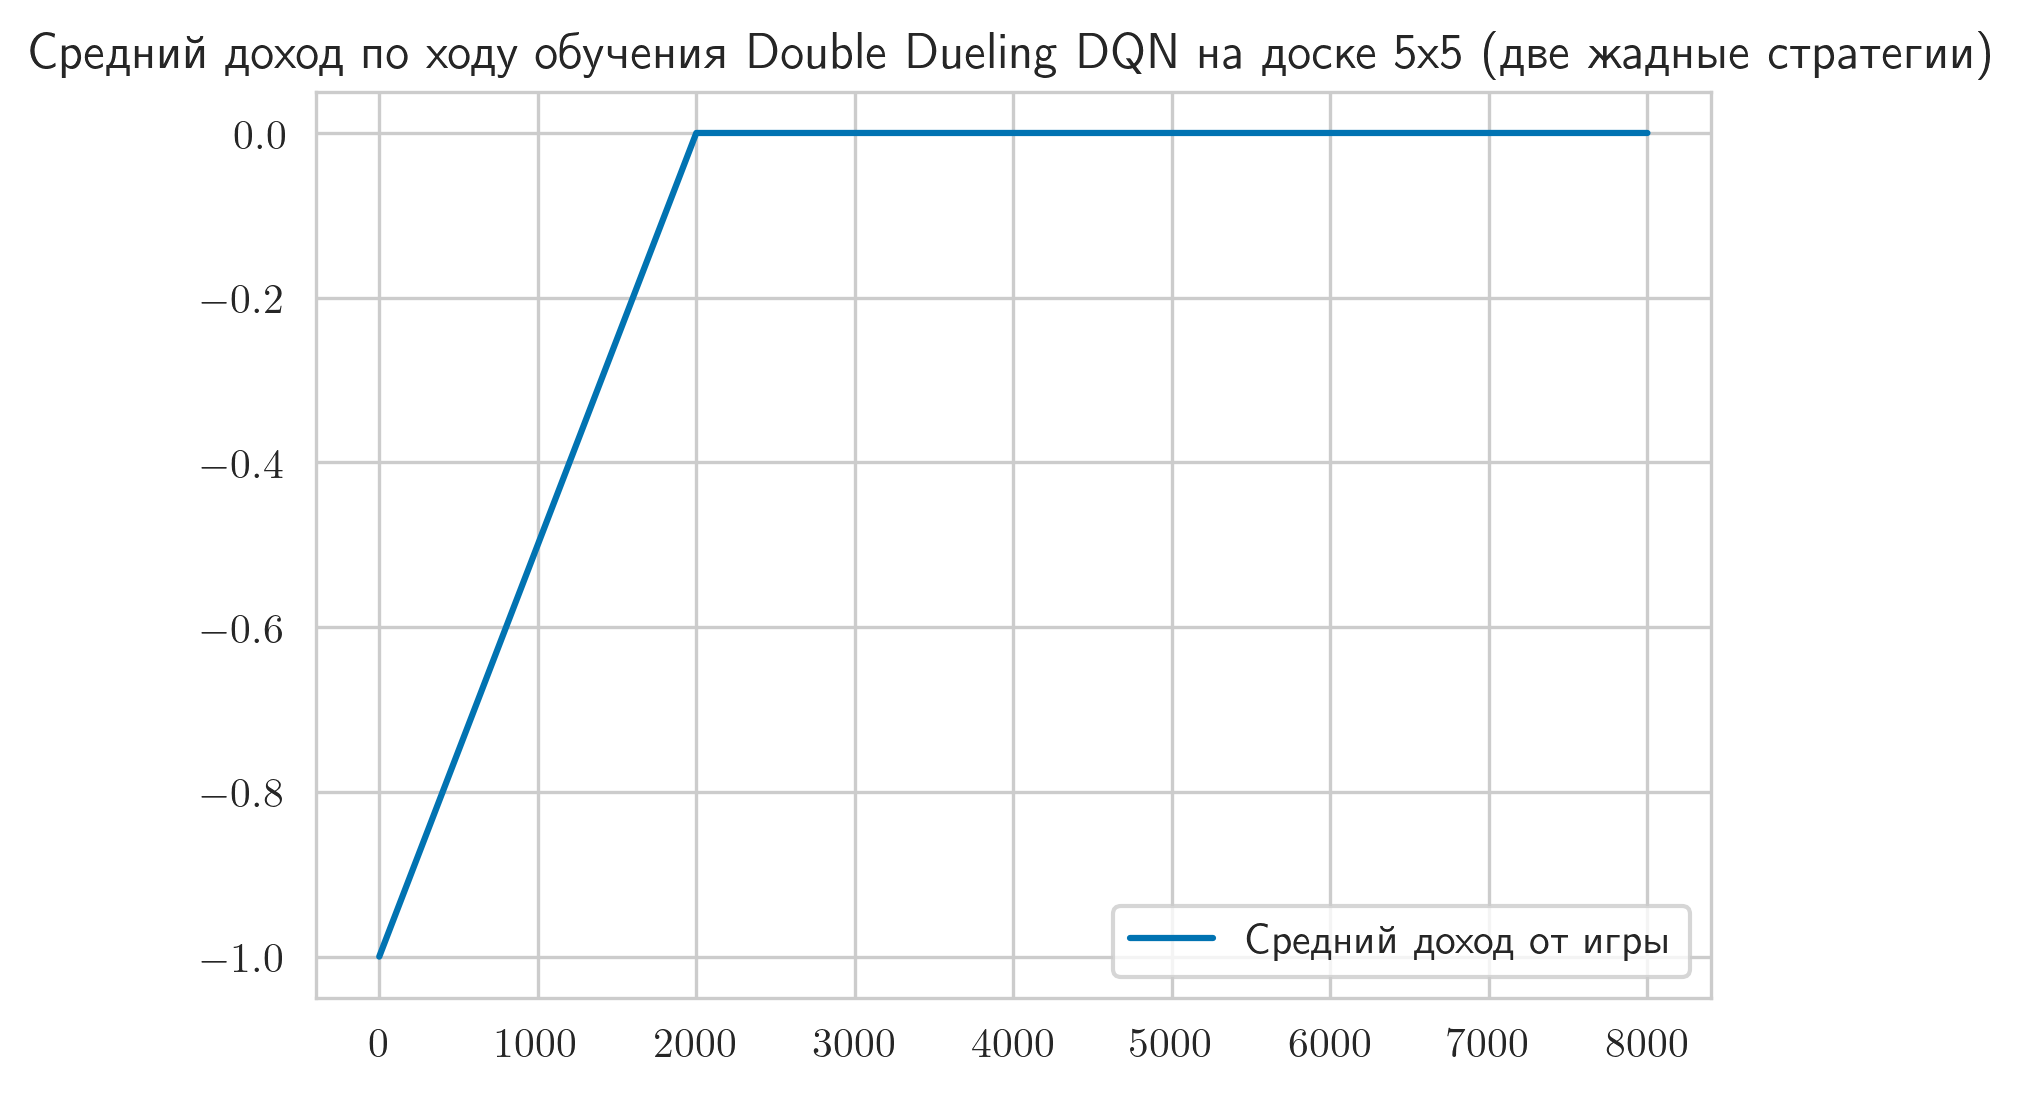

In [125]:
plot_nn_learning_double(double_dueling_dqn55, n_episodes=50000, score_every=2000, algo='Double Dueling DQN')

## Часть третья: расширим и углубим поиск

Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.

### 5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

In [362]:
def single_rollout(env, policy_crosses=policy_random(), policy_naughts=policy_random(), crosses=True):
    # Осуществляем полное копирование среды для моделирования
    env_copy = deepcopy(env)
    
    # Запакуем политики в список
    policies = [policy_naughts, policy_crosses]
    
    # Промоделиуем дальнейшие действия
    reward = 0
    while True:
        _, reward, done, _ = env_copy.step_int(policies[int(env_copy.curTurn > 0)](env_copy))
        if done == True:
            break
            
    # Вернем награду со знаком запрашиваемого игрока
    if crosses == True:
        return reward
    else:
        return -reward

In [377]:
def policy_rollout(policy_crosses=policy_random(), policy_naughts=policy_random(), n_rollouts=10, crosses=True):
    def strategy(env):
        # Сохраняем статистику здесь
        statistics = defaultdict(list)
        
        # Если нам доступно одно действие, то возвращаем его и не делаем rollout
        if len(env.getEmptyInts()) == 1:
            return env.getEmptyInts()[0]
        
        # Итерируемся по всем возможным действиям в этом состоянии
        for action in env.getEmptyInts():
            # Проводим несколько экспериментов и накапливаем статистику
            for i in range(n_rollouts):
                # Осуществляем копирование окружения
                env_copy = deepcopy(env)

                # Осуществляем действие
                env_copy.step_int(action)
                
                # Обновляем статистику
                statistics[action].append(single_rollout(env_copy, policy_crosses=policy_crosses, policy_naughts=policy_naughts, crosses=crosses))
                
        # Выберем действия с максимальной наградой
        max_actions, max_reward = [], -np.inf
        for k, v in statistics.items():
            # Подсчитаем текущее качество
            reward = np.mean(v)
            
            # Найдем несколько максимумумов
            if np.allclose(reward, max_reward, rtol=0.0, atol=1e-5):
                max_actions.append(k)
            elif reward > max_reward:
                max_reward = reward
                max_actions = [k]
                
        # Вернем случайное действие с максимальной наградой
        return random.choice(max_actions)
        
    return strategy

#### Rollout'ы $3x3$

Достанем политики из Q-learning

In [393]:
q33_policy_crosses = policy_q(Q_c_33)
q33_policy_naughts = policy_q(Q_n_33)

Достанем политики из DQN

In [394]:
dqn33_policy_crosses = policy_nn(dqn33.model_crosses)
dqn33_policy_naughts = policy_nn(dqn33.model_naughts)

Обернем наши политики 

In [400]:
dqn33_policy_crosses_rollout_vs_random = policy_rollout(policy_crosses=dqn33_crosses_policy, policy_naughts=policy_random(), crosses=True)
dqn33_policy_naughts_rollout_vs_random = policy_rollout(policy_crosses=policy_random(), policy_naughts=dqn33_policy_naughts, crosses=False)

dqn33_policy_crosses_rollout_vs_q = policy_rollout(policy_crosses=dqn33_crosses_policy, policy_naughts=q33_policy_naughts, crosses=True)
dqn33_policy_naughts_rollout_vs_q = policy_rollout(policy_crosses=q33_policy_crosses, policy_naughts=dqn33_policy_naughts, crosses=False)

dqn33_policy_crosses_rollout = policy_rollout(policy_crosses=dqn33_crosses_policy, policy_naughts=q33_policy_naughts, crosses=True)
dqn33_policy_naughts_rollout = policy_rollout(policy_crosses=q33_policy_crosses, policy_naughts=dqn33_policy_naughts, crosses=False)

Сравним, какой прирост даст игра по политике крестиков с rollout'ами по сравнению с игрой без rollout'ов

In [399]:
%%time
calculate_reward_by_policies(dqn33_policy_crosses, dqn33_policy_naughts, env=TicTacToe(3, 3, 3), num_experiments=100)[0]

CPU times: user 1.6 s, sys: 19.8 ms, total: 1.62 s
Wall time: 269 ms


0.0

In [402]:
%%time
calculate_reward_by_policies(dqn33_policy_crosses_rollout_vs_q, dqn33_policy_naughts, env=TicTacToe(3, 3, 3), num_experiments=100)[0]

CPU times: user 3min 12s, sys: 3.72 s, total: 3min 15s
Wall time: 32.7 s


0.14

Сравним, какой прирост даст игра по политике ноликов с rollout'ами по сравнению с игрой без rollout'ов

In [399]:
%%time
calculate_reward_by_policies(dqn33_policy_crosses, dqn33_policy_naughts, env=TicTacToe(3, 3, 3), num_experiments=100)[0]

CPU times: user 1.6 s, sys: 19.8 ms, total: 1.62 s
Wall time: 269 ms


0.0

In [406]:
%%time
calculate_reward_by_policies(dqn33_policy_crosses, dqn33_policy_naughts_rollout_vs_q, env=TicTacToe(3, 3, 3), num_experiments=1000)[0]

CPU times: user 18min 41s, sys: 21.8 s, total: 19min 2s
Wall time: 3min 10s


0.094

Сравним, какой прирост даст игра со случайными политиками и попытаками улучшить эти стратегии

In [494]:
%%time
calculate_reward_by_policies(
    policy_random(),
    policy_random(),
    env=TicTacToe(3, 3, 3),
    num_experiments=100
)[0]

CPU times: user 54.9 ms, sys: 3.37 ms, total: 58.3 ms
Wall time: 54 ms


0.32

In [496]:
%%time
calculate_reward_by_policies(
    policy_rollout(policy_random(), policy_random(), n_rollouts=10, crosses=True),
    policy_random(),
    env=TicTacToe(3, 3, 3),
    num_experiments=100
)[0]

CPU times: user 17.5 s, sys: 140 ms, total: 17.6 s
Wall time: 17.7 s


0.84

In [497]:
%%time
calculate_reward_by_policies(
    policy_random(),
    policy_rollout(policy_random(), policy_random(), n_rollouts=10, crosses=False),
    env=TicTacToe(3, 3, 3),
    num_experiments=100
)[0]

CPU times: user 13.7 s, sys: 110 ms, total: 13.8 s
Wall time: 13.8 s


-0.47

Интересно...

Видим, что "галюцинирование" на тему того, что может быть дальше повышает наши шансы выиграть в случае игры и за крестики и за нолики, когда мы начинаем с нуля (с совершенно случайных стратегий).

Однако попытки улучшить уже обученные DQN стратегии дают не такой большой прирост. Предполагаю, что в данном случае стратегии для игры 3x3 уже сошлись и данная фишка плохо работает при "галлюцинировании" со стратегией, отличной от стратегии противника

### 6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

В данной реализации я постарался строить дерево по нескольким уровням - у него есть уровни, в которых записаны состояния - StateNode, внутри которых есть несколько ActionNode - возможные действия.

Получается, что в рамках одного состояния может быть несколько действий.

Состояние само по себе зависит от какого-то действия (от того, которое привело нас сюда). Поскольку в одно состояние нас могли привести несколько действий, это тоже приходилось корректно обрабатывать. В целом, на мой взгляд реализация получилась немного громоздкой, скорее всего можно было бы написать как-то проще.

In [478]:
class ActionNode:
    def __init__(self, parent_state=None):
        self.parent_state = parent_state
        self.states = {}
        self.reward = 0
        self.n_visits = 0
        
    @property
    def uct(self):
        if self.n_visits == 0:
            return np.inf
        return self.reward / self.n_visits + 1.0 * np.sqrt(np.log(self.parent_state.n_visits) / self.n_visits)

class StateNode:
    def __init__(self, parent_actions=[], state=None, available_actions=None):
        self.parent_actions = parent_actions
        self.state = state
        self.actions = {x: ActionNode(self) for x in available_actions}
        
    @property
    def reward(self):
        return sum([x.reward for x in self.actions.values()])
    
    @property
    def n_visits(self):
        return sum([x.n_visits for x in self.actions.values()])


class MCTS:
    def __init__(self, policy_crosses=policy_random(), policy_naughts=policy_random(), crosses=True):
        # Хранилище для узлов дерева
        self.state_nodes = {}
        # Наша политика
        self.policy_crosses = policy_crosses
        # Политика игры противника
        self.policy_naughts = policy_naughts
        # Строим ли мы дерево для крестиков
        self.crosses = crosses
        
    def add_state(self, env, prev_state=None, prev_action=None):
        # Если мы ранее не видели такое состояние, запоминаем его
        if env.getState()[0] not in self.state_nodes:
            # Формируем состояние, которое ссылается на предыщий state и предыдущее действие
            if (prev_state != None) and (prev_action != None):
                # Создадим новое состояние
                state = StateNode(parent_actions=[self.state_nodes[prev_state].actions[prev_action]], state=env.getState()[0], available_actions=env.getEmptyInts())
                # Сохраним ссылку у родителя
                self.state_nodes[prev_state].actions[prev_action].states[env.getState()[0]] = state
            else:
                # Создадим новое состояние (корень)
                state = StateNode(parent_actions=[None], state=env.getState()[0], available_actions=env.getEmptyInts())
            
            # Сохраним общую информацию об узле
            self.state_nodes[env.getState()[0]] = state
        else:
            # Возможно мы ранее видели такое состояние, но добрались до него по другому маршруту, необходимо проверить это и прописать его
            state = self.state_nodes[env.getState()[0]]
            
            if (prev_state != None):
                # Получим предыдущее действие в предыдущем состоянии (если упадет здесь, то мы пропустили добавление информации по пути)
                previous_action = self.state_nodes[prev_state].actions[prev_action]

                # Добавим ссылку на родительское состояние, если она пока не встретилась
                if previous_action not in state.parent_actions:
                    state.parent_actions.append(previous_action)
                    
        return state
    
    def __call__(self, env, prev_state=None, prev_action=None, n_action_simulations=100):
        state = self.add_state(env, prev_state=prev_state, prev_action=prev_action)
            
        # Копируем env
        env_copy = deepcopy(env)
            
        # Находим нераскрытого потомка текущего узла и возможные действия в нем (получаем уже раскрытый узел)
        env_copy, actions = self.selection_expansion(env_copy)
        
        # Производим симуляции по действиям
        for action in actions:
            # Скопируем окружение и произведем действие
            env_copy_copy = deepcopy(env_copy)
            _, reward, done, _ = env_copy_copy.step_int(action)
            if not done:
                # Считаем награду по нескольким rollout (simulation)
                reward = sum([single_rollout(env_copy_copy, policy_crosses=self.policy_crosses, policy_naughts=self.policy_naughts, crosses=self.crosses) for _ in range(n_action_simulations)])
            # Получаем ссылку на узел этого действия
            action_node = self.state_nodes[env_copy.getState()[0]].actions[action]
            # Делаем backup
            self.backup(action_node, reward, n_action_simulations)
        
        # Выбираем действие в текущей позиции по максимально выгодной статистике
        max_actions, max_gain = [], -np.inf
        for action, action_node in state.actions.items():
            if action_node.n_visits == 0:
                continue
            gain = action_node.reward / action_node.n_visits
            if np.allclose(gain, max_gain, rtol=0.0, atol=1e-5):
                max_actions.append(action)
            elif gain > max_gain:
                max_gain = gain
                max_actions = [action]
        # Выбираем случайное действие среди выбранных
        return random.choice(max_actions)
            
        
    def selection_expansion(self, env):
        # Получаем текущее состояние
        state = env.getState()[0]
        
        # Ищем потомка, которого мы будем раскрывать
        while True:
            # Найдем все действия, которые мы еще ни разу не пробовали
            zero_actions = []
            for action, action_node in self.state_nodes[state].actions.items():
                # Это действие мы еще не совершали, идем туда
                if action_node.n_visits == 0:
                    zero_actions.append(action)
            # Возвращаем действия, которые мы еще ни разу не пробовали
            if len(zero_actions) > 0:
                #return env, [random.choice(zero_actions)]
                return env, zero_actions
                
            # Все действия мы уже совершали, выбираем mекущее действие по UCT и ходим по нему
            max_actions, max_uct = [], -np.inf
            for action, action_node in self.state_nodes[state].actions.items():
                # Подсчитаем UCT
                uct = action_node.uct
                # Найдем несколько максимумумов
                if np.allclose(uct, max_uct, rtol=0.0, atol=1e-5):
                    max_actions.append(action)
                elif uct > max_uct:
                    max_uct = uct
                    max_actions = [action]
            # Выбираем случайное действие среди действий с максимальным UCT
            if len(max_actions) > 0:
                action = random.choice(max_actions)
            else:
                return env, []
            
            # Если осталось только одно действие, то совершаем его
            if len(env.getEmptyInts()) == 1:
                return env, [action]
            
            # Совершаем свое действие
            env.step_int(action)
            # Совершаем галюцинированное действие за другого игрока
            if self.crosses == True:
                env.step_int(self.policy_naughts(env))
            else:
                env.step_int(self.policy_crosses(env))
            # Добавляем данное состояние
            self.add_state(env, prev_state=state, prev_action=action)
            # Обновляем состояние поиска
            state = env.getState()[0]
            
    def backup(self, action_node, reward, n_action_simulations):
        action_nodes = [action_node]
        
        while len(action_nodes) > 0:
            # Формируем новый список узлов с действиями на просмотр
            new_action_nodes = []
            
            # Проходимся по текущим действиям
            for action_node in action_nodes:
                # Обновляем статистику для текущего узла
                action_node.reward += reward
                action_node.n_visits += n_action_simulations
                # Обновляем список текущих просматриваемых действий
                new_action_nodes.extend(list(filter(lambda x: x is not None, action_node.parent_state.parent_actions)))
                
            # Подменяем список для следующей итерации
            action_nodes = new_action_nodes

Опишем функцию, которая улучшает имеющуюся политику по MCTS

In [479]:
def policy_mcts(policy_crosses=policy_random(), policy_naughts=policy_random(), n_rollouts=10, crosses=True):
    mcts = MCTS(policy_crosses=policy_crosses, policy_naughts=policy_naughts, crosses=crosses)
    def strategy(env):
        if crosses == True:
            prev_state, prev_action = env.prev_crosses_state, env.prev_crosses_action
        else:
            prev_state, prev_action = env.prev_naughts_state, env.prev_naughts_action
        action = mcts(env, prev_state=prev_state, prev_action=prev_action, n_action_simulations=n_rollouts)
        return action
    return strategy

In [480]:
dqn33_policy_crosses_mcts_vs_q = policy_mcts(policy_crosses=dqn33_crosses_policy, policy_naughts=q33_policy_naughts, crosses=True, n_rollouts=1000)
dqn33_policy_naughts_mcts_vs_q = policy_mcts(policy_crosses=q33_policy_crosses, policy_naughts=dqn33_policy_naughts, crosses=False, n_rollouts=1000)

Посмотрим, насколько применение MCTS улучшит игру, если мы играем случайно

In [481]:
%%time
calculate_reward_by_policies(
    policy_random(),
    policy_random(),
    env=TicTacToe(3, 3, 3),
    num_experiments=10000
)[0]

CPU times: user 4.75 s, sys: 115 ms, total: 4.87 s
Wall time: 4.71 s


0.2893

In [482]:
%%time
calculate_reward_by_policies(
    policy_mcts(policy_random(), policy_random(), n_rollouts=10, crosses=True),
    policy_random(),
    env=TicTacToe(3, 3, 3),
    num_experiments=10000
)[0]

CPU times: user 1min 39s, sys: 390 ms, total: 1min 39s
Wall time: 1min 39s


0.6784

In [498]:
%%time
calculate_reward_by_policies(
    policy_random(),
    policy_mcts(policy_random(), policy_random(), n_rollouts=10, crosses=False),
    env=TicTacToe(3, 3, 3),
    num_experiments=10000
)[0]

CPU times: user 1min 5s, sys: 260 ms, total: 1min 5s
Wall time: 1min 5s


-0.3204

Выглядит неплохо...

Попробуем улучшить игру стратегии от Double DQN на доске 4x4

In [483]:
double_dqn44_policy_crosses = policy_nn(double_dqn44.models_crosses[0])
double_dqn44_policy_naughts = policy_nn(double_dqn44.models_naughts[0])

In [489]:
double_dqn44_policy_crosses_mcts_vs_random = policy_mcts(double_dqn44_policy_crosses, policy_random(), n_rollouts=100, crosses=True)
double_dqn44_policy_naughts_mcts_vs_random = policy_mcts(policy_random(), double_dqn44_policy_naughts, n_rollouts=100, crosses=False)

In [490]:
%%time
calculate_reward_by_policies(
    policy_random(),
    double_dqn44_policy_naughts,
    env=TicTacToe(4, 4, 4),
    num_experiments=10
)[0]

CPU times: user 353 ms, sys: 9.8 ms, total: 363 ms
Wall time: 61.2 ms


-0.5

In [491]:
%%time
calculate_reward_by_policies(
    policy_random(),
    double_dqn44_policy_naughts_mcts_vs_random,
    env=TicTacToe(4, 4, 4),
    num_experiments=10
)[0]

CPU times: user 15min 14s, sys: 17.6 s, total: 15min 32s
Wall time: 2min 35s


-0.9

Видим, что MCTS дает сильное улучшение на доске 4x4 при игре против случайной политики. Кажется, это здорово, но само дерево необходимо оптимизировать для более быстрой игры.

Конечно, хотелось провести еще больше экспериментов, но к сожалению, время на задание было ограничено.